# 1. Preamble
Import modules, define functions that may or may not end up getting used, etc...

In [1]:
%matplotlib qt

# standard imports as well as some additional ones for machine learning, plotting etc.
# farther down the cell are some functions 
import numpy as np
import pandas as pd
import math
import scipy.stats
from scipy.integrate import trapz
import scipy as sp
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from os import listdir
import sys
sys.path.append('../')
import SQ_calcs
import json
import os
%matplotlib inline
import glob
from collections import OrderedDict
import seaborn as sn
import random

import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn import metrics
import datetime as dt

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# make a new colormap interpolating between red and blue to encode MA fraction
n_points=501
comp_colors = []
for i in range(n_points):
    # append RGBA tuple
    comp_colors.append((i/n_points,0,1-i/n_points,1))
MA_cmp = ListedColormap(comp_colors)


#change default plot settings
'''default_figsize = mpl.rcParamsDefault['figure.figsize']
mpl.rcParams['figure.figsize'] = [1.5*val for val in default_figsize]
font = {'family' : 'Arial',
        'weight' : 'bold',
        'size'   : 24}

mpl.rc('font', **font)
mpl.rc('axes', linewidth=3)

plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)'''

mpl.style.use('wiley_publication.mplstyle')

## Useful functions used frequently defined below:

# function to correlate variables, calculate Pearson r, and plot results
def pearson_correlation(x,y,x_lab,y_lab):
    plt.figure()
    plt.plot(x,y,'.')
    plt.xlabel(x_lab)
    plt.ylabel(y_lab)
    nas = np.logical_or(np.isnan(x), np.isnan(y))
    #infinites = np.logical_or(np.isfinite(x), np.isfinite(y))
    #invalids = np.logical_or(nas,infinites)
    z = scipy.stats.pearsonr(x[~nas],y[~nas])
    plt.xlim(np.min(x),np.max(x))
    plt.ylim(np.min(y),1.2*np.max(y))
    plt.text(0.5*(np.min(x)+np.max(x)),1.1*np.max(y),np.round(z,decimals=3))
    #print(np.round(z,decimals=3))

def bleach_rate_from_pct_increase(threshold,t,Tr):
# arguments: threshold: relative increase in norm. transmittance used to define belaching rate
#            t: time series, in minutes
#            Tr: normalized transmittance timeseries
#
    # first find index at which normalized transmittance increases beyond threshold
    for kk in range(len(Tr)):
        if Tr[kk] > threshold:
            break
    
    # if the loop gets to the end without crossing the threshold, assign NaN value to the bleaching rate
    if kk == len(Tr)-1:
        tau = np.nan
    else:
    # do linear interpolation between points just above and just below threshold to get 
    # "failure" time at exactly the threshold
        tau = t[kk-1] + (t[kk]-t[kk-1])*(threshold-Tr[kk-1])/(Tr[kk]-Tr[kk-1])
    
    # invert "failure time" to get bleaching rate, in 1/min
    bleach_rate = (threshold-1)/tau
    
    # return the bleaching rate
    return bleach_rate

# alternative way to extract bleaching rate: instead of taking secant approximation to degradation rate, 
# perform a linear fit to all the data up to the threshold and ignore everything else;
# if the threshold can't be reached, just fit the entire dataset
def bleach_rate_from_linear_fit_to_pct_increase(threshold,t,Tr):
# arguments: threshold: relative increase in norm. transmittance used to define belaching rate
#            t: time series, in minutes
#            Tr: normalized transmittance timeseries
#
    # first find index at which normalized transmittance increases beyond threshold
    for kk in range(len(Tr)):
        if Tr[kk] > threshold:
            break
    
    # use linear polynomial fit up to threshold
    coeffs = np.polyfit(t[:kk+1],Tr_norm[:kk+1],1)
    bleach_rate = coeffs[0]
    intercept = coeffs[1]
    
    # return the bleaching rate
    return bleach_rate, intercept

# return complement of a list (first) with respect to another (second)
def diff(first, second):
        second = set(second)
        return [item for item in first if item not in second]

# define function for handling marker styles when plotting to reflect 
# the environmental conditions used for a given data point
def envt_plot_style(temp,rh,o2,illum,encap):
   
    # currently assuming no experiments beyond 5 and 105 C
    if temp < 5:
        temp = 5
    if temp > 105:
        temp = 105
    
    if temp <= 25:
        m_color = np.array([0.00,0.00,0.20]) + (temp-5)/20*np.array([0,0.2,0])
    elif temp <= 45 and temp > 25 :
        m_color = np.array([0.00,0.20,0.20]) + (temp-25)/20*np.array([0,0,-0.2])
    elif temp <= 65 and temp > 45:
        m_color = np.array([0.00,0.20,0.00]) + (temp-45)/20*np.array([0.2,0,0])
    elif temp <= 85 and temp > 65:
        m_color = np.array([0.20,0.20,0.00]) + (temp-65)/20*np.array([0,-0.2,0])
    elif temp <=105 and temp > 85:
        m_color = np.array([0.20,0.00,0.00]) + (temp-85)/20*np.array([0,0,0.2])

    # humidity encoded by brightness
    m_color *= 1.75
    rh_factor = rh*0.65/100
    for x in range(len(m_color)):
        if m_color[x] != 0:
            m_color[x] += rh_factor

    # illumination encoded by marker shape
    if illum == 0:
        m_shape = 'p' # pentagons
    elif illum <= 0.5:
        m_shape = '^' # upright triangles
    elif illum <= 1:
        m_shape = 'v' # inverted triangles
    elif illum <= 2:
        m_shape = '8' # octagons
    elif illum <= 4:
        m_shape = 'h' # hexagons
    elif illum <= 8:
        m_shape = 'o' # circules
    elif illum <= 16:
        m_shape = 's' # squares
    elif illum <= 32:
        m_shape = 'D' # diamonds
        
    # oxygen level encoded by marker fill
    if o2 < 20:
        m_fill = 'none'
    elif o2 < 50:
        m_fill = 'right'
    else:
        m_fill = 'full'

    # encapsulation encoded by line style
    if encap == 'none':
        l_style = ' '
    elif encap == '5mgmL_PMMA':
        l_style = '--'
    elif encap == '10mgmL_PMMA':
        l_style = '-'
    else:
        l_style = ' '

    return m_color, m_shape, m_fill, l_style

def plot_residuals(resids):
    plt.figure()
    _, bins, _ = plt.hist(resids)
    resid_mean = np.mean(resids)
    resid_sd = np.std(resids)
    resid_x=np.linspace(np.min(resids),np.max(resids),num=100)
    norm_dist = np.exp(-0.5*((resid_x-resid_mean)/resid_sd)**2)/(resid_sd*np.sqrt(2*np.pi))
    scale = len(resids)*(bins[1]-bins[0])
    plt.plot(resid_x,norm_dist*scale)
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.title('Residuals Histogram')    
            
# interpolate early time features to a universal time range (default is 10 min)
def interp_early_time(time_raw,timeseries,univ_horiz=10):

    idx = np.abs(time_raw-univ_horiz).idxmin() # index of datapoint closest to the horizon
    # if the nth index is at or below the horizon, increment by one;
    # otherwise, leave as is so as not to include predictions outside
    if time_raw[idx] >= univ_horiz:
        idx += 1
    else:
        idx += 2
    # interpolate from range of allowed indices to prediction horizon (5 points after start)
    series_interp_func = sp.interpolate.interp1d(time_raw[:idx],timeseries[:idx])
    t = np.linspace(0,univ_horiz,num=6)
    series_interp = series_interp_func(t)

    return(series_interp[-5:])

# 2. Import Data/Calculate Physics-Inspired Features

In this block, read in the data, which has already been boiled down into features by a separate "featurizer" notebook that is somewhat time-consuming to run. From the raw environment and composition data in the featurized dataset, calculate physics-inspired features. 

In [2]:
# Read the CSV containing featurized data into the "rawdata_df" DataFrame
readpath = 'C:/Users/Wiley.LAPTOP-KQ1TRN8R/Desktop/Just In Case/Calculations/hp-db/hp-db/Ld/'
#readname = '201216_Replication_Data.csv'
#readname = '210404_Featurized_Data_Replication_Study_1sun.csv'
readname = '210622_Featurized_Data_All.csv'
#readname = '201202_Featurized_Data.csv'
rawdata_df = pd.read_csv(readpath+readname)

# Convert RH and %O2 to more partial pressures
T_gas = 25 # temperature of gas above the sample, in deg C
P_sat = 10**(8.07131 - 1730.63/(233.426 + T_gas)) # vapor pressure of H2O from Antoine equation [mm Hg]
rawdata_df['P_H2O'] = 101325*rawdata_df['RH (%)']/100*P_sat/760 # convert RH [%] to PH2O [Pa]
rawdata_df['P_O2'] = 101325*rawdata_df['Oxygen (%)']/100 # convert mole fraction of oxygen to PO2 [Pa]

# Add physics-inspired features

# adsorption energy for O2, eV
E_ads_O2_MAPI = -0.19
E_ads_O2_FACs = -0.10
E_ads_O2 = (E_ads_O2_FACs+(E_ads_O2_MAPI-E_ads_O2_FACs)*rawdata_df['MA fraction'])*1.6e-19 # linear relationship based on composition

# adsorption energy for H2O, eV
E_ads_MAPI = -0.45
E_ads_FAPI = -0.27 
E_ads_H2O = (E_ads_FAPI+(E_ads_MAPI-E_ads_FAPI)*rawdata_df['MA fraction'])*1.6e-19 # linear relationship based on composition

T_Kelvin = rawdata_df['Temp (deg C)'] + 273.15 # convert temperature to K
h = 6.626e-34 # Planck's constant, J s
h_bar = h/(2*np.pi)
kB = 1.38e-23 # Boltzmann's constant, J/K

# calculate Langmuir isotherm for O2, using Keq following derivation in Schroeder
m_O2 = 16*1.67e-27 # approx. mass of O2 molecule, amu -> kg
eps_rot = 0.00018*1.6e-19 # rotational energy constant of O2 molecule, eV -> J
vQ_O2 = h**3*(2*np.pi*m_O2*kB*T_Kelvin)**(-3/2) # quantum volume of O2 [m3]
# equilibrium constant for O2 adsorption [1/Pa]
Keq_O2 = 2/3*eps_rot*h**3*(2*np.pi*m_O2)**(-3/2)*np.exp(-E_ads_O2/(kB*T_Kelvin))*(kB*T_Kelvin)**(-7/2)

# Langmuir adsorption isotherm for O2, as fractional surface coverage [unitless]
LAI_O2 = Keq_O2*rawdata_df['P_O2']/(1+Keq_O2*rawdata_df['P_O2'])     

# calculate Langmuir isotherm for H2O using empirical internal partition function...

# empirical relation for internal partition function of H2O from Tennyson and Vidler
a0 = -14.238481
a1 = 38.053703
a2 = -42.649044
a3 = 25.238163
a4 = -8.056219
a5 = 1.317839
a6 = -0.086023

# define function for internal partition function of H2O based on T&V values
Z_int_H2O = lambda T: 10**( a0*(np.log10(T))**0 + a1*(np.log10(T))**1 +\
                a2*(np.log10(T))**2 + a3*(np.log10(T))**3 +\
                a4*(np.log10(T))**4 + a5*(np.log10(T))**5 +\
                a6*(np.log10(T))**6 
              )

m_H2O = 18.02*1.67e-27 # mass of H2O [kg]
# equilibrium constant for H2O adsorption [1/Pa]
Keq_H2O = (h/np.sqrt(2*np.pi*m_H2O))**3*(kB*T_Kelvin)**(-5/2)/Z_int_H2O(T_Kelvin)*np.exp(-E_ads_H2O/(kB*T_Kelvin))

# Langmuir adsorption isotherm for O2, as fractional surface coverage [unitless]
LAI_H2O = Keq_H2O*rawdata_df['P_H2O']/(1 + Keq_H2O*rawdata_df['P_H2O'])

# activation energy for the photooxidation pathway, determined from a parabolic fit to the following:
# Ea(x_MA = 0) = 0.49 eV; Ea(x_MA = 0.5) = 0.9 eV; Ea(x_MA = 1) = 0.5 eV
x_meas = np.array([0,0.5,1]) # mole fraction
Ea_meas = np.array([0.49,0.9,0.5]) # activation energies, eV, from Arrhenius fits
Ea_fit = np.polyfit(x_meas,Ea_meas,2) # fit a parabola
x_fit = np.linspace(0,1,num=101)
#plt.plot(x_fit,Ea_fit[0]*x_fit**2 + Ea_fit[1]*x_fit + Ea_fit[2])
rawdata_df['Ea_O2 (eV)'] = Ea_fit[0]*rawdata_df['MA fraction']**2 + Ea_fit[1]*rawdata_df['MA fraction'] + Ea_fit[2]

# rate constant for photooxidation, determined from a parabolic fit to the rate constants at 85C
ln_R0 = np.log(np.array([506.82, 8.5274e8, 2703.2]))
#ln_R0 = np.array([-9.65, -8.6, 2703.2])
R0_fit = np.polyfit(x_meas,ln_R0,2) # fit a parabola
#plt.plot(x_fit,R0_fit[0]*x_fit**2 + R0_fit[1]*x_fit + R0_fit[2])
PhOx_RC  = np.exp(R0_fit[0]*rawdata_df['MA fraction']**2 + R0_fit[1]*rawdata_df['MA fraction'] + R0_fit[2])


# assign calculated activation energy to DataFrame

# calculate electron concentration
me = 9.11e-31 # electron mass, kg
mc = 0.1*me # electron effective mass, kg
mv = 0.1*me # hole effective mass, kg
# CB and VB effective densities of states, 1/m3
Nc = 2*((mc*kB*(rawdata_df['Temp (deg C)'].values+273.15))/(2*np.pi*h_bar**2))**(3/2)
Nv = 2*((mv*kB*(rawdata_df['Temp (deg C)'].values+273.15))/(2*np.pi*h_bar**2))**(3/2)
Eg = 1.6 # perovskite band gap, eV
# intrinsic carrier density, 1/m3
ni = np.sqrt(Nc*Nv*np.exp(-Eg/(8.617e-5*(rawdata_df['Temp (deg C)'].values+273.15))))
# excited carrier concentration, 1/m3
n_exc = ni*np.sqrt(np.exp(rawdata_df['QFLS_0'].values/(8.617e-5*(rawdata_df['Temp (deg C)'].values+273.15))))


# assign photooxidation and hydration rates to DataFrame

# non-dimensional photo-oxidation rate (Langmuir term * Arrhenius term)
gamma = 0.7
#rawdata_df['PhotoOx_rate'] = LAI_O2*(rawdata_df['Illum (Nsuns)']**gamma)*np.exp(-rawdata_df['Ea_O2 (eV)']/(8.617e-5*(rawdata_df['Temp (deg C)']+273.15)))
rawdata_df['PhotoOx_rate'] = LAI_O2*n_exc*np.exp(-rawdata_df['Ea_O2 (eV)']/(8.617e-5*(rawdata_df['Temp (deg C)']+273.15)))
rawdata_df['PhotoOx_rate'] = LAI_O2*(rawdata_df['Illum (Nsuns)']**gamma)*np.exp(-rawdata_df['Ea_O2 (eV)']/(8.617e-5*(rawdata_df['Temp (deg C)']+273.15)))
rawdata_df['PhotoOx_rate_P'] = rawdata_df['P_O2']*(rawdata_df['Illum (Nsuns)']**gamma)*np.exp(-rawdata_df['Ea_O2 (eV)']/(8.617e-5*(rawdata_df['Temp (deg C)']+273.15)))
#rawdata_df['PhotoOx_rate_P'] = PhOx_RC*rawdata_df['P_O2']*n_exc*np.exp(-rawdata_df['Ea_O2 (eV)']/(8.617e-5*(rawdata_df['Temp (deg C)']+273.15)))
#rawdata_df['PhotoOx_rate_P'] = rawdata_df['P_O2']*n_exc*np.exp(-rawdata_df['Ea_O2 (eV)']/(8.617e-5*(rawdata_df['Temp (deg C)']+273.15)))
rawdata_df['LAI_O2'] = LAI_O2
rawdata_df['Ox_rate_LAI'] = LAI_O2*np.exp(-rawdata_df['Ea_O2 (eV)']/(8.617e-5*(rawdata_df['Temp (deg C)']+273.15)))
rawdata_df['Ox_rate_P'] = rawdata_df['P_O2']*np.exp(-rawdata_df['Ea_O2 (eV)']/(8.617e-5*(rawdata_df['Temp (deg C)']+273.15)))
rawdata_df['Arrhenius_Ox'] = np.exp(-rawdata_df['Ea_O2 (eV)']/(8.617e-5*(rawdata_df['Temp (deg C)']+273.15)))
# non-dimensional hydration rate Langmuir term * MA_fraction
rawdata_df['Hydration_rate'] = LAI_H2O*(rawdata_df['Illum (Nsuns)']**gamma)



# Entropy of Mixing calculation:

 
xMA=rawdata_df['MA fraction']           #MA mole fraction
xFA=0.83*(1-rawdata_df['MA fraction'])  #FA mole fraction along the composition line we've been studying as 10/5/20 MUST CHANGE FOR MORE DIVERSE COMP SET
xCs=1-xMA-xFA                           #Cs mole fraction MUST CHANGE IF QUAD CATION COMPOSITIONS CONSIDERED

rawdata_df['delS_mix'] = 0 # initalization step

for ii in range(len(xMA)):
    if xMA[ii]==1:
        rawdata_df['delS_mix'].loc[ii] = 0 #no mixing, plus delS equation reduces to this anyway
    elif xMA[ii]==0:
        rawdata_df['delS_mix'].loc[ii] = -(xFA[ii]*np.log(xFA[ii]) + xCs[ii]*np.log(xCs[ii]))  #deltaS mixing divided by number of moles and R
    else:
        rawdata_df['delS_mix'].loc[ii] = -(xMA[ii]*np.log(xMA[ii]) + xFA[ii]*np.log(xFA[ii]) + xCs[ii]*np.log(xCs[ii]))  #deltaS mixing divided by number of moles and R

        
# calculate logarithm of selected features
rawdata_df['lndTrdt'] = np.log(rawdata_df['Bleach Rate (polyfit) (1/min)'])
rawdata_df['ln|dTrdt|'] = np.log(np.abs(rawdata_df['Bleach Rate (polyfit) (1/min)']))
rawdata_df['lnPL80'] = np.log(rawdata_df['PL_LD80'])
rawdata_df['ln_r'] = np.log(rawdata_df['deg_rate'])
rawdata_df['|dAdt|'] = np.abs(rawdata_df['dAdt'])
rawdata_df['ln|dAdt|'] = np.log(np.abs(rawdata_df['dAdt']))
rawdata_df['ln|vol_rate|'] = np.log(np.abs(rawdata_df['vol_rate']))


#rawdata_df = rawdata_df[rawdata_df['MA fraction'] == 1]
rawdata_df = rawdata_df[rawdata_df['Oxygen (%)'] > 0]


# predict the rate using the first-principles kinetic model
E_DPO = 0.62
E_WPO = -0.084

k_DPO = 1.77e-9
k_WPO = 1.00e-8
K2 = 6.90e-3
K4 = 2.76
c = 1.01e-8

k_b = 8.617e-5
k_DPO = k_DPO/(np.e**(-E_DPO/(k_b*(25+273))))
k_WPO = k_WPO/(np.e**(-E_WPO/(k_b*(25+273))))


DPO_rate = k_DPO*np.exp(-E_DPO/(k_b*T_Kelvin))*rawdata_df['Illum (Nsuns)']**0.7
WPO_rate = k_WPO*np.exp(-E_WPO/(k_b*T_Kelvin))*(rawdata_df['P_H2O']/1000)*(rawdata_df['P_O2']/1000)*rawdata_df['Illum (Nsuns)']**0.7/(1 + K2*(rawdata_df['P_O2']/1000)*(1+K4*rawdata_df['Illum (Nsuns)']**0.7))**2

rawdata_df['model_rate'] = (WPO_rate + DPO_rate + c)/(rawdata_df['Film Thickness [nm]']*1e-9)


# rawdata_df['model_rate'] = np.e**(-E_DPO/(k_b*T_Kelvin))*k_DPO*rawdata_df['Illum (Nsuns)']**0.7 +\
#                            k_WPO*np.e**(-E_WPO/(k_b*T_Kelvin))*(rawdata_df['P_H2O']/1000)*(rawdata_df['P_O2']/1000)*(rawdata_df['Illum (Nsuns)']**0.7)/((1+K2*(rawdata_df['P_O2']/1000)*(1+rawdata_df['Illum (Nsuns)']**0.7))**2) + c

# optochemical parameters
alp_lin=9.61e4        
rho_mol=0.00671

# transform to measured rate 
rawdata_df['meas_rate']   = rawdata_df['|dAdt|'] * (100/60)      * (1e4*rho_mol/(np.log10(math.e)*alp_lin))/(rawdata_df['Film Thickness [nm]']*1e-9)
# do the same for the derivative
rawdata_df['d_meas_rate'] = rawdata_df['ddA0']   * ((100/60)**2) * (1e4*rho_mol/(np.log10(math.e)*alp_lin))/(rawdata_df['Film Thickness [nm]']*1e-9)


# and do logarithmic transformations
rawdata_df['ln|meas_rate|'] = np.log(np.abs(rawdata_df['meas_rate']))
rawdata_df['ln|model_rate|'] = np.log(np.abs(rawdata_df['model_rate']))

C:\Users\Wiley\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Wiley\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [3]:
rawdata_df['ExptID'][10]

'PL_PC_T_MAPI_air_0RH_25C_8Suns_2'

0.5374074080878748

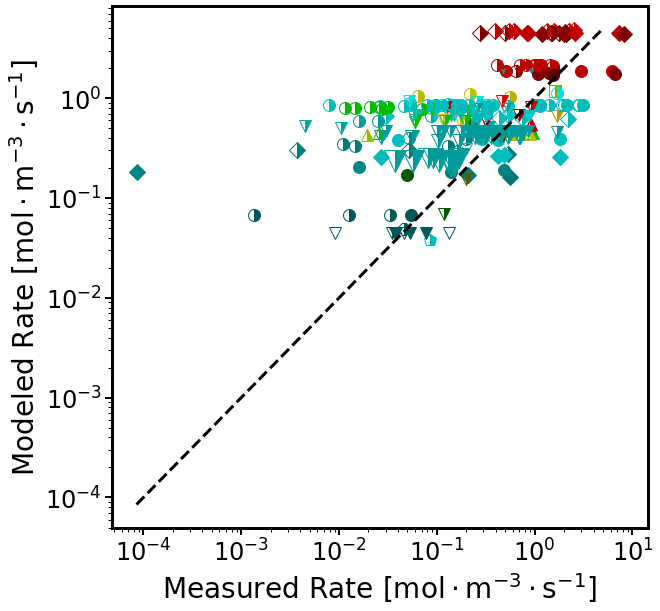

In [4]:
for ii in range(len(rawdata_df)):
    T = rawdata_df['Temp (deg C)'].iloc[ii]
    RH = rawdata_df['RH (%)'].iloc[ii]
    pct_O2 = rawdata_df['Oxygen (%)'].iloc[ii]
    N_suns_stress = rawdata_df['Illum (Nsuns)'].iloc[ii]
    thick = rawdata_df['Film Thickness [nm]'].iloc[ii]
    encap = 'none'
    m_size = math.floor(thick/50)*2 + 2
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    plt.loglog(rawdata_df['meas_rate'].iloc[ii],rawdata_df['model_rate'].iloc[ii],
                   marker=marker,
                   color=color,
                   fillstyle=fill,
                   markersize = m_size
                  )

plotrange = np.linspace(np.nanmin(rawdata_df['meas_rate']),
                        np.nanmax(rawdata_df['model_rate']),
                        num=2
                       )
plt.plot(plotrange,plotrange,'k--')
val,_ = scipy.stats.pearsonr(rawdata_df['ln|meas_rate|'],rawdata_df['ln|model_rate|'])


plt.xlabel('Measured Rate [$\mathrm{mol} \cdot \mathrm{m}^{-3} \cdot \mathrm{s}^{-1}$]')
plt.ylabel('Modeled Rate [$\mathrm{mol} \cdot \mathrm{m}^{-3} \cdot \mathrm{s}^{-1}$]')

val

# 3. Data Visualization - Nonlinearity

Make some box and whisker plots of the overall dataset to illustrate how the data vary nonlinearly with temperature and composition

Text(0, 0.5, '$\\ln(t_{L_\\mathrm{D},75})$')

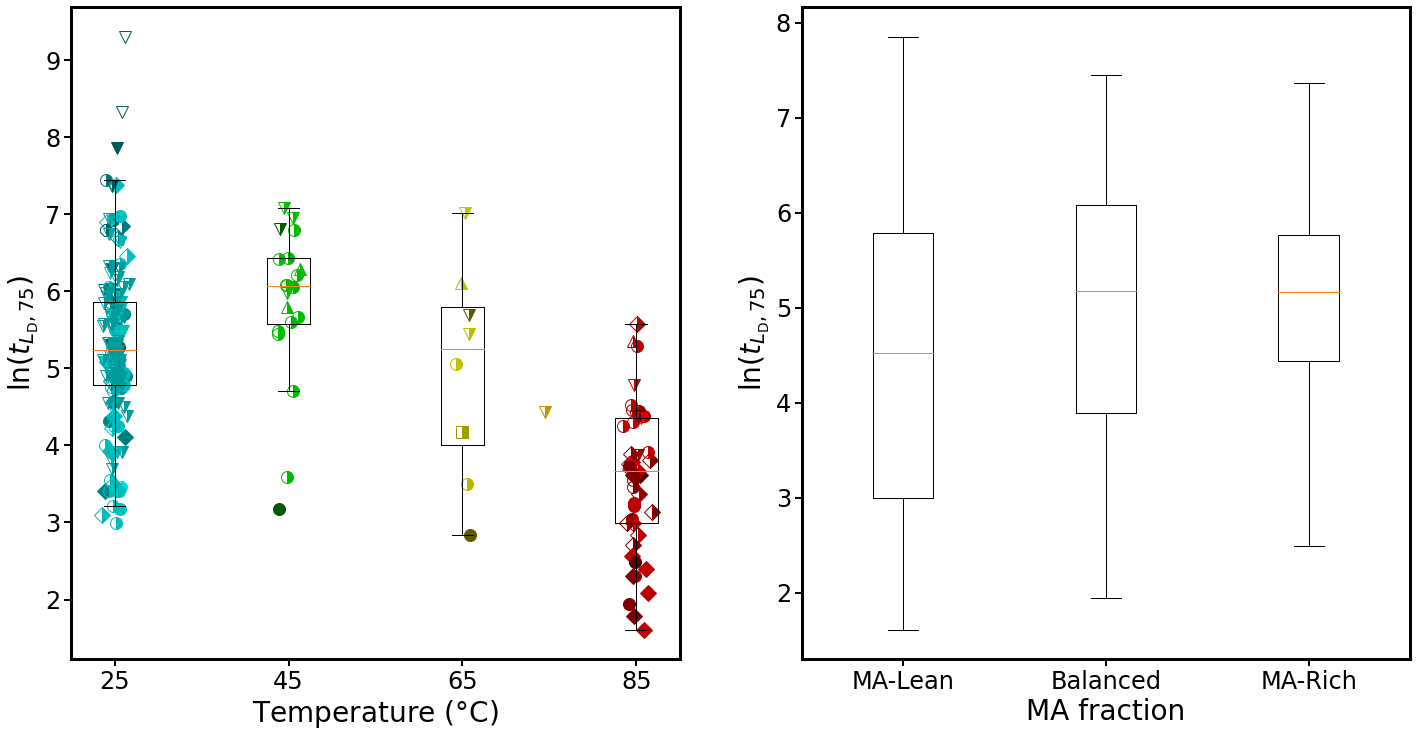

In [5]:
# Initialize the figure
fig, ax = plt.subplots(1,2,figsize=(24,12))

# temperature bins
T25 = []
T45 = []
T65 = []
T85 = []

# initialize bins for composition
MA_rich = []
MA_bal = []
MA_lean = []

# loop over datapoints in the DF
for ii in range(len(rawdata_df)):
    
    # get environmental parameters for help in plotting
    T = rawdata_df['Temp (deg C)'].iloc[ii]
    RH = rawdata_df['RH (%)'].iloc[ii]
    pct_O2 = rawdata_df['Oxygen (%)'].iloc[ii]
    N_suns_stress = rawdata_df['Illum (Nsuns)'].iloc[ii]
    encap = 'none'
    # use environmental variables to define the plot style
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    
    # grab composition
    xMA = rawdata_df['MA fraction'].iloc[ii]
    # grab tLD75
    y = np.log(rawdata_df['tLD75 (min)'].iloc[ii])
    
    # plot temperature with random jitter
    ax[0].plot(rawdata_df['Temp (deg C)'].iloc[ii]+random.gauss(0,0.75),y,
             color=color,fillstyle=fill,marker=marker,linestyle=style)
    # bin runs by temperature
    if T < 35:
        if not np.isnan(y):
            T25.append(y)
    elif T < 55:
        if not np.isnan(y):
            T45.append(y)
    elif T < 75:
        if not np.isnan(y):
            T65.append(y)
    else:
        if not np.isnan(y):
            T85.append(y)
    
    # and also by composition
    if xMA < 0.33:
        if not np.isnan(y):
            MA_lean.append(y)
    elif xMA >= 0.33 and xMA < 0.66:
        if not np.isnan(y):
            MA_bal.append(y)
    else:
        if not np.isnan(y):
            MA_rich.append(y)
            
# add the box and whisker plots for temperature...
ax[0].boxplot([T25,T45,T65,T85],positions=[25,45,65,85],widths=[5,5,5,5],showfliers=False)
ax[0].set_xlim([20,90])
ax[0].set_xlabel('Temperature ($\degree$C)')
ax[0].set_ylabel('$\ln(t_{L_\mathrm{D},75})$')

# ...and composition
ax[1].boxplot([MA_lean,MA_bal,MA_rich],labels=['MA-Lean','Balanced','MA-Rich'],showfliers=False)
ax[1].set_xlabel('MA fraction')
ax[1].set_ylabel('$\ln(t_{L_\mathrm{D},75})$')



# 4. Basic Plots of the Dataset - Contextualizing LD75

Before modeling, it is always advisable to analyze the dataset by visualization to better contextualize the predictions of the model. Here is where we make some plots for figures in the paper. 

<ipython-input-42-6a4d0596c134>:30: RuntimeWarning: invalid value encountered in log10
  ax[1,0].plot(rawdata_df['MA fraction'].iloc[ii],100*(1 + 0.059*np.log10(rawdata_df['PLFail'].iloc[ii]/rawdata_df['QFLS_0'].iloc[ii])),
C:\Users\Wiley\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


(0.0, 60.0)

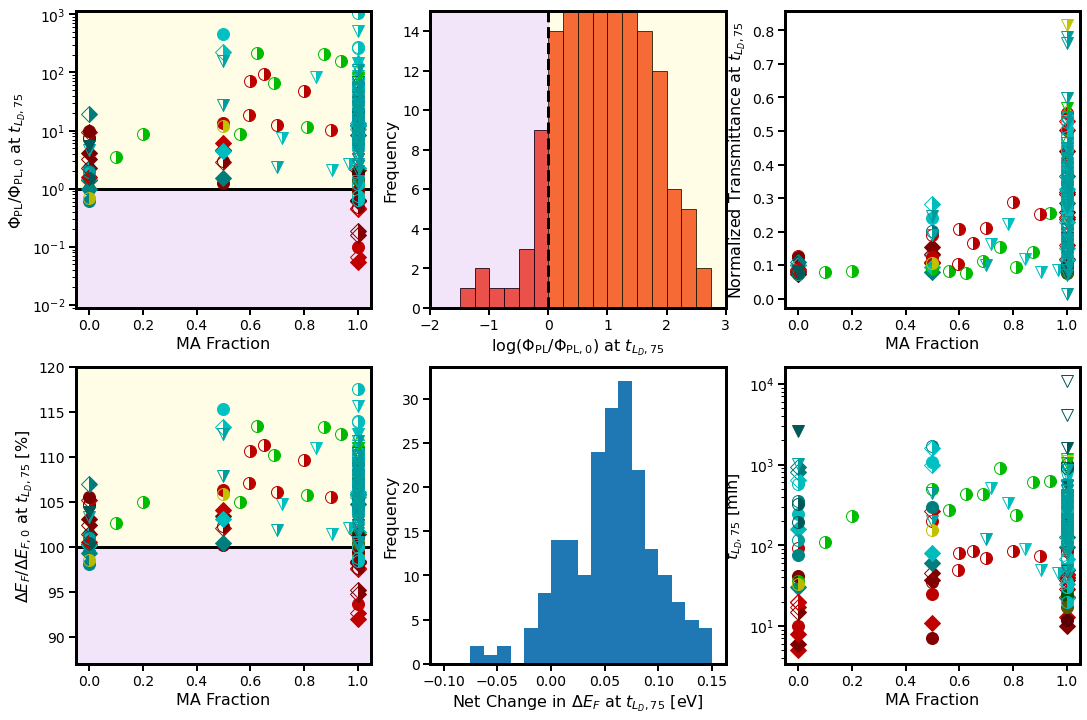

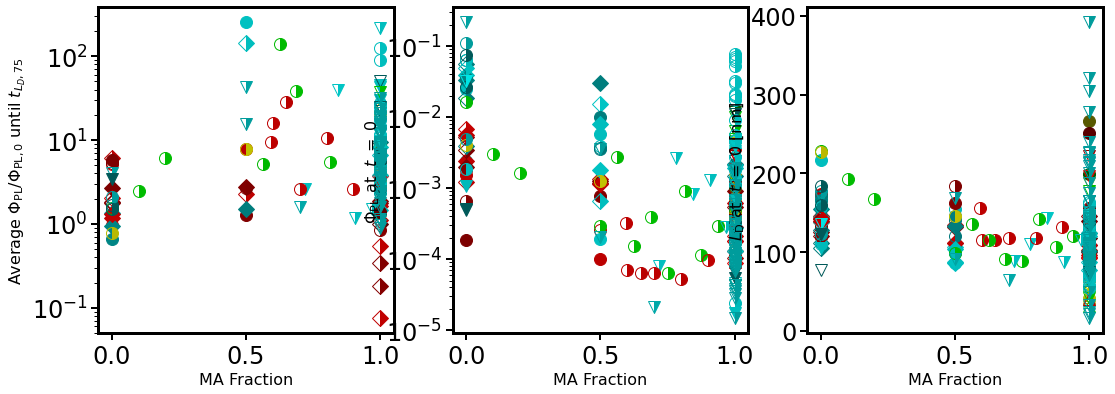

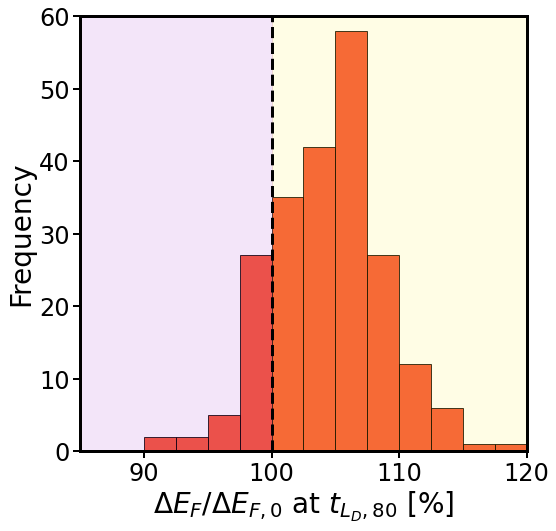

In [42]:
# Make some plots of the overall dataset
fig,ax = plt.subplots(nrows=2,ncols=3,figsize=(18,12))

def_fontsize = 16
def_labelsize = 14

ax00_xmin = -0.05
ax00_xmax = 1.05
ax00_ymin = 10**-2.05
ax00_ymax = 10**3.05

# partition graph between regions where PL has brightened/has darkened at LD75
ax[0,0].hlines(1,ax00_xmin,ax00_xmax,color='k',linestyles='-') # boundary
ax[0,0].fill([ax00_xmin,ax00_xmax,ax00_xmax,ax00_xmin],[1,1,ax00_ymax,ax00_ymax],color=(1,0.96,0,0.1)) # brightened region
ax[0,0].fill([ax00_xmin,ax00_xmax,ax00_xmax,ax00_xmin],[1,1,ax00_ymin,ax00_ymin],color=(0.56,0,0.8,0.1)) # darkened region


# set markers using environmental condition marker conventions
for ii in range(len(rawdata_df)):
    T = rawdata_df['Temp (deg C)'].iloc[ii]
    RH = rawdata_df['RH (%)'].iloc[ii]
    pct_O2 = rawdata_df['Oxygen (%)'].iloc[ii]
    N_suns_stress = rawdata_df['Illum (Nsuns)'].iloc[ii]
    encap = 'none'
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    # plot PL enhancement at tLD75 vs composition
    ax[0,0].semilogy(rawdata_df['MA fraction'].iloc[ii],rawdata_df['PLFail'].iloc[ii], 
               color=color,fillstyle=fill,marker=marker,linestyle=style)
    # plot QFLS enhancement at failure vs composition
    ax[1,0].plot(rawdata_df['MA fraction'].iloc[ii],100*(1 + 0.059*np.log10(rawdata_df['PLFail'].iloc[ii]/rawdata_df['QFLS_0'].iloc[ii])), 
               color=color,fillstyle=fill,marker=marker,linestyle=style)
    # plot transmittance enhancement at failure vs composition
    ax[0,2].plot(rawdata_df['MA fraction'].iloc[ii],rawdata_df['TrFail'].iloc[ii], 
               color=color,fillstyle=fill,marker=marker,linestyle=style)
    # plot tLD75 vs. composition
    ax[1,2].semilogy(rawdata_df['MA fraction'].iloc[ii],rawdata_df['tLD75 (min)'].iloc[ii], 
               color=color,fillstyle=fill,marker=marker,linestyle=style)

# labeling - top left plot
ax[0,0].set_xlabel('MA Fraction',fontsize=def_fontsize)
ax[0,0].set_ylabel('$\Phi_\mathrm{PL}/\Phi_\mathrm{PL,0}$ at $t_{L_D,75}$',fontsize=def_fontsize)
ax[0,0].set_xlim(ax00_xmin,ax00_xmax)
ax[0,0].set_ylim(ax00_ymin,ax00_ymax)

# set parameters for bottom left plot - quasi-Fermi level splitting enhancement vs. composition
ax10_xmin = -0.1
ax10_xmax = 1.1
ax10_ymin = 85
ax10_ymax = 120
ax[1,0].set_xlabel('MA Fraction',fontsize=def_fontsize)
ax[1,0].set_ylabel('$\Delta E_F/\Delta E_{F,0}$ at $t_{L_D,75}$ [%]',fontsize=def_fontsize)

# plot demarcations between QFLS enhancement vs. QFLS reduction
ax[1,0].hlines(100,ax10_xmin,ax10_xmax,color='k',linestyles='-') # boundary
ax[1,0].fill([ax10_xmin,ax10_xmax,ax10_xmax,ax10_xmin],[100,100,ax10_ymax,ax10_ymax],color=(1,0.96,0,0.1)) # brightened region
ax[1,0].fill([ax10_xmin,ax10_xmax,ax10_xmax,ax10_xmin],[100,100,ax10_ymin,ax10_ymin],color=(0.56,0,0.8,0.1)) # darkened region
ax[1,0].set_xlim([-0.05,1.05])
ax[1,0].set_ylim([87,120])

# set labels for top right plot - change in transmittance at tLD75
ax[0,2].set_xlabel('MA Fraction',fontsize=def_fontsize)
ax[0,2].set_ylabel('Normalized Transmittance at $t_{L_D,75}$',fontsize=def_fontsize)

# set labels for bottom right plot - LD75 vs composition
ax[1,2].set_xlabel('MA Fraction',fontsize=def_fontsize)
ax[1,2].set_ylabel('$t_{L_D,75}$ [min]',fontsize=def_fontsize)

# set dimensions for top middle panel - histogram of PL enhancements
ax[0,1].hist(np.log10(rawdata_df['PLFail'].dropna()),bins=np.linspace(-2,3,num=21),
             color='xkcd:vermillion',alpha=0.8,edgecolor='black',histtype='bar')
ax[0,1].set_xlabel('log($\Phi_\mathrm{PL}/\Phi_\mathrm{PL,0}$) at $t_{L_D,75}$',fontsize=def_fontsize)
ax[0,1].set_ylabel('Frequency',fontsize=def_fontsize)

# partition graph between regions where PL has brightened/has darkened at LD75
ax[0,1].vlines(0,0,15,color='k',linestyles='--')
ax[0,1].fill([0,0,3,3],[0,15,15,0],color=(1,0.96,0,0.1)) # brightened region
ax[0,1].fill([0,0,-2,-2],[0,15,15,0],color=(0.56,0,0.8,0.1)) # brightened region
ax[0,1].set_xlim(-2,3)
ax[0,1].set_ylim(0,15)

# bottom middle plot - histogram of change in QFLS at failure
ax[1,1].hist(0.059*np.log10(rawdata_df['PLFail']),bins=np.linspace(-0.1,0.15,num=21))
ax[1,1].set_xlabel('Net Change in $\Delta E_F$ at $t_{L_D,75}$ [eV]',fontsize=def_fontsize)
ax[1,1].set_ylabel('Frequency',fontsize=def_fontsize)

# change the tick label sizes on all the panels
for ii in range(2):
    for jj in range(3):
        ax[ii,jj].tick_params(axis='x', labelsize=def_labelsize)
        ax[ii,jj].tick_params(axis='y', labelsize=def_labelsize)

# make a new figure
fig2,ax2 = plt.subplots(nrows=1,ncols=3,figsize=(18,6))
for ii in range(len(rawdata_df)):
    T = rawdata_df['Temp (deg C)'].iloc[ii]
    RH = rawdata_df['RH (%)'].iloc[ii]
    pct_O2 = rawdata_df['Oxygen (%)'].iloc[ii]
    N_suns_stress = rawdata_df['Illum (Nsuns)'].iloc[ii]
    encap = 'none'
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    
    ax2[0].semilogy(rawdata_df['MA fraction'].iloc[ii],rawdata_df['PLEnhance'].iloc[ii], 
               color=color,fillstyle=fill,marker=marker,linestyle=style)
    
    ax2[1].semilogy(rawdata_df['MA fraction'].iloc[ii],rawdata_df['PLQY_0'].iloc[ii], 
               color=color,fillstyle=fill,marker=marker,linestyle=style)
    
    ax2[2].plot(rawdata_df['MA fraction'].iloc[ii],rawdata_df['LD_0 (nm)'].iloc[ii], 
               color=color,fillstyle=fill,marker=marker,linestyle=style)
    
ax2[0].set_xlabel('MA Fraction',fontsize=def_fontsize)
ax2[0].set_ylabel('Average $\Phi_\mathrm{PL}/\Phi_\mathrm{PL,0}$ until $t_{L_D,75}$',fontsize=def_fontsize)
    
ax2[1].set_xlabel('MA Fraction',fontsize=def_fontsize)
ax2[1].set_ylabel('$\Phi_\mathrm{PL}$ at  $t\ =\ 0$',fontsize=def_fontsize)    

ax2[2].set_xlabel('MA Fraction',fontsize=def_fontsize)
ax2[2].set_ylabel('$L_\mathrm{D}$ at  $t\ =\ 0$ [nm]',fontsize=def_fontsize)

fig3, ax3 = plt.subplots(figsize=(8,8))
ax3.hist((100*(1 + 0.059*np.log10(rawdata_df['PL_LD80']/rawdata_df['QFLS_0']))).dropna(), 
         bins = np.linspace(85,120,num=15),color='xkcd:vermillion',alpha=0.8,edgecolor='black',histtype='bar')
ax3.set_xlabel('$\Delta E_F/\Delta E_{F,0}$ at $t_{L_D,80}$ [%]')
ax3.set_ylabel('Frequency')

vert_max = 60
# partition graph between regions where PL has brightened/has darkened at LD75
ax3.vlines(100,0,vert_max,color='k',linestyles='--')
ax3.fill([100,100,120,120],[0,vert_max,vert_max,0],color=(1,0.96,0,0.1)) # brightened region
ax3.fill([100,100,85,85],[0,vert_max,vert_max,0],color=(0.56,0,0.8,0.1)) # brightened region
ax3.set_xlim(85,120)
ax3.set_ylim(0,vert_max)

In [43]:
# set up plotting to identify batches

batch_colors = {'WDS90':'xkcd:orchid',
                'TDS33':'xkcd:terracotta',
                'TDS-33':'xkcd:terracotta',
                'KT34':'xkcd:seafoam',
                'WDS92':'xkcd:maroon',
                'WDS-92':'xkcd:maroon',
                'WDS89':'xkcd:forest green',
                'E01':'xkcd:teal',
                'HBQ2':'xkcd:cerulean',
                'WDS-54':'xkcd:goldenrod',
                'YM-2':'xkcd:eggplant',
                'KT-20':'xkcd:vermillion',            
                'KT-24':'xkcd:acid green',
                'YM-9':'xkcd:fuchsia',
                'JW1-I':'xkcd:ochre',
                'JW1-OAc':'xkcd:orange',
                'WDS97':'xkcd:cobalt blue',
                'WDS-63':'xkcd:scarlet',
                'RK1-SW':'xkcd:moss green',
                'RK1-GQ':'xkcd:mauve', 
                'WDS99':'xkcd:watermelon',
                'WDS100-an':'xkcd:turquoise',
                'WDS100-ac':'xkcd:periwinkle',
                }

batch_markers = {'WDS90':'o', # circles: standard anti-solvent immersion in diethyl ether
                'TDS33':'o',
                'TDS-33':'o',
                'KT34':'o',
                'WDS92':'o',
                'WDS-92':'o',
                'WDS89':'o',
                'E01':'o',
                'HBQ2':'o',
                'WDS-54':'o',
                'YM-2':'o',
                'KT-20':'o',            
                'KT-24':'o',
                'YM-9':'o',
                'JW1-I':'D', # diamonds: anti-solvent immersion in anisole
                'JW1-OAc':'p', # one-step spin coating from lead acetate precursor
                'WDS97':'o', # stoichiometry study
                'WDS-63':'o', 
                'RK1-SW':'s', # solvent washing
                'RK1-GQ':'^', # gas quenching
                'WDS99':'o',
                'WDS100-an':'D',
                'WDS100-ac':'p',
                }

KeyError: 'HBQ11'

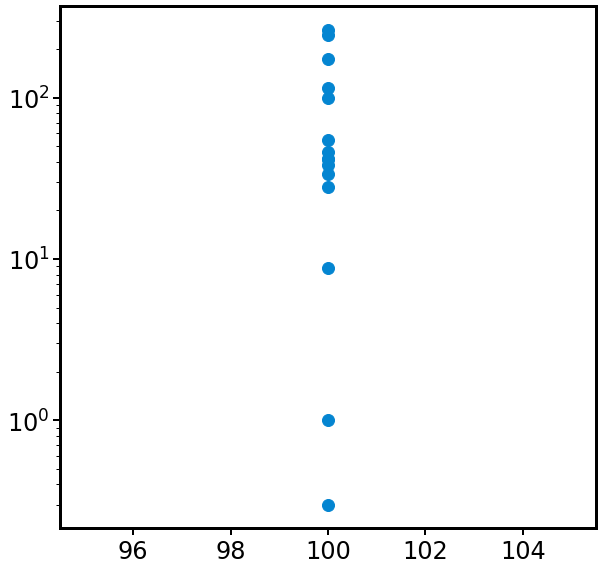

In [44]:
# look at influences of stoichiometry

MA_95 = []
MA_97p5 = []
MA_100 = []
MA_102p5 = []
MA_105 = []

comp_var = 'tLD80 corrected (min)'
#comp_var = '|dAdt|'

# break down raw data DF by MA fraction
for ii in range(len(rawdata_df)):
    
    if rawdata_df['Method'].iloc[ii] == 'ether immersion':
        
        plt.semilogy(rawdata_df['MA fraction'].iloc[ii]*100,rawdata_df[comp_var].iloc[ii],
                     marker=batch_markers[rawdata_df['BatchID'].iloc[ii]],
                     color=batch_colors[rawdata_df['BatchID'].iloc[ii]])
        
        if rawdata_df['MA fraction'].iloc[ii] == 0.95:
            MA_95.append(rawdata_df[comp_var].iloc[ii])
            plt.plot(rawdata_df['MA fraction'].iloc[ii]*100,rawdata_df[comp_var].iloc[ii],
               marker='v',color='xkcd:white',markersize=8) 
        
        elif rawdata_df['MA fraction'].iloc[ii] == 0.975:
            MA_97p5.append(rawdata_df[comp_var].iloc[ii])
            plt.plot(rawdata_df['MA fraction'].iloc[ii]*100,rawdata_df[comp_var].iloc[ii],
               marker='v',color='xkcd:white',markersize=4)
        
        elif rawdata_df['MA fraction'].iloc[ii] == 1:
            MA_100.append(rawdata_df[comp_var].iloc[ii])
        
        elif rawdata_df['MA fraction'].iloc[ii] == 1.025:
            MA_102p5.append(rawdata_df[comp_var].iloc[ii])
            plt.plot(rawdata_df['MA fraction'].iloc[ii]*100,rawdata_df[comp_var].iloc[ii],
               marker='^',color='xkcd:white',markersize=4)
        
        elif rawdata_df['MA fraction'].iloc[ii] == 1.05:
            MA_105.append(rawdata_df[comp_var].iloc[ii])
            plt.plot(rawdata_df['MA fraction'].iloc[ii]*100,rawdata_df[comp_var].iloc[ii],
               marker='^',color='xkcd:white',markersize=8)

        
plt.xlabel('Amount of MAI in Precursor Ink [%]')
if comp_var == 'tLD80 corrected (min)':
    plt.ylabel('T80-$L_\mathrm{D}$ [min]')
elif comp_var == '|dAdt|':
    plt.ylabel('$|\mathrm{d}A/\mathrm{d}t|\ \mathrm{[min^{-1}]}$')
    
plt.xlim([94,106])

plt.figure()
avg_TLD80s = [np.mean(MA_95),
              np.mean(MA_97p5),
              np.mean(MA_100),
              np.mean(MA_102p5),
              np.mean(MA_105),
             ]

std_TLD80s = [np.std(MA_95),
              np.std(MA_97p5),
              np.std(MA_100),
              np.std(MA_102p5),
              np.std(MA_105),
             ]

MA_pcts = [95,97.5,100,102.5,105]

plt.errorbar(MA_pcts,avg_TLD80s,yerr=std_TLD80s, capsize=10, marker='o', linestyle=' ')
plt.xlabel('Amount of MAI in Precursor Ink [%]')
if comp_var == 'tLD80 corrected (min)':
    plt.ylabel('T80-$L_\mathrm{D}$ [min]')
elif comp_var == '|dAdt|':
    plt.ylabel('$|\mathrm{d}A/\mathrm{d}t|\ \mathrm{[min^{-1}]}$')



In [ ]:
# look at influences of stoichiometry

MA_95 = []
MA_97p5 = []
MA_100 = []
MA_102p5 = []
MA_105 = []

# break down raw data DF by MA fraction
for ii in range(len(rawdata_df)):
    plt.semilogy(rawdata_df['MA fraction'].iloc[ii],rawdata_df['|dAdt|'].iloc[ii],
                 marker=batch_markers[rawdata_df['BatchID'].iloc[ii]],
                 color=batch_colors[rawdata_df['BatchID'].iloc[ii]])
    if rawdata_df['MA fraction'].iloc[ii] == 0.95:
        MA_95.append(rawdata_df['|dAdt|'].iloc[ii])
    elif rawdata_df['MA fraction'].iloc[ii] == 0.975:
        MA_97p5.append(rawdata_df['|dAdt|'].iloc[ii])
    elif rawdata_df['MA fraction'].iloc[ii] == 1:
        MA_100.append(rawdata_df['|dAdt|'].iloc[ii])
    elif rawdata_df['MA fraction'].iloc[ii] == 1.025:
        MA_102p5.append(rawdata_df['|dAdt|'].iloc[ii])
    elif rawdata_df['MA fraction'].iloc[ii] == 1.05:
        MA_105.append(rawdata_df['|dAdt|'].iloc[ii])

LD80s = [MA_95,MA_97p5,MA_100,MA_102p5,MA_105]
plt.figure()
plt.boxplot(LD80s)


In [ ]:

Tr_LD80_fig = plt.figure(figsize=(8,8))
main_ax = Tr_LD80_fig.add_axes([0,0,0.85,0.85])
#main_ax.fill([Tr_ax_lims[0],1,1,Tr_ax_lims[0],Tr_ax_lims[0]],[1,1,LD80_ax_lims[1],LD80_ax_lims[1],1],color=(0.5,0,0,0.1))
#main_ax.fill([Tr_ax_lims[0],1,1,Tr_ax_lims[0],Tr_ax_lims[0]],[LD80_ax_lims[0],LD80_ax_lims[0],1,1,tau_ax_lims[0]],color=(0.5,0,0.5,0.1))
#main_ax.fill([1,mu_ax_lims[1],mu_ax_lims[1],1,1],[tau_ax_lims[0],tau_ax_lims[0],1,1,tau_ax_lims[0]],color=(0,0,0.5,0.1))
#main_ax.hlines(1,*Tr_ax_lims) 
#main_ax.vlines(1,*LD80_ax_lims)
#mu_range = np.linspace(1e-2,2e0,num=101)
#main_ax.plot(mu_range,0.8**2/mu_range,'k--')
#main_ax.set_xlim(Tr_ax_lims)
#main_ax.set_ylim(LD80_ax_lims)
main_ax.set_xlabel('$\mathrm{d}\mathcal{T}/\mathrm{d}t$ [min$^{-1}$]')
main_ax.set_ylabel('$t_{L_\mathrm{D},80}$ [min]')


for ii in range(len(rawdata_df)):
    T = rawdata_df['Temp (deg C)'].iloc[ii]
    RH = rawdata_df['RH (%)'].iloc[ii]
    pct_O2 = rawdata_df['Oxygen (%)'].iloc[ii]
    N_suns_stress = rawdata_df['Illum (Nsuns)'].iloc[ii]
    thick = rawdata_df['Film Thickness [nm]'].iloc[ii]
    encap = 'none'
    m_size = math.floor(thick/50)*2 + 2
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    main_ax.loglog(rawdata_df['Bleach Rate (polyfit) (1/min)'].iloc[ii],rawdata_df['tLD80 (min)'].iloc[ii],
                   marker=marker,
                   color=color,
                   fillstyle=fill,
                   markersize = m_size
                  )

main_ax.set_xscale('log')
main_ax.set_yscale('log')

#main_ax.set_xlim([2e-5,1e-3])
#main_ax.set_ylim([7e1,1e3])

#Tr_ax_lims = np.array([0.000009,.011])
log_Tr_ax_lims = np.log10(np.array(main_ax.get_xlim()))


LD80_ax_lims = np.array([9,1300])
log_LD80_ax_lims = np.log10(np.array(main_ax.get_ylim()))

LD80_ax = Tr_LD80_fig.add_axes([0.9,0,0.1,0.85])
LD80_ax.hist(np.log10(rawdata_df['tLD80 corrected (min)']),orientation=u'horizontal',bins=10)
LD80_ax.set_ylim(log_LD80_ax_lims)
#LD80_ax.set_xlim([0,20])
LD80_ax.set_yticks([])
LD80_ax.set_xlabel('Frequency',fontsize=12)
LD80_ax.tick_params(axis='x', labelsize=12)


Tr_ax = Tr_LD80_fig.add_axes([0,0.9,0.85,0.1])
Tr_ax.hist(np.log10(rawdata_df['Bleach Rate (polyfit) (1/min)']),bins=10)
Tr_ax.set_xlim(log_Tr_ax_lims)
Tr_ax.set_xticks([])
Tr_ax.set_ylabel('Frequency',fontsize=12)
Tr_ax.tick_params(axis='y', labelsize=12)


nas = np.logical_or(np.isnan(rawdata_df['Bleach Rate (polyfit) (1/min)'].values),np.isnan(rawdata_df['tLD80 (min)'].values))
log_fit = np.polyfit(np.log(rawdata_df['Bleach Rate (polyfit) (1/min)'].values[~nas]),np.log(rawdata_df['tLD80 (min)'].values[~nas]),1)
bleach_range = np.linspace(np.min(rawdata_df['Bleach Rate (polyfit) (1/min)']),np.max(rawdata_df['Bleach Rate (polyfit) (1/min)']),num=101)
main_ax.plot(bleach_range,np.exp(log_fit[1])*bleach_range**(log_fit[0]),'k--')

r,_ = scipy.stats.pearsonr(np.log(rawdata_df['Bleach Rate (polyfit) (1/min)'].values[~nas]),np.log(rawdata_df['tLD80 (min)'].values[~nas]))
main_ax.text(0.6e-4,700,'Pearson Correlation: \n $\\rho$ = ' + str(np.round(r,4)),fontsize=20)



In [ ]:


Tr_LD80_fig = plt.figure(figsize=(8,8))
main_ax = Tr_LD80_fig.add_axes([0,0,0.85,0.85])
#main_ax.fill([Tr_ax_lims[0],1,1,Tr_ax_lims[0],Tr_ax_lims[0]],[1,1,LD80_ax_lims[1],LD80_ax_lims[1],1],color=(0.5,0,0,0.1))
#main_ax.fill([Tr_ax_lims[0],1,1,Tr_ax_lims[0],Tr_ax_lims[0]],[LD80_ax_lims[0],LD80_ax_lims[0],1,1,tau_ax_lims[0]],color=(0.5,0,0.5,0.1))
#main_ax.fill([1,mu_ax_lims[1],mu_ax_lims[1],1,1],[tau_ax_lims[0],tau_ax_lims[0],1,1,tau_ax_lims[0]],color=(0,0,0.5,0.1))
#main_ax.hlines(1,*Tr_ax_lims) 
#main_ax.vlines(1,*LD80_ax_lims)
#mu_range = np.linspace(1e-2,2e0,num=101)
#main_ax.plot(mu_range,0.8**2/mu_range,'k--')
#main_ax.set_xlim(Tr_ax_lims)
#main_ax.set_ylim(LD80_ax_lims)
main_ax.set_xlabel('$t_\mathrm{PL,max}$ [min]')
main_ax.set_ylabel('$t_{L_\mathrm{D},80}$ [min]')


for ii in range(len(rawdata_df)):
    T = rawdata_df['Temp (deg C)'].iloc[ii]
    RH = rawdata_df['RH (%)'].iloc[ii]
    pct_O2 = rawdata_df['Oxygen (%)'].iloc[ii]
    N_suns_stress = rawdata_df['Illum (Nsuns)'].iloc[ii]
    thick = rawdata_df['Film Thickness [nm]'].iloc[ii]
    encap = 'none'
    m_size = math.floor(thick/50)*2 + 2
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    main_ax.loglog(rawdata_df['tPLmax'].iloc[ii],rawdata_df['tLD80 (min)'].iloc[ii],
                   marker=marker,
                   color=color,
                   fillstyle=fill,
                   markersize = m_size
                  )

main_ax.set_xscale('log')
main_ax.set_yscale('log')

#Tr_ax_lims = np.array([0.000009,.011])
log_Tr_ax_lims = np.log10(np.array(main_ax.get_xlim()))

LD80_ax_lims = np.array([9,1300])
log_LD80_ax_lims = np.log10(np.array(main_ax.get_ylim()))

LD80_ax = Tr_LD80_fig.add_axes([0.9,0,0.1,0.85])
LD80_ax.hist(np.log10(rawdata_df['tLD80 (min)']),orientation=u'horizontal',bins=10)
LD80_ax.set_ylim(log_LD80_ax_lims)
#LD80_ax.set_xlim([0,20])
LD80_ax.set_yticks([])
LD80_ax.set_xlabel('Frequency',fontsize=12)
LD80_ax.tick_params(axis='x', labelsize=12)


Tr_ax = Tr_LD80_fig.add_axes([0,0.9,0.85,0.1])
Tr_ax.hist(np.log10(rawdata_df['tPLmax']),bins=10)
Tr_ax.set_xlim(log_Tr_ax_lims)
Tr_ax.set_xticks([])
Tr_ax.set_ylabel('Frequency',fontsize=12)
Tr_ax.tick_params(axis='y', labelsize=12)


nas = np.logical_or(np.isnan(rawdata_df['tPLmax'].values),np.isnan(rawdata_df['tLD80 (min)'].values))
log_fit = np.polyfit(np.log(rawdata_df['tPLmax'].values[~nas]),np.log(rawdata_df['tLD80 (min)'].values[~nas]),1)
bleach_range = np.linspace(np.min(rawdata_df['tPLmax']),np.max(rawdata_df['tPLmax']),num=101)
main_ax.plot(bleach_range,np.exp(log_fit[1])*bleach_range**(log_fit[0]),'k--')

r,_ = scipy.stats.pearsonr(np.log(rawdata_df['tPLmax'].values[~nas]),np.log(rawdata_df['tLD80 (min)'].values[~nas]))
main_ax.text(100,350,'Pearson Correlation: \n $\\rho$ = ' + str(np.round(r,4)),fontsize=20)

print('Power',log_fit[0])

In [ ]:


Tr_LD80_fig = plt.figure(figsize=(8,8))
main_ax = Tr_LD80_fig.add_axes([0,0,0.85,0.85])
#main_ax.fill([Tr_ax_lims[0],1,1,Tr_ax_lims[0],Tr_ax_lims[0]],[1,1,LD80_ax_lims[1],LD80_ax_lims[1],1],color=(0.5,0,0,0.1))
#main_ax.fill([Tr_ax_lims[0],1,1,Tr_ax_lims[0],Tr_ax_lims[0]],[LD80_ax_lims[0],LD80_ax_lims[0],1,1,tau_ax_lims[0]],color=(0.5,0,0.5,0.1))
#main_ax.fill([1,mu_ax_lims[1],mu_ax_lims[1],1,1],[tau_ax_lims[0],tau_ax_lims[0],1,1,tau_ax_lims[0]],color=(0,0,0.5,0.1))
#main_ax.hlines(1,*Tr_ax_lims) 
#main_ax.vlines(1,*LD80_ax_lims)
#mu_range = np.linspace(1e-2,2e0,num=101)
#main_ax.plot(mu_range,0.8**2/mu_range,'k--')
#main_ax.set_xlim(Tr_ax_lims)
#main_ax.set_ylim(LD80_ax_lims)
main_ax.set_xlabel('$t_\mathrm{PL,max}$ [min]')
main_ax.set_ylabel('$t_{L_\mathrm{D}\mathrm{,max}}$ [min]')


for ii in range(len(rawdata_df)):
    T = rawdata_df['Temp (deg C)'].iloc[ii]
    RH = rawdata_df['RH (%)'].iloc[ii]
    pct_O2 = rawdata_df['Oxygen (%)'].iloc[ii]
    N_suns_stress = rawdata_df['Illum (Nsuns)'].iloc[ii]
    encap = 'none'
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    main_ax.loglog(rawdata_df['tPLmax'].iloc[ii],rawdata_df['tLDmax'].iloc[ii],marker='o',color=batch_colors[rawdata_df['BatchID'].iloc[ii]])

main_ax.set_xscale('log')
main_ax.set_yscale('log')

#Tr_ax_lims = np.array([0.000009,.011])
log_Tr_ax_lims = np.log10(np.array(main_ax.get_xlim()))

LD80_ax_lims = np.array([9,1300])
log_LD80_ax_lims = np.log10(np.array(main_ax.get_ylim()))

LD80_ax = Tr_LD80_fig.add_axes([0.9,0,0.1,0.85])
LD80_ax.hist(np.log10(rawdata_df['tLDmax']),orientation=u'horizontal',bins=10)
LD80_ax.set_ylim(log_LD80_ax_lims)
#LD80_ax.set_xlim([0,20])
LD80_ax.set_yticks([])
LD80_ax.set_xlabel('Frequency',fontsize=12)
LD80_ax.tick_params(axis='x', labelsize=12)


Tr_ax = Tr_LD80_fig.add_axes([0,0.9,0.85,0.1])
Tr_ax.hist(np.log10(rawdata_df['tPLmax']),bins=10)
Tr_ax.set_xlim(log_Tr_ax_lims)
Tr_ax.set_xticks([])
Tr_ax.set_ylabel('Frequency',fontsize=12)
Tr_ax.tick_params(axis='y', labelsize=12)


nas = np.logical_or(np.isnan(rawdata_df['tPLmax'].values),np.isnan(rawdata_df['tLDmax'].values))
log_fit = np.polyfit(np.log(rawdata_df['tPLmax'].values[~nas]),np.log(rawdata_df['tLDmax'].values[~nas]),1)
bleach_range = np.linspace(np.min(rawdata_df['tPLmax']),np.max(rawdata_df['tPLmax']),num=101)
main_ax.plot(bleach_range,np.exp(log_fit[1])*bleach_range**(log_fit[0]),'k--')
main_ax.plot(bleach_range,bleach_range,'r--')

r,_ = scipy.stats.pearsonr(np.log(rawdata_df['tPLmax'].values[~nas]),np.log(rawdata_df['tLDmax'].values[~nas]))
main_ax.text(100,350,'Pearson Correlation: \n $\\rho$ = ' + str(np.round(r,4)),fontsize=20)



In [ ]:
# find indices corresponding to mean, median, and max runs
min_iloc = np.argmin(rawdata_df['tLD80 corrected (min)'])
max_iloc = np.argmax(rawdata_df['tLD80 corrected (min)'])
med_iloc = np.argmin(np.abs(np.median(rawdata_df['tLD80 corrected (min)']) - rawdata_df['tLD80 corrected (min)']))

run_locs = [min_iloc,med_iloc,max_iloc]

fig = plt.figure(figsize = (12,12))
min_ax = fig.add_axes([0,0.667,1,0.333])
med_ax = fig.add_axes([0,0.333,1,0.333])
max_ax = fig.add_axes([0,0,    1,0.333])
axes = [min_ax,med_ax,max_ax]

EP1 = 'G:/Shared drives/Effort_Perovskites/Machine_Learning/Data/Timeseries/'
EP2 = 'G:/Shared drives/Effort_Perovskites_2/Machine_Learning/Data/Timeseries/'
EP3 = 'G:/.shortcut-targets-by-id/1QYKycHbBYmm38jHyBiIHndq6dxjR_RwH/Effort_Perovskites_3/Machine_Learning/Data/Timeseries/'

drive_dict = {'EP1':EP1,
              'EP2':EP2,
              'EP3':EP3,
             }



for jj,ii in enumerate(run_locs):
    data = pd.read_csv(drive_dict[rawdata_df['Drive'].iloc[ii]] + '/' 
                       + rawdata_df['ClassID'].iloc[ii] + '/'
                       + rawdata_df['ExptID'].iloc[ii] + '/analyzed_data.csv'
                      )
    t_min = data['t'].values/60
    LD_norm = data['Low Freq LD [norm]'].values
    PL_norm = data['PLQY_xy0t0'].values/data['PLQY_xy0t0'].values[0]
    Tr_norm = data['Transmitted Power [norm]'].values
    axes[jj].semilogy(t_min,LD_norm,color='xkcd:cerulean',marker='.',linestyle=' ')
    axes[jj].semilogy(t_min,PL_norm,color='xkcd:crimson',marker='.',linestyle=' ')
    axes[jj].semilogy(t_min,Tr_norm,color='xkcd:emerald green',marker='.',linestyle=' ')
    axes[jj].set_xlim([-50,1500])

In [ ]:

for ii in range(len(rawdata_df)):
    thick = rawdata_df['Film Thickness [nm]'].iloc[ii]
    encap = 'none'
    m_size = math.floor(thick/50)*2 + 2
    plt.semilogy(rawdata_df['Bleach Rate (polyfit) (1/min)'].iloc[ii],rawdata_df['tLD80 corrected (min)'].iloc[ii],
                 marker='o',color=batch_colors[rawdata_df['BatchID'].iloc[ii]],
                markersize=m_size)


nas = np.logical_or(np.isnan(rawdata_df['Bleach Rate (polyfit) (1/min)'].values),np.isnan(rawdata_df['tLD80 corrected (min)'].values))
log_fit = np.polyfit(rawdata_df['Bleach Rate (polyfit) (1/min)'].values[~nas],np.log(rawdata_df['tLD80 corrected (min)'].values[~nas]),1)
bleach_range = np.linspace(np.min(rawdata_df['Bleach Rate (polyfit) (1/min)']),np.max(rawdata_df['Bleach Rate (polyfit) (1/min)']),num=101)
plt.plot(bleach_range,np.exp(log_fit[0]*bleach_range)*np.exp((log_fit[1])),'k--')

r,_ = scipy.stats.pearsonr(rawdata_df['Bleach Rate (polyfit) (1/min)'].values[~nas],np.log(rawdata_df['tLD80 corrected (min)'].values[~nas]))
plt.text(4e-4,350,'Pearson Correlation: \n $\\rho$ = ' + str(np.round(r,4)),fontsize=20)

plt.xlabel('$\mathrm{d}\mathcal{T}/\mathrm{d}t$ [min$^{-1}$]')
plt.ylabel('$t_{L_\mathrm{D},80}$ [min]')

In [ ]:
# variable for comparison
comp_var = 'PLQY_0'
var_label = '$\phi_\mathrm{PL}$'

for ii in range(len(rawdata_df)):
    thick = rawdata_df['Film Thickness [nm]'].iloc[ii]
    encap = 'none'
    m_size = math.floor(thick/50)*2 + 2
    plt.loglog(rawdata_df[comp_var].iloc[ii],rawdata_df['tLD80 corrected (min)'].iloc[ii],
               marker='o',color=batch_colors[rawdata_df['BatchID'].iloc[ii]],
               markersize=m_size
              )


nas = np.logical_or(np.isnan(rawdata_df[comp_var].values),np.isnan(rawdata_df['tLD80 corrected (min)'].values))
log_fit = np.polyfit(np.log(rawdata_df[comp_var].values[~nas]),np.log(rawdata_df['tLD80 corrected (min)'].values[~nas]),1)
bleach_range = np.linspace(np.min(rawdata_df[comp_var].values),np.max(rawdata_df[comp_var].values),num=101)
plt.plot(bleach_range,np.exp((log_fit[1]))*bleach_range**log_fit[0],'k--')

r,_ = scipy.stats.pearsonr(np.log(rawdata_df[comp_var].values[~nas]),np.log(rawdata_df['tLD80 corrected (min)'].values[~nas]))
plt.text(4e-4,350,'Pearson Correlation: \n $\\rho$ = ' + str(np.round(r,4)),fontsize=20)

plt.xlabel(var_label)
plt.ylabel('$t_{L_\mathrm{D},80}$ [min]')

r

In [ ]:
# variable for comparison
comp_var = 'PLQY_0'
var_label = '$\phi_\mathrm{PL}$'

for ii in range(len(rawdata_df)):
    thick = rawdata_df['Film Thickness [nm]'].iloc[ii]
    encap = 'none'
    m_size = math.floor(thick/50)*2 + 2
    plt.semilogy(rawdata_df[comp_var].iloc[ii],rawdata_df['tLD80 corrected (min)'].iloc[ii],
                 marker=batch_markers[rawdata_df['BatchID'].iloc[ii]],
                 color=batch_colors[rawdata_df['BatchID'].iloc[ii]],
                 markersize=m_size
                )
    if rawdata_df['MA fraction'].iloc[ii] == 0.95:
        plt.plot(rawdata_df[comp_var].iloc[ii],rawdata_df['tLD80 corrected (min)'].iloc[ii],
               marker='v',color='xkcd:white',markersize=8) 
    elif rawdata_df['MA fraction'].iloc[ii] == 0.975:
        plt.plot(rawdata_df[comp_var].iloc[ii],rawdata_df['tLD80 corrected (min)'].iloc[ii],
               marker='v',color='xkcd:white',markersize=4)
    elif rawdata_df['MA fraction'].iloc[ii] == 1.025:
        plt.plot(rawdata_df[comp_var].iloc[ii],rawdata_df['tLD80 corrected (min)'].iloc[ii],
               marker='^',color='xkcd:white',markersize=4)
    elif rawdata_df['MA fraction'].iloc[ii] == 1.05:
        plt.plot(rawdata_df[comp_var].iloc[ii],rawdata_df['tLD80 corrected (min)'].iloc[ii],
               marker='^',color='xkcd:white',markersize=8)


nas = np.logical_or(np.isnan(rawdata_df[comp_var].values),np.isnan(rawdata_df['tLD80 corrected (min)'].values))
log_fit = np.polyfit(rawdata_df[comp_var].values[~nas],np.log(rawdata_df['tLD80 corrected (min)'].values[~nas]),1)
bleach_range = np.linspace(np.min(rawdata_df[comp_var].values),np.max(rawdata_df[comp_var].values),num=101)
plt.plot(bleach_range,np.exp(log_fit[1])*np.exp(bleach_range*log_fit[0]),'k--')

r,_ = scipy.stats.pearsonr(rawdata_df[comp_var].values[~nas],np.log(rawdata_df['tLD80 corrected (min)'].values[~nas]))
plt.text(4e-5,350,'Pearson Correlation: \n $\\rho$ = ' + str(np.round(r,4)),fontsize=20)

plt.xlabel(var_label)
plt.ylabel('$t_{L_\mathrm{D},80}$ [min]')

r

In [ ]:
# variable for comparison
comp_var = 'PLQY_0'
var_label = '$\phi_\mathrm{PL}$'

for ii in range(len(rawdata_df)):
    plt.semilogy(rawdata_df[comp_var].iloc[ii],rawdata_df['tPLmax'].iloc[ii],
                 marker=batch_markers[rawdata_df['BatchID'].iloc[ii]],
                 color=batch_colors[rawdata_df['BatchID'].iloc[ii]])
    if rawdata_df['MA fraction'].iloc[ii] == 0.95:
        plt.plot(rawdata_df[comp_var].iloc[ii],rawdata_df['tPLmax'].iloc[ii],
               marker='v',color='xkcd:white',markersize=8) 
    elif rawdata_df['MA fraction'].iloc[ii] == 0.975:
        plt.plot(rawdata_df[comp_var].iloc[ii],rawdata_df['tPLmax'].iloc[ii],
               marker='v',color='xkcd:white',markersize=4)
    elif rawdata_df['MA fraction'].iloc[ii] == 1.025:
        plt.plot(rawdata_df[comp_var].iloc[ii],rawdata_df['tPLmax'].iloc[ii],
               marker='^',color='xkcd:white',markersize=4)
    elif rawdata_df['MA fraction'].iloc[ii] == 1.05:
        plt.plot(rawdata_df[comp_var].iloc[ii],rawdata_df['tPLmax'].iloc[ii],
               marker='^',color='xkcd:white',markersize=8)


nas = np.logical_or(np.isnan(rawdata_df[comp_var].values),np.isnan(rawdata_df['tPLmax'].values))
log_fit = np.polyfit(rawdata_df[comp_var].values[~nas],np.log(rawdata_df['tPLmax'].values[~nas]),1)
bleach_range = np.linspace(np.min(rawdata_df[comp_var].values),np.max(rawdata_df[comp_var].values),num=101)
plt.plot(bleach_range,np.exp(log_fit[1])*np.exp(bleach_range*log_fit[0]),'k--')

r,_ = scipy.stats.pearsonr(rawdata_df[comp_var].values[~nas],np.log(rawdata_df['tPLmax'].values[~nas]))
plt.text(4e-5,350,'Pearson Correlation: \n $\\rho$ = ' + str(np.round(r,4)),fontsize=20)

plt.xlabel(var_label)
plt.ylabel('$t_\mathrm{PL,max}$ [min]')

r

In [ ]:
comp_fig = plt.figure(figsize=(8,8))
main_ax = comp_fig.add_axes([0,0,0.85,0.85])


# variable for comparison...

# degradation rate...
comp_var = 'deg_rate'
var_label = '$r_\mathrm{deg}\ \mathrm{[mol \cdot m^{-2} \cdot s^{-1}]}$'

# ...or absorbance derivative
# comp_var = 'dAdt'
# var_label = '$\mathrm{d}A/\mathrm{d}t\ [\mathrm{s}^{-1}]$'

comp_var_neg = True # does the comparison variable take on only negative values

if comp_var_neg:
    for ii in range(len(rawdata_df)):
        T = rawdata_df['Temp (deg C)'].iloc[ii]
        RH = rawdata_df['RH (%)'].iloc[ii]
        pct_O2 = rawdata_df['Oxygen (%)'].iloc[ii]
        N_suns_stress = rawdata_df['Illum (Nsuns)'].iloc[ii]
        thick = rawdata_df['Film Thickness [nm]'].iloc[ii]
        encap = 'none'
        color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
        m_size = math.floor(thick/50)*2 + 2
        plt.loglog(np.abs(rawdata_df[comp_var].iloc[ii]),rawdata_df['tLD80 (min)'].iloc[ii],
                   marker=marker,
                   color=color,
                   fillstyle=fill,
                   markersize=m_size
                  )
        if rawdata_df['MA fraction'].iloc[ii] == 0.95:
            plt.loglog(np.abs(rawdata_df[comp_var].iloc[ii]),rawdata_df['tLD80 (min)'].iloc[ii],
                   marker='v',color='xkcd:white',markersize=8) 
        elif rawdata_df['MA fraction'].iloc[ii] == 0.975:
            plt.loglog(np.abs(rawdata_df[comp_var].iloc[ii]),rawdata_df['tLD80 (min)'].iloc[ii],
                   marker='v',color='xkcd:white',markersize=4)
        elif rawdata_df['MA fraction'].iloc[ii] == 1.025:
            plt.loglog(np.abs(rawdata_df[comp_var].iloc[ii]),rawdata_df['tLD80 (min)'].iloc[ii],
                   marker='^',color='xkcd:white',markersize=4)
        elif rawdata_df['MA fraction'].iloc[ii] == 1.05:
            plt.loglog(np.abs(rawdata_df[comp_var].iloc[ii]),rawdata_df['tLD80 (min)'].iloc[ii],
                   marker='^',color='xkcd:white',markersize=8)    
    nas = np.logical_or(np.isnan(np.abs(rawdata_df[comp_var].values)),np.isnan(rawdata_df['tLD80 (min)'].values))
    log_fit = np.polyfit(np.log(np.abs(rawdata_df[comp_var].values)[~nas]),np.log(rawdata_df['tLD80 (min)'].values[~nas]),1)
    bleach_range = np.linspace(np.min(np.abs(rawdata_df[comp_var].values)),np.max(np.abs(rawdata_df[comp_var].values)),num=101)
    main_ax.plot(bleach_range,np.exp((log_fit[1]))*bleach_range**log_fit[0],'k--')

    r,_ = scipy.stats.pearsonr(np.log(np.abs(rawdata_df[comp_var].values[~nas])),np.log(rawdata_df['tLD80 (min)'].values[~nas]))
else:
    for ii in range(len(rawdata_df)):
        T = rawdata_df['Temp (deg C)'].iloc[ii]
        RH = rawdata_df['RH (%)'].iloc[ii]
        pct_O2 = rawdata_df['Oxygen (%)'].iloc[ii]
        N_suns_stress = rawdata_df['Illum (Nsuns)'].iloc[ii]
        thick = rawdata_df['Film Thickness [nm]'].iloc[ii]
        encap = 'none'
        color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
        m_size = math.floor(thick/50)*2 + 2
        plt.loglog(rawdata_df[comp_var].iloc[ii],rawdata_df['tLD80 (min)'].iloc[ii],
                   marker=marker,
                   color=color,
                   fillstyle=fill,markersize=m_size
                  )
        if rawdata_df['MA fraction'].iloc[ii] == 0.95:
            plt.loglog(rawdata_df[comp_var].iloc[ii],rawdata_df['tLD80 (min)'].iloc[ii],
                   marker='v',color='xkcd:white',markersize=8) 
        elif rawdata_df['MA fraction'].iloc[ii] == 0.975:
            plt.loglog(rawdata_df[comp_var].iloc[ii],rawdata_df['tLD80 (min)'].iloc[ii],
                   marker='v',color='xkcd:white',markersize=4)
        elif rawdata_df['MA fraction'].iloc[ii] == 1.025:
            plt.loglog(rawdata_df[comp_var].iloc[ii],rawdata_df['tLD80 (min)'].iloc[ii],
                   marker='^',color='xkcd:white',markersize=4)
        elif rawdata_df['MA fraction'].iloc[ii] == 1.05:
            plt.loglog(rawdata_df[comp_var].iloc[ii],rawdata_df['tLD80 (min)'].iloc[ii],
                   marker='^',color='xkcd:white',markersize=8)


    nas = np.logical_or(np.isnan(rawdata_df[comp_var].values),np.isnan(rawdata_df['tLD80 (min)'].values))
    log_fit = np.polyfit(np.log(rawdata_df[comp_var].values[~nas]),np.log(rawdata_df['tLD80 (min)'].values[~nas]),1)
    bleach_range = np.linspace(np.min(rawdata_df[comp_var].values),np.max(rawdata_df[comp_var].values),num=101)
    main_ax.plot(bleach_range,np.exp((log_fit[1]))*bleach_range**log_fit[0],'k--')

    r,_ = scipy.stats.pearsonr(np.log(rawdata_df[comp_var].values[~nas]),np.log(rawdata_df['tLD80 (min)'].values[~nas]))
main_ax.text(6e-6,700,'Pearson Correlation: \n $\\rho$ = ' + str(np.round(r,4)),fontsize=20)

main_ax.set_xlabel(var_label)
main_ax.set_ylabel('$t_{L_\mathrm{D},80}$ [min]')

#main_ax.set_ylim([70,1.1e3])

main_ax.set_xscale('log')
main_ax.set_yscale('log')

#Tr_ax_lims = np.array([0.000009,.011])
log_top_ax_lims = np.log10(np.array(main_ax.get_xlim()))

log_right_ax_lims = np.log10(np.array(main_ax.get_ylim()))

right_ax = comp_fig.add_axes([0.9,0,0.1,0.85])
right_ax.hist(np.log10(rawdata_df['tLD80 corrected (min)']),orientation=u'horizontal',bins=10)
right_ax.set_ylim(log_right_ax_lims)
#LD80_ax.set_xlim([0,20])
right_ax.set_yticks([])
right_ax.set_xlabel('Frequency',fontsize=12)
right_ax.tick_params(axis='x', labelsize=12)


top_ax = comp_fig.add_axes([0,0.9,0.85,0.1])
if comp_var_neg:
    top_ax.hist(np.log10(np.abs(rawdata_df[comp_var])),bins=10)
else:
    top_ax.hist(np.log10(rawdata_df[comp_var]),bins=10)
top_ax.set_xlim(log_top_ax_lims)
top_ax.set_xticks([])
top_ax.set_ylabel('Frequency',fontsize=12)
top_ax.tick_params(axis='y', labelsize=12)

[-0.44177425  4.90887579]


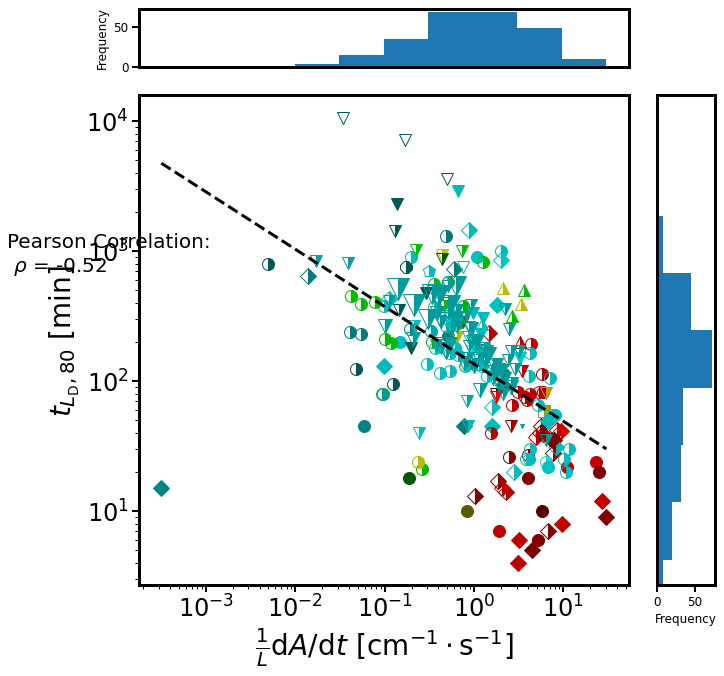

In [45]:
comp_fig = plt.figure(figsize=(8,8))
main_ax = comp_fig.add_axes([0,0,0.85,0.85])


# variable for comparison...

# degradation rate...
# comp_var = 'deg_rate'
# var_label = '$r_\mathrm{deg}\ \mathrm{[mol \cdot m^{-2} \cdot s^{-1}]}$'

# ...or absorbance derivative
comp_var = 'vol_rate'
var_label = '$\\frac{1}{L} \mathrm{d}A/\mathrm{d}t\ [\mathrm{cm}^{-1}\cdot\mathrm{s}^{-1}]$'

comp_var_neg = True # does the comparison variable take on only negative values

if comp_var_neg:
    for ii in range(len(rawdata_df)):
        T = rawdata_df['Temp (deg C)'].iloc[ii]
        RH = rawdata_df['RH (%)'].iloc[ii]
        pct_O2 = rawdata_df['Oxygen (%)'].iloc[ii]
        N_suns_stress = rawdata_df['Illum (Nsuns)'].iloc[ii]
        thick = rawdata_df['Film Thickness [nm]'].iloc[ii]
        encap = 'none'
        color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
        m_size = math.floor(thick/50)*2 + 2
        plt.loglog(np.abs(rawdata_df[comp_var].iloc[ii]),rawdata_df['tLD80 (min)'].iloc[ii],
                   marker=marker,
                   color=color,
                   fillstyle=fill,
                   markersize=m_size
                  )
        if rawdata_df['MA fraction'].iloc[ii] == 0.95:
            plt.loglog(np.abs(rawdata_df[comp_var].iloc[ii]),rawdata_df['tLD80 (min)'].iloc[ii],
                   marker='v',color='xkcd:white',markersize=8) 
        elif rawdata_df['MA fraction'].iloc[ii] == 0.975:
            plt.loglog(np.abs(rawdata_df[comp_var].iloc[ii]),rawdata_df['tLD80 (min)'].iloc[ii],
                   marker='v',color='xkcd:white',markersize=4)
        elif rawdata_df['MA fraction'].iloc[ii] == 1.025:
            plt.loglog(np.abs(rawdata_df[comp_var].iloc[ii]),rawdata_df['tLD80 (min)'].iloc[ii],
                   marker='^',color='xkcd:white',markersize=4)
        elif rawdata_df['MA fraction'].iloc[ii] == 1.05:
            plt.loglog(np.abs(rawdata_df[comp_var].iloc[ii]),rawdata_df['tLD80 (min)'].iloc[ii],
                   marker='^',color='xkcd:white',markersize=8)    
    nas = np.logical_or(np.isnan(np.abs(rawdata_df[comp_var].values)),np.isnan(rawdata_df['tLD80 (min)'].values))
    log_fit = np.polyfit(np.log(np.abs(rawdata_df[comp_var].values)[~nas]),np.log(rawdata_df['tLD80 (min)'].values[~nas]),1)
    bleach_range = np.linspace(np.min(np.abs(rawdata_df[comp_var].values)),np.max(np.abs(rawdata_df[comp_var].values)),num=101)
    main_ax.plot(bleach_range,np.exp((log_fit[1]))*bleach_range**log_fit[0],'k--')

    r,_ = scipy.stats.pearsonr(np.log(np.abs(rawdata_df[comp_var].values[~nas])),np.log(rawdata_df['tLD80 (min)'].values[~nas]))
else:
    for ii in range(len(rawdata_df)):
        T = rawdata_df['Temp (deg C)'].iloc[ii]
        RH = rawdata_df['RH (%)'].iloc[ii]
        pct_O2 = rawdata_df['Oxygen (%)'].iloc[ii]
        N_suns_stress = rawdata_df['Illum (Nsuns)'].iloc[ii]
        thick = rawdata_df['Film Thickness [nm]'].iloc[ii]
        encap = 'none'
        color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
        m_size = math.floor(thick/50)*2 + 2
        plt.loglog(rawdata_df[comp_var].iloc[ii],rawdata_df['tLD80 (min)'].iloc[ii],
                   marker=marker,
                   color=color,
                   fillstyle=fill,markersize=m_size
                  )
        if rawdata_df['MA fraction'].iloc[ii] == 0.95:
            plt.loglog(rawdata_df[comp_var].iloc[ii],rawdata_df['tLD80 (min)'].iloc[ii],
                   marker='v',color='xkcd:white',markersize=8) 
        elif rawdata_df['MA fraction'].iloc[ii] == 0.975:
            plt.loglog(rawdata_df[comp_var].iloc[ii],rawdata_df['tLD80 (min)'].iloc[ii],
                   marker='v',color='xkcd:white',markersize=4)
        elif rawdata_df['MA fraction'].iloc[ii] == 1.025:
            plt.loglog(rawdata_df[comp_var].iloc[ii],rawdata_df['tLD80 (min)'].iloc[ii],
                   marker='^',color='xkcd:white',markersize=4)
        elif rawdata_df['MA fraction'].iloc[ii] == 1.05:
            plt.loglog(rawdata_df[comp_var].iloc[ii],rawdata_df['tLD80 (min)'].iloc[ii],
                   marker='^',color='xkcd:white',markersize=8)


    nas = np.logical_or(np.isnan(rawdata_df[comp_var].values),np.isnan(rawdata_df['tLD80 (min)'].values))
    log_fit = np.polyfit(np.log(rawdata_df[comp_var].values[~nas]),np.log(rawdata_df['tLD80 (min)'].values[~nas]),1)
    bleach_range = np.linspace(np.min(rawdata_df[comp_var].values),np.max(rawdata_df[comp_var].values),num=101)
    main_ax.plot(bleach_range,np.exp((log_fit[1]))*bleach_range**log_fit[0],'k--')

    r,_ = scipy.stats.pearsonr(np.log(rawdata_df[comp_var].values[~nas]),np.log(rawdata_df['tLD80 (min)'].values[~nas]))
main_ax.text(6e-6,700,'Pearson Correlation: \n $\\rho$ = ' + str(np.round(r,4)),fontsize=20)

main_ax.set_xlabel(var_label)
main_ax.set_ylabel('$t_{L_\mathrm{D},80}$ [min]')

#main_ax.set_ylim([70,1.1e3])

main_ax.set_xscale('log')
main_ax.set_yscale('log')

#Tr_ax_lims = np.array([0.000009,.011])
log_top_ax_lims = np.log10(np.array(main_ax.get_xlim()))

log_right_ax_lims = np.log10(np.array(main_ax.get_ylim()))

right_ax = comp_fig.add_axes([0.9,0,0.1,0.85])
right_ax.hist(np.log10(rawdata_df['tLD80 corrected (min)']),orientation=u'horizontal',bins=10)
right_ax.set_ylim(log_right_ax_lims)
#LD80_ax.set_xlim([0,20])
right_ax.set_yticks([])
right_ax.set_xlabel('Frequency',fontsize=12)
right_ax.tick_params(axis='x', labelsize=12)


top_ax = comp_fig.add_axes([0,0.9,0.85,0.1])
if comp_var_neg:
    top_ax.hist(np.log10(np.abs(rawdata_df[comp_var])),bins=10)
else:
    top_ax.hist(np.log10(rawdata_df[comp_var]),bins=10)
top_ax.set_xlim(log_top_ax_lims)
top_ax.set_xticks([])
top_ax.set_ylabel('Frequency',fontsize=12)
top_ax.tick_params(axis='y', labelsize=12)

print(log_fit)

KeyError: 'HBQ11'

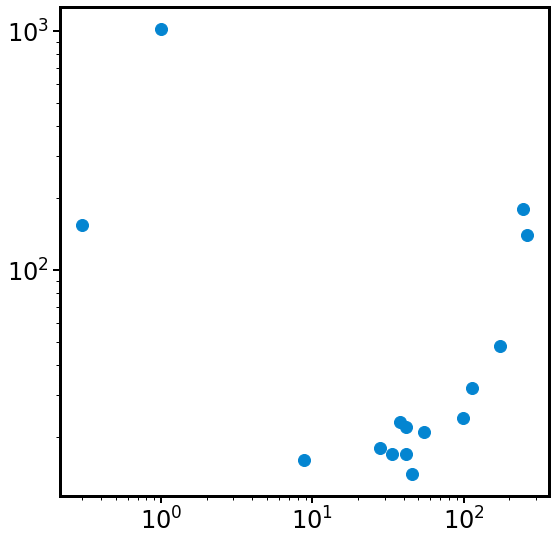

In [46]:
comp_fig = plt.figure(figsize=(8,8))
main_ax = comp_fig.add_axes([0,0,0.85,0.85])


# variable for comparison...

# degradation rate...
# comp_var = 'deg_rate'
# var_label = '$r_\mathrm{deg}\ \mathrm{[mol \cdot m^{-2} \cdot s^{-1}]}$'

# ...or absorbance derivative
comp_var = 'vol_rate'
var_label = '$\\frac{1}{L} \mathrm{d}A/\mathrm{d}t\ [\mathrm{min}^{-1}]$'

# comp_var = 'dAdt'
# var_label = '$\mathrm{d}A/\mathrm{d}t$'

comp_var = 'tLD80 corrected (min)'
var_label = '$t_{L_\mathrm{D},80}$'

comp_var_neg = True # does the comparison variable take on only negative values

if comp_var_neg:
    for ii in range(len(rawdata_df)):
        thick = rawdata_df['Film Thickness [nm]'].iloc[ii]
        encap = 'none'
        m_size = math.floor(thick/50)*2 + 2
        plt.loglog(np.abs(rawdata_df[comp_var].iloc[ii]),rawdata_df['tA80'].iloc[ii],
                   marker=batch_markers[rawdata_df['BatchID'].iloc[ii]],color=batch_colors[rawdata_df['BatchID'].iloc[ii]],
                   markersize=m_size
                  )
        if rawdata_df['MA fraction'].iloc[ii] == 0.95:
            plt.loglog(np.abs(rawdata_df[comp_var].iloc[ii]),rawdata_df['tA80'].iloc[ii],
                   marker='v',color='xkcd:white',markersize=8) 
        elif rawdata_df['MA fraction'].iloc[ii] == 0.975:
            plt.loglog(np.abs(rawdata_df[comp_var].iloc[ii]),rawdata_df['tA80'].iloc[ii],
                   marker='v',color='xkcd:white',markersize=4)
        elif rawdata_df['MA fraction'].iloc[ii] == 1.025:
            plt.loglog(np.abs(rawdata_df[comp_var].iloc[ii]),rawdata_df['tA80'].iloc[ii],
                   marker='^',color='xkcd:white',markersize=4)
        elif rawdata_df['MA fraction'].iloc[ii] == 1.05:
            plt.loglog(np.abs(rawdata_df[comp_var].iloc[ii]),rawdata_df['tA80'].iloc[ii],
                   marker='^',color='xkcd:white',markersize=8)    
    nas = np.logical_or(np.isnan(np.abs(rawdata_df[comp_var].values)),np.isnan(rawdata_df['tA80'].values))
    log_fit = np.polyfit(np.log(np.abs(rawdata_df[comp_var].values)[~nas]),np.log(rawdata_df['tA80'].values[~nas]),1)
    bleach_range = np.linspace(np.min(np.abs(rawdata_df[comp_var].values)),np.max(np.abs(rawdata_df[comp_var].values)),num=101)
    main_ax.plot(bleach_range,np.exp((log_fit[1]))*bleach_range**log_fit[0],'k--')

    r,_ = scipy.stats.pearsonr(np.log(np.abs(rawdata_df[comp_var].values[~nas])),np.log(rawdata_df['tA80'].values[~nas]))
else:
    for ii in range(len(rawdata_df)):
        thick = rawdata_df['Film Thickness [nm]'].iloc[ii]
        encap = 'none'
        m_size = math.floor(thick/50)*2 + 2
        plt.loglog(rawdata_df[comp_var].iloc[ii],rawdata_df['tA80'].iloc[ii],
                   marker=batch_markers[rawdata_df['BatchID'].iloc[ii]],color=batch_colors[rawdata_df['BatchID'].iloc[ii]],
                   markersize=m_size
                  )
        if rawdata_df['MA fraction'].iloc[ii] == 0.95:
            plt.loglog(rawdata_df[comp_var].iloc[ii],rawdata_df['tA80'].iloc[ii],
                   marker='v',color='xkcd:white',markersize=8) 
        elif rawdata_df['MA fraction'].iloc[ii] == 0.975:
            plt.loglog(rawdata_df[comp_var].iloc[ii],rawdata_df['tA80'].iloc[ii],
                   marker='v',color='xkcd:white',markersize=4)
        elif rawdata_df['MA fraction'].iloc[ii] == 1.025:
            plt.loglog(rawdata_df[comp_var].iloc[ii],rawdata_df['tA80'].iloc[ii],
                   marker='^',color='xkcd:white',markersize=4)
        elif rawdata_df['MA fraction'].iloc[ii] == 1.05:
            plt.loglog(rawdata_df[comp_var].iloc[ii],rawdata_df['tA80'].iloc[ii],
                   marker='^',color='xkcd:white',markersize=8)


    nas = np.logical_or(np.isnan(rawdata_df[comp_var].values),np.isnan(rawdata_df['tA80'].values))
    log_fit = np.polyfit(np.log(rawdata_df[comp_var].values[~nas]),np.log(rawdata_df['tA80'].values[~nas]),1)
    bleach_range = np.linspace(np.min(rawdata_df[comp_var].values),np.max(rawdata_df[comp_var].values),num=101)
    main_ax.plot(bleach_range,np.exp((log_fit[1]))*bleach_range**log_fit[0],'k--')

    r,_ = scipy.stats.pearsonr(np.log(rawdata_df[comp_var].values[~nas]),np.log(rawdata_df['tA80'].values[~nas]))
#main_ax.text(2e-1,700,'Pearson Correlation: \n $\\rho$ = ' + str(np.round(r,4)),fontsize=20)
main_ax.text(1e-5,700,'Pearson Correlation: \n $\\rho$ = ' + str(np.round(r,4)),fontsize=20)


main_ax.set_xlabel(var_label)
main_ax.set_ylabel('$t_{A,80}$ [min]')

#main_ax.set_ylim([70,1.1e3])

main_ax.set_xscale('log')
main_ax.set_yscale('log')

#Tr_ax_lims = np.array([0.000009,.011])
log_top_ax_lims = np.log10(np.array(main_ax.get_xlim()))

log_right_ax_lims = np.log10(np.array(main_ax.get_ylim()))

right_ax = comp_fig.add_axes([0.9,0,0.1,0.85])
right_ax.hist(np.log10(rawdata_df['tA80']),orientation=u'horizontal',bins=10)
right_ax.set_ylim(log_right_ax_lims)
#LD80_ax.set_xlim([0,20])
right_ax.set_yticks([])
right_ax.set_xlabel('Frequency',fontsize=12)
right_ax.tick_params(axis='x', labelsize=12)


top_ax = comp_fig.add_axes([0,0.9,0.85,0.1])
if comp_var_neg:
    top_ax.hist(np.log10(np.abs(rawdata_df[comp_var])),bins=10)
else:
    top_ax.hist(np.log10(rawdata_df[comp_var]),bins=10)
top_ax.set_xlim(log_top_ax_lims)
top_ax.set_xticks([])
top_ax.set_ylabel('Frequency',fontsize=12)
top_ax.tick_params(axis='y', labelsize=12)

In [ ]:


Tr_LD80_fig = plt.figure(figsize=(8,8))
main_ax = Tr_LD80_fig.add_axes([0,0,0.85,0.85])
#main_ax.fill([Tr_ax_lims[0],1,1,Tr_ax_lims[0],Tr_ax_lims[0]],[1,1,LD80_ax_lims[1],LD80_ax_lims[1],1],color=(0.5,0,0,0.1))
#main_ax.fill([Tr_ax_lims[0],1,1,Tr_ax_lims[0],Tr_ax_lims[0]],[LD80_ax_lims[0],LD80_ax_lims[0],1,1,tau_ax_lims[0]],color=(0.5,0,0.5,0.1))
#main_ax.fill([1,mu_ax_lims[1],mu_ax_lims[1],1,1],[tau_ax_lims[0],tau_ax_lims[0],1,1,tau_ax_lims[0]],color=(0,0,0.5,0.1))
#main_ax.hlines(1,*Tr_ax_lims) 
#main_ax.vlines(1,*LD80_ax_lims)
#mu_range = np.linspace(1e-2,2e0,num=101)
#main_ax.plot(mu_range,0.8**2/mu_range,'k--')
#main_ax.set_xlim(Tr_ax_lims)
#main_ax.set_ylim(LD80_ax_lims)
main_ax.set_xlabel('$t_{L_\mathrm{D},max}$ [min]')
main_ax.set_ylabel('$t_{L_\mathrm{D},80}$ [min]')


for ii in range(len(rawdata_df)):
    T = rawdata_df['Temp (deg C)'].iloc[ii]
    RH = rawdata_df['RH (%)'].iloc[ii]
    pct_O2 = rawdata_df['Oxygen (%)'].iloc[ii]
    N_suns_stress = rawdata_df['Illum (Nsuns)'].iloc[ii]
    encap = 'none'
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    main_ax.plot(rawdata_df['tLDmax'].iloc[ii],rawdata_df['tLD80 corrected (min)'].iloc[ii],marker='o',color=batch_colors[rawdata_df['BatchID'].iloc[ii]])
    

#Tr_ax_lims = np.array([0.000009,.011])
log_Tr_ax_lims = np.array(main_ax.get_xlim())

LD80_ax_lims = np.array([9,1300])
log_LD80_ax_lims = np.array(main_ax.get_ylim())

LD80_ax = Tr_LD80_fig.add_axes([0.9,0,0.1,0.85])
LD80_ax.hist(rawdata_df['tLDmax'],orientation=u'horizontal',bins=10)
LD80_ax.set_ylim(log_LD80_ax_lims)
#LD80_ax.set_xlim([0,20])
LD80_ax.set_yticks([])
LD80_ax.set_xlabel('Frequency',fontsize=12)
LD80_ax.tick_params(axis='x', labelsize=12)


Tr_ax = Tr_LD80_fig.add_axes([0,0.9,0.85,0.1])
Tr_ax.hist(rawdata_df['Bleach Rate (polyfit) (1/min)'],bins=10)
Tr_ax.set_xlim(log_Tr_ax_lims)
Tr_ax.set_xticks([])
Tr_ax.set_ylabel('Frequency',fontsize=12)
Tr_ax.tick_params(axis='y', labelsize=12)


nas = np.logical_or(np.isnan(rawdata_df['tLDmax'].values),np.isnan(rawdata_df['tLD80 corrected (min)'].values))
log_fit = np.polyfit(rawdata_df['tLDmax'].values[~nas],rawdata_df['tLD80 corrected (min)'].values[~nas],1)
bleach_range = np.linspace(np.min(rawdata_df['tLDmax']),np.max(rawdata_df['tLDmax']),num=101)
main_ax.plot(bleach_range,log_fit[1] + bleach_range*(log_fit[0]),'k--')

r,_ = scipy.stats.pearsonr(rawdata_df['tLDmax'].values[~nas],rawdata_df['tLD80 corrected (min)'].values[~nas])
main_ax.text(50,350,'Pearson Correlation: \n $\\rho$ = ' + str(np.round(r,4)),fontsize=20)

len(rawdata_df['tLDmax'].values[~nas])

lnLD80           1.000000
lntPLmax         0.928334
lntLDmax         0.851313
|dAdt|           0.534238
ddA0             0.345810
PLQY_0           0.225783
dPLdt (1/min)    0.190470
ddPL0            0.083228
Name: lnLD80, dtype: float64


C:\Users\Wiley\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


lnLD80             1.000000
lntPLmax           0.928334
lntLDmax           0.851313
ln|dAdt|           0.602315
lndPLdt (1/min)    0.391146
lnPLQY_0           0.282229
lnddPL0            0.079580
lnddA0             0.071344
Name: lnLD80, dtype: float64


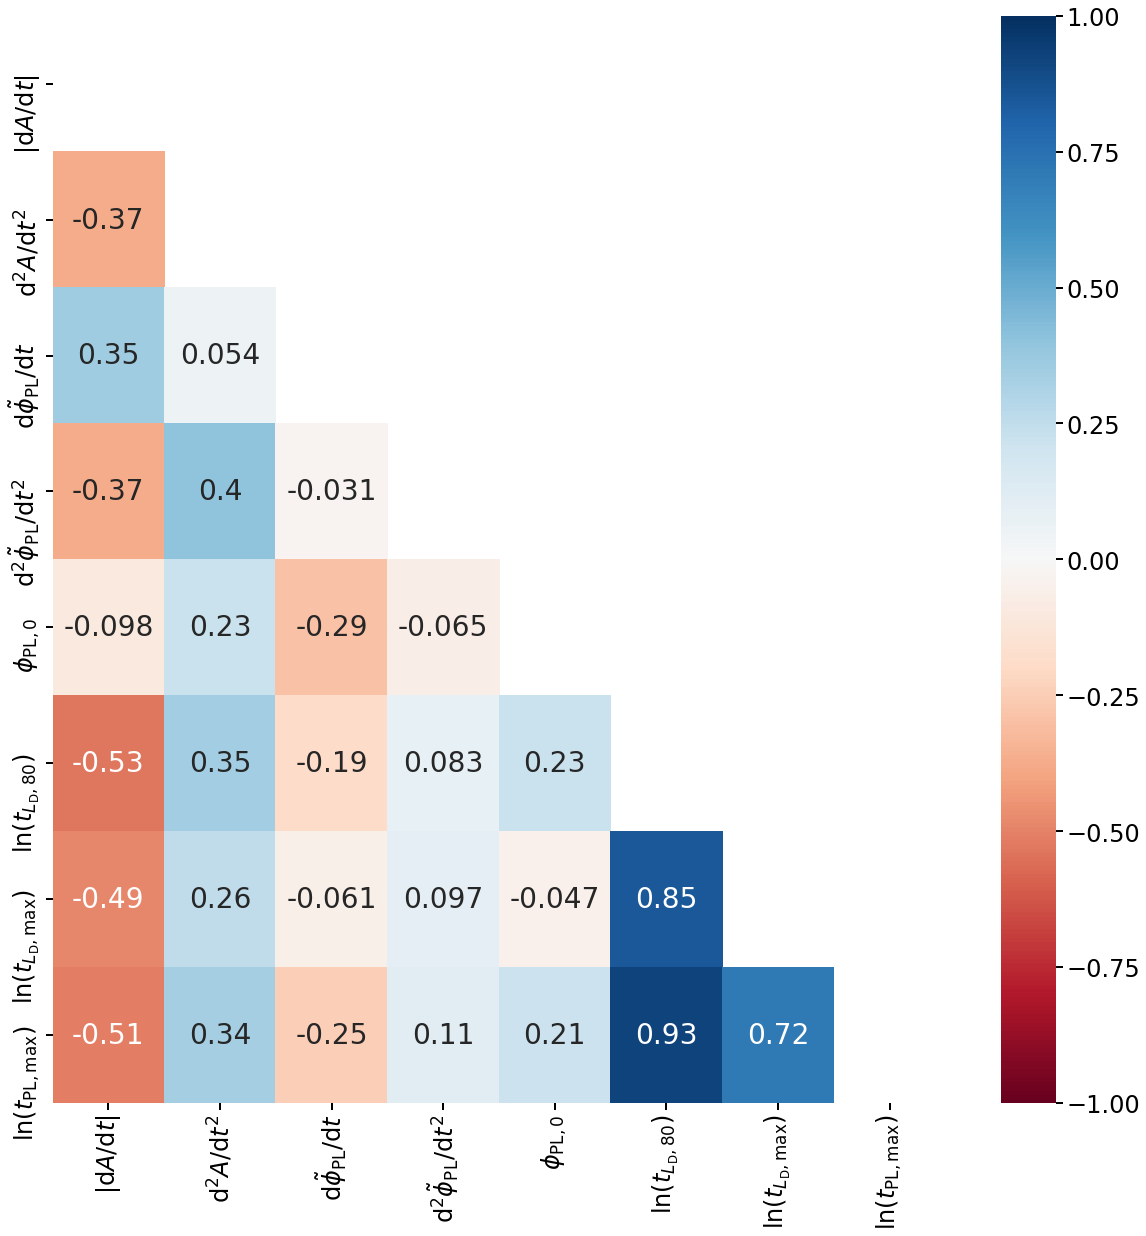

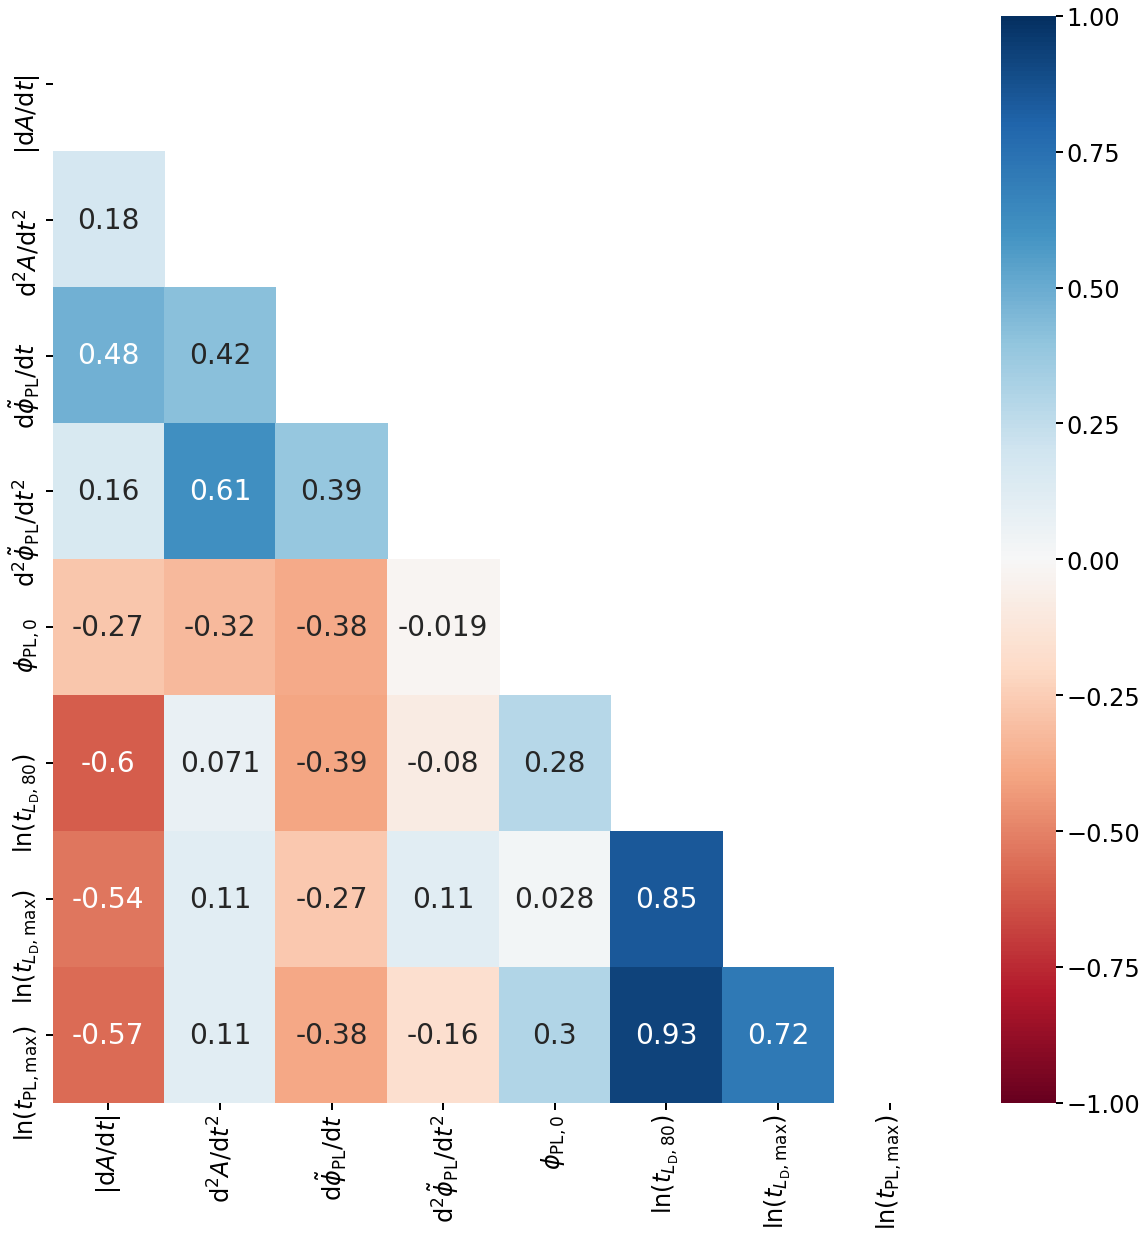

In [248]:
# first make a correlation heat map of linear features

columns_to_analyze = [#'Bleach Rate (polyfit) (1/min)',
                    '|dAdt|',
                      'ddA0',
                      #'Bleach Rate (fit to 5% inc) (1/min)',
                      #'dLDdt (1/min)',
                      'dPLdt (1/min)',
                      'ddPL0',
                      #'ddLD0',

#                      'dtaudt',
                      #'dmudt',
                      #'ddmu0',
#                      'ddtau0',
                      #'LD_0 (nm)',
                      'PLQY_0',
#                      'deg_rate',
#                       'xy1t0_0',
#                       'xy0t1_0',
#                       'xy0t1Norm_0',
#                       'xy1t1_0',
#                       't0xy1_0',
#                       't1xy0_0',
#                       'xy2t0',
#                       'xy3t0',
#                       'xy2t1',
#                       'xy3t1',
#                       'frac_bright_0',
#                       'beta_mean',
#                       'beta_std',
#                       'cv_slopes',
                     ]
                      #'tau0',
                      #'mu0',]
'''                      

                      'Days Stored',
                      'dDFmeandt',
                      'dDFmediandt',
                      'dDFstddt',
                      'dDFskewdt',
                      'dDFkurtdt',
                      'd2DFmeandt2',
                      'd2DFmediandt2',
                      'd2DFstddt2',
                      'd2DFskewdt2',
                      'd2DFkurtdt2',
                      'DFmean_0',
                      'DFmedian_0',
                      'DFstd_0',
                      'DFskew_0',
                      'DFkurtdt_0',
                      ###### - response(s)
                      #'tLD80 corrected (min)'
                     ]'''

labels = [#'$\mathrm{d}\mathcal{T}/\mathrm{d}t$',
            '$|\mathrm{d}A/\mathrm{d}t|$',
              '$\mathrm{d}^2 A/\mathrm{d}t^2$',
          #'$\mathrm{d}\\tilde{L}_\mathrm{D}/\mathrm{d}t$',
          '$\mathrm{d}\\tilde{\phi}_\mathrm{PL}/\mathrm{d}t$',
          '$\mathrm{d}^2\\tilde{\phi}_\mathrm{PL}/\mathrm{d}t^2$',
          #'$\mathrm{d}^2\\tilde{L}_\mathrm{D}/\mathrm{d}t^2$',
          #'$\mathrm{d}^2\mathcal{T}/\mathrm{d}t^2$',

          #'$\mathrm{d}\\tau/\mathrm{d}t$',
          #'$\mathrm{d}\mu/\mathrm{d}t$',
          #'$\mathrm{d}^2\mu/\mathrm{d}t^2$',  
          #'$\mathrm{d}^2\\tau/\mathrm{d}t^2$',
          #'$L_\mathrm{D,0}$',
          '$\phi_\mathrm{PL,0}$',
#          '$r$',
#         '$\sigma_{xy}(\left<\phi_\mathrm{PL}\\right>_t)$',
#           '$\left<\sigma_t(\phi_\mathrm{PL}\\right>_{xy}$',
#           '$\left<\sigma_t(\phi_\mathrm{PL}\\right>_{xy,\mathrm{Norm}}$',
#           '$\sigma_{xy}(\sigma_{t}(\phi_\mathrm{PL}))$',
#           '$\left<\sigma_{xy}(\phi_\mathrm{PL}\\right>_{t}$',
#           '$\sigma_{t}(\left<\phi_\mathrm{PL}\\right>_{xy})$',
#           '$\mathrm{skew}_{xy}(\left<\phi_\mathrm{PL}\\right>_t)$',
#           '$\mathrm{kurt}_{xy}(\left<\phi_\mathrm{PL}\\right>_t)$',
#           '$\mathrm{skew}_{xy}(\sigma_t(\phi_\mathrm{PL}))$',
#           '$\mathrm{kurt}_{xy}(\sigma_t(\phi_\mathrm{PL}))$',
#           '$f_\mathrm{PB}$',
#           '$\left< \\beta \\right> $',
#           '$\sigma_{xy}(\\beta)$',
#           'cv_slopes',
         '$\mathrm{ln} \left( t_{L_\mathrm{D},80} \\right)$',
          '$\mathrm{ln} \left( t_{L\mathrm{_D,max}} \\right)$',
          '$\mathrm{ln} \left( t_\mathrm{PL,max} \\right)$',
          ]
'''          '$\\tau_0$',
          '$\mu_0$',
          '$L_\mathrm{D,0}$',
          '$\phi_\mathrm{PL,0}$',
          '$\sigma_{xy}(\left<\phi_\mathrm{PL}\\right>_t)$',
          '$\left<\sigma_t(\phi_\mathrm{PL}\\right>_{xy}$',
          '$\left<\sigma_t(\phi_\mathrm{PL}\\right>_{xy,\mathrm{Norm}}$',
          '$\sigma_{xy}(\sigma_{t}(\phi_\mathrm{PL}))$',
          '$\left<\sigma_{xy}(\phi_\mathrm{PL}\\right>_{t}$',
          '$\sigma_{t}(\left<\phi_\mathrm{PL}\\right>_{xy})$',
          '$\mathrm{skew}_{xy}(\left<\phi_\mathrm{PL}\\right>_t)$',
          '$\mathrm{kurt}_{xy}(\left<\phi_\mathrm{PL}\\right>_t)$',
          '$\mathrm{skew}_{xy}(\sigma_t(\phi_\mathrm{PL}))$',
          '$\mathrm{kurt}_{xy}(\sigma_t(\phi_\mathrm{PL}))$',
          '$f_\mathrm{PB}$',
          '$\left< \\beta \\right> $',
          '$\sigma_{xy}(\\beta)$',
          'cv_slopes',
          '$t_\mathrm{store}$',
          '$\mathrm{d}\mu_\mathrm{DF}/\mathrm{d}t$',
          '$\mathrm{d}m_\mathrm{DF}/\mathrm{d}t$',
          '$\mathrm{d}\sigma_\mathrm{DF}/\mathrm{d}t$',
          '$\mathrm{d}\Sigma_\mathrm{DF}/\mathrm{d}t$',
          '$\mathrm{d}\kappa_\mathrm{DF}/\mathrm{d}t$',
          '$\mathrm{d}^2\mu_\mathrm{DF}/\mathrm{d}t^2$',
          '$\mathrm{d}^2m_\mathrm{DF}/\mathrm{d}t^2$',
          '$\mathrm{d}^2\sigma_\mathrm{DF}/\mathrm{d}t^2$',
          '$\mathrm{d}^2\Sigma_\mathrm{DF}/\mathrm{d}t^2$',
          '$\mathrm{d}^2\kappa_\mathrm{DF}/\mathrm{d}t^2$',
          '$\mu_\mathrm{DF,0}$',
          '$m_\mathrm{DF,0}$',
          '$\sigma_\mathrm{DF,0}$',
          '$\Sigma_\mathrm{DF,0}$',
          '$\kappa_\mathrm{DF,0}$',
          ###### - responses
          '$\mathrm{ln} \left( t_{L_\mathrm{D},80} \\right)$',

         ]'''

rawdata_df_reduced = rawdata_df.copy()[columns_to_analyze]
rawdata_df_reduced['lnLD80'] = np.log(rawdata_df['tLD80 corrected (min)'])
rawdata_df_reduced['lntLDmax'] = np.log(rawdata_df['tLDmax'])
rawdata_df_reduced['lntPLmax'] = np.log(rawdata_df['tPLmax'])

plt.figure(figsize=(20,20))
corr_Matrix = rawdata_df_reduced.corr()

# mask off the matrix above the diagonal
mask = np.zeros_like(corr_Matrix)
mask[np.triu_indices_from(mask)] = True

sn.heatmap(corr_Matrix,
           annot = True,
           xticklabels = labels,
           yticklabels = labels,
           cmap = 'RdBu', vmin=-1, vmax=1,
           mask=mask
          )

LD80_corrs = corr_Matrix['lnLD80'].copy()
print(LD80_corrs.map(lambda x : x).abs().sort_values(ascending = False))

# now make a heatmap of the logarithmic features

rawdata_df_log = pd.DataFrame()

for feature in columns_to_analyze:
    rawdata_df_log['ln' + feature] = np.log(rawdata_df_reduced[feature])

rawdata_df_log['lnLD80'] = np.log(rawdata_df['tLD80 corrected (min)'])
rawdata_df_log['lntLDmax'] = np.log(rawdata_df['tLDmax'])
rawdata_df_log['lntPLmax'] = np.log(rawdata_df['tPLmax'])

plt.figure(figsize=(20,20))
corr_log_Matrix = rawdata_df_log.corr()

# mask off the matrix above the diagonal
mask = np.zeros_like(corr_log_Matrix)
mask[np.triu_indices_from(mask)] = True

sn.heatmap(corr_log_Matrix,
           annot = True,
           xticklabels = labels,
           yticklabels = labels,
           cmap = 'RdBu', vmin=-1, vmax=1,
           mask=mask
          )

LD80_corrs_log = corr_log_Matrix['lnLD80'].copy()
print(LD80_corrs_log.map(lambda x : x).abs().sort_values(ascending = False))

(0.0, 20.0)

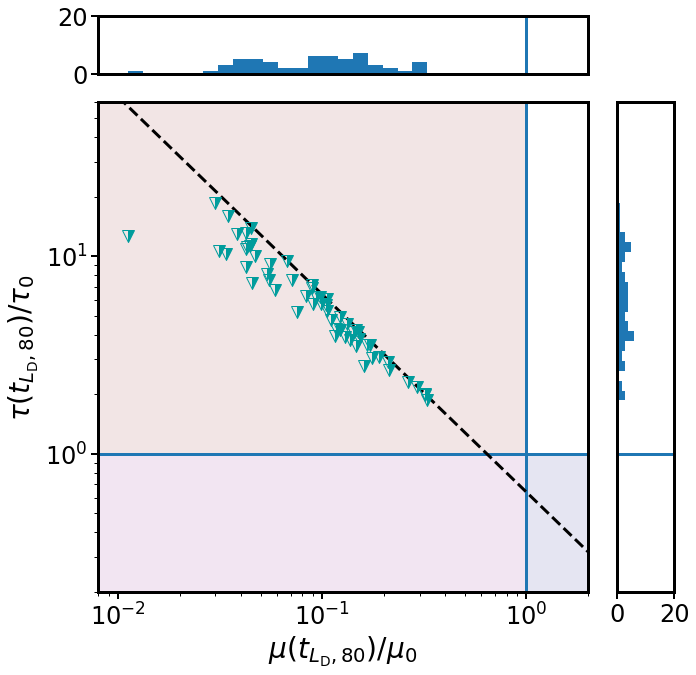

In [106]:
mu_ax_lims = np.array([8e-3,2e0])
log_mu_ax_lims = np.log10(mu_ax_lims)

tau_ax_lims = np.array([2e-1,6e1])
log_tau_ax_lims = np.log10(tau_ax_lims)

mu_tau_fig = plt.figure(figsize=(8,8))
main_ax = mu_tau_fig.add_axes([0,0,0.85,0.85])
main_ax.fill([mu_ax_lims[0],1,1,mu_ax_lims[0],mu_ax_lims[0]],[1,1,tau_ax_lims[1],tau_ax_lims[1],1],color=(0.5,0,0,0.1))
main_ax.fill([mu_ax_lims[0],1,1,mu_ax_lims[0],mu_ax_lims[0]],[tau_ax_lims[0],tau_ax_lims[0],1,1,tau_ax_lims[0]],color=(0.5,0,0.5,0.1))
main_ax.fill([1,mu_ax_lims[1],mu_ax_lims[1],1,1],[tau_ax_lims[0],tau_ax_lims[0],1,1,tau_ax_lims[0]],color=(0,0,0.5,0.1))
main_ax.hlines(1,8e-3,2e0) 
main_ax.vlines(1,2e-1,6e1)
mu_range = np.linspace(1e-2,2e0,num=101)
main_ax.plot(mu_range,0.8**2/mu_range,'k--')
main_ax.set_xlim(mu_ax_lims)
main_ax.set_ylim(tau_ax_lims)
main_ax.set_xlabel('$\mu(t_{L_\mathrm{D},80})/\mu_0$')
main_ax.set_ylabel('$\\tau(t_{L_\mathrm{D},80})/\\tau_0$')


for ii in range(len(rawdata_df)):
    T = rawdata_df['Temp (deg C)'].iloc[ii]
    RH = rawdata_df['RH (%)'].iloc[ii]
    pct_O2 = rawdata_df['Oxygen (%)'].iloc[ii]
    N_suns_stress = rawdata_df['Illum (Nsuns)'].iloc[ii]
    encap = 'none'
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    main_ax.loglog(rawdata_df['mu_LD80'].iloc[ii],rawdata_df['tau_LD80'].iloc[ii],color=color,fillstyle=fill,marker=marker,linestyle=style)

main_ax.set_xscale('log')
main_ax.set_yscale('log')




tau_ax = mu_tau_fig.add_axes([0.9,0,0.1,0.85])
tau_ax.hist(np.log10(rawdata_df['tau_LD80']),orientation=u'horizontal',bins=20)
tau_ax.set_ylim(log_tau_ax_lims)
tau_ax.set_xlim([0,20])
tau_ax.set_yticks([])
tau_ax.hlines(0,0,20)
#tau_ax.set_title('Carrier Lifetime Change at $t_{L_\mathrm{D},80}$',fontsize=12,loc='left')

mu_ax = mu_tau_fig.add_axes([0,0.9,0.85,0.1])
mu_ax.hist(np.log10(rawdata_df['mu_LD80']),bins=20)
mu_ax.set_xlim(log_mu_ax_lims)
mu_ax.set_xticks([])
mu_ax.vlines(0,0,20)
mu_ax.set_ylim([0,20])
#mu_ax.set_title('Carrier Mobility Change at $t_{L_\mathrm{D},80}$',fontsize=12)


# 5. Feature Pre-Selection

In this cell, set up the machine learning task by deciding which of the above attributes to use as the response (i.e., variable to predict) and which to use as the features and which to ignore. It is also possible to construct interaction-related features, such as those between environment and composition.

In [6]:
# change to True if using a log transform on the response
Log_transform = True
# change to True if recalculating coefficients after regularization
unshrink_coefficients = False

# add log variables
var_list = ['dDFmeandt',
#            'dDFmediandt',
#            'dDFstddt',
#            'dDFskewdt',
#            'dDFkurtdt',
#            'd2DFmeandt2',
#            'd2DFmediandt2',
#            'd2DFstddt2',
#            'd2DFskewdt2',
#            'd2DFkurtdt2',
#            'DFmean_0',
#            'DFmedian_0',
#            'DFstd_0',
#            'DFskew_0',
#            'DFkurtdt_0',
#            'ddmu0',
#            'dtaudt',
           ]

for var in var_list:
    rawdata_df['ln' + var] = np.log(rawdata_df[var])

rawdata_df['dDFmeandt/thickness'] = rawdata_df['dDFmeandt']/rawdata_df['Film Thickness [nm]']

rawdata_df['d2DFmeandt2/thickness'] = rawdata_df['d2DFmeandt2']/rawdata_df['Film Thickness [nm]']

# choose the feature to use as the response
#response = 'Bleach Rate (fit to 5% inc) (1/min)' 
# response = 'Bleach Rate (polyfit) (1/min)' 
#response = 'tLD80 corrected (min)'
response = 'tLD80 (min)'
response = 'tLD75 (min)'
#response = 'tLDmax'
#response = 'tPLmax'
#response = 'PL0'
#response = 'tA80'

# assign factor labels to each stress
factor_dict = {'A':'Temp (deg C)',
               'B':'RH (%)',
               'C':'Oxygen (%)',
               'D':'Illum (Nsuns)',
               'E':'MA fraction',
               'dTrdt':'Bleach Rate (polyfit) (1/min)',
               'dLDdt':'dLDdt (1/min)',
               'dPLdt':'dPLdt (1/min)',
               'LD0':'LD_0 (nm)',
               'PL0':'PLQY_0'}

factor_dict_inv = {'Temp (deg C)':'A',
                   'RH (%)':'B',
                   'Oxygen (%)':'C',
                   'Illum (Nsuns)':'D',
                   'MA fraction':'E',
                   'Bleach Rate (polyfit) (1/min)':'dTrdt',
                   'dLDdt (1/min)':'dLDdt',
                   'dPLdt (1/min)':'dPLdt',
                   'LD_0 (nm)':'LD0',
                   'PLQY_0':'PL0'}

# choose environment, composition, AND early time features

# PL heterogeneity terms to choose from, if desired:
# spatiotemporal = ['xy1t0_0','xy0t1_0','xy1t1_0','t0xy1_0','t1xy0_0','frac_bright_0']


# Features to use, for historical reasons termed "Ryan features"
Ryan_features = [
                'Film Thickness [nm]',
                 'dTrdt',
                'lndTrdt',
                'ln|dTrdt|',
                 'ddTr0',
                 'dLDdt',
                'dPLdt', # features used in ACSEL paper
                'ddPL0', # features used in ACSEL paper
                 'ddLD0',
                 #'dLDdt','dPLdt', # features used in ACSEL paper
                 #'ddLD0','ddPL0',
#                 'Ld1','Ld2','Ld3','Ld4','Ld5', # features used in ACSEL paper
#                 'Tr1','Tr2','Tr3','Tr4','Tr5', # features used in ACSEL paper
#                 'PL1','PL2','PL3','PL4','PL5',
#             'ln|dAdt|',
#              'dAdt',
#              'ddA0',
#           'ln|meas_rate|',
#            'ln|model_rate|',
#            'vol_rate',
#            'd_vol_rate',
#           'meas_rate',
#           'd_meas_rate',
#                'lnPL80',
                     'dtaudt',
                     'dmudt',
                     'ddmu0',
                     'ddtau0',
#                      'tau0',
#                      'mu0',
                      'LD0',
                       'PL0',
#                      'QFLS_0'
#                      'PL_FWHM (um)'
#                     'xy1t0_0',
#                      'xy0t1_0',
#                      'xy0t1Norm_0',
#                      'xy1t1_0',
#                      't0xy1_0',
#                     't1xy0_0',
#                      'xy2t0',
#                      'xy3t0',
#                      'xy2t1',
#                      'xy3t1',
#                      'frac_bright_0',
#                      'beta_mean',
#                      'beta_std',
#                      'cv_slopes',
#                      'Days Stored',                    
#                     'dDFmeandt',
#                     'dDFmediandt',
#                     'dDFstddt',
#                     'dDFskewdt',
#                     'dDFkurtdt',
#                    'd2DFmeandt2',
#                     'd2DFmediandt2',
#                     'd2DFstddt2',
#                     'd2DFskewdt2',
#                     'd2DFkurtdt2',
#                     'DFmean_0',
#                     'DFmedian_0',
#                     'DFstd_0',
#                     'DFskew_0',
#                     'DFkurtdt_0'

#                     'lndDFmediandt',
#                    'lndDFmeandt',
#                      'dDFstddt',
#                      'dDFskewdt',
#                      'dDFkurtdt',
#                     'lnd2DFmeandt2',
#                     'lnd2DFmediandt2',
#                      'd2DFstddt2',
#                        'lnd2DFstddt2',
#                      'lnd2DFskewdt2',
#                      'lnd2DFkurtdt2',
#                      'lnDFmean_0',
#                      'lnDFmedian_0',
#                      'lnDFstd_0',
#                      'lnDFskew_0',
#                      'lnDFkurtdt_0'
#                       'lnddmu0',
#                       'lndtaudt',
                # features used in ACSEL paper
                  'A','P_O2','P_H2O','D','E',
#                 'A','P_O2','P_H2O','D',# linear environment and composition
#                 'A','P_H2O','D','E', # linear environment and composition
#                 'P_H2O','D','E', # linear environment and composition                 
#                 'PhotoOx_rate','Hydration_rate'] # physics-inspired features
                 'PhotoOx_rate','Hydration_rate','delS_mix',
#                 'PhotoOx_rate','Ox_rate_P','Hydration_rate','delS_mix',]
]
# full dataset: features + response
terms_to_keep = Ryan_features + [response]

# make a copy of the dataframe so that irrelevant responses can be removed
coded_df = rawdata_df.copy()
print('Number of Runs Total:',len(coded_df))

# If what we are trying to predict is a failure time (e.g., tLD75, tPL10, etc.),
# throw out runs that fail before the prediction interval has finished
# or all runs that take 10 min or less
if response[0] == 't':
    coded_df = coded_df[coded_df['pred_horiz']*3.0/4.0 < coded_df[response]]
    #coded_df = coded_df[10 <= coded_df[response]]
print('Number of Runs That Fail After Prediction Horizon:',len(coded_df))

# encode feature names to simplify interaction calculations
coded_df.rename(columns = factor_dict_inv, inplace = True)
# drop responses that we're not interested in
cols_to_drop = diff(list(coded_df.columns),terms_to_keep)
coded_df = coded_df.drop(columns=cols_to_drop)


# drop rows containing NaNs
coded_df = coded_df.dropna(axis=0)
   
# display the modeling-ready dataset head    
coded_df.head()

Number of Runs Total: 249
Number of Runs That Fail After Prediction Horizon: 219


C:\Users\Wiley\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Film Thickness [nm],A,D,E,dTrdt,tLD75 (min),dLDdt,dPLdt,LD0,PL0,...,dmudt,ddmu0,ddtau0,P_H2O,P_O2,PhotoOx_rate,Hydration_rate,delS_mix,lndTrdt,ln|dTrdt|
0,264,65.0,16.0,1.0,0.001699,65.0,0.010610,0.160090,113.682561,0.000446,...,-0.012012,0.045531,-0.025765,1304.224576,21278.25,4.129091e-14,0.002035,0.0,-6.377767,-6.377767
1,264,85.0,32.0,1.0,0.001650,40.0,-0.019268,-0.164830,93.007809,0.000179,...,0.041294,-0.366353,0.212731,1910.546896,21278.25,9.940153e-14,0.001626,0.0,-6.406963,-6.406963
2,264,85.0,32.0,1.0,0.002153,29.0,0.009678,0.126625,108.820394,0.000104,...,-0.018857,0.014733,-0.019759,1247.381858,21278.25,9.940153e-14,0.001062,0.0,-6.140707,-6.140707
3,264,85.0,32.0,1.0,0.002377,44.0,-0.017767,0.161300,103.198333,0.000178,...,-0.097511,-0.004328,-0.009547,1872.651751,21278.25,9.940153e-14,0.001594,0.0,-6.041872,-6.041872
4,264,85.0,32.0,1.0,0.001565,49.0,-0.018229,-0.207889,99.524614,0.000288,...,0.084271,-0.244020,0.141115,783.166331,21278.25,9.940153e-14,0.000667,0.0,-6.460172,-6.460172


In [48]:
pd.set_option('display.max_rows', None)
rawdata_df['Oxygen (%)']


0       21.00
1       21.00
2       21.00
3       21.00
4       21.00
5       21.00
6       21.00
7       21.00
8       21.00
9       21.00
10      21.00
11      21.00
12      21.00
13      21.00
14      21.00
15      21.00
18      21.00
19      21.00
20      21.00
21      21.00
22      21.00
23     100.00
24     100.00
25     100.00
26     100.00
27     100.00
28     100.00
29      21.00
30      21.00
31      21.00
32     100.00
33     100.00
34      21.00
35      21.00
36     100.00
37      21.00
38      21.00
39     100.00
40     100.00
41     100.00
42     100.00
43      21.00
44      21.00
45      21.00
46      21.00
47     100.00
48     100.00
49     100.00
50      21.00
51      21.00
52      21.00
53      21.00
54      21.00
55     100.00
56     100.00
57      21.00
58      21.00
59      21.00
60     100.00
61     100.00
62     100.00
63     100.00
64     100.00
65     100.00
66      21.00
67      21.00
68     100.00
69      21.00
70     100.00
75      21.00
76      21.00
77    

# 6. Modeling

In this cell, the machine learning model is initialized and trained. Error metrics and coefficients are calculated and tabulated for visualization in the cells below.

{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}
For test set:
Mean of Mean Absolute Error = 12.6 %
Median of Mean Absolute Error = 8.9 %
Std. Dev. of Mean Absolute Error = 13.4 %
Mean of Mean Absolute Error = 0.572
Median of Mean Absolute Error = 0.423
Std. Dev. of Mean Absolute Error = 0.556
Mean R2 = nan
Median R2 = nan
Std Dev. R2 = nan
For whole model:
Mean of Mean Absolute Error = 11.0 %
Median of Mean Absolute Error = 11.0 %
Std. Dev. of Mean Absolute Error = 0.1 %
Mean of Mean Absolute Error = 0.509
Median of Mean Absolute Error = 0.509
Std. Dev. of Mean Absolute Error = 0.002
Mean R2 = 0.6931
Median R2 = 0.6934
Std Dev. R2 = 0.0026
Mean Linear Error = 83.7 %
Median Linear Error = 43.2 %
Index of Median Model: 43


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


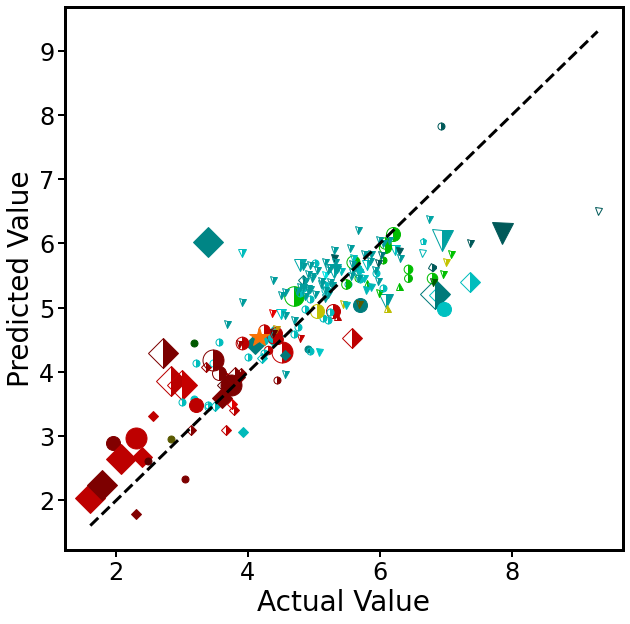

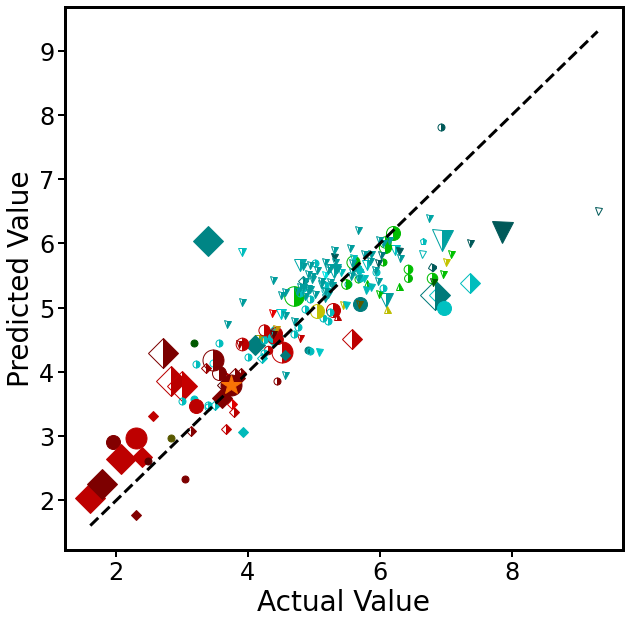

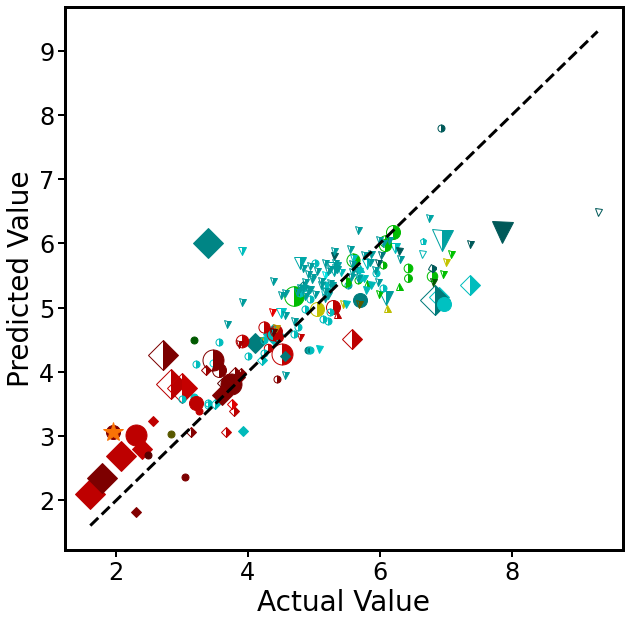

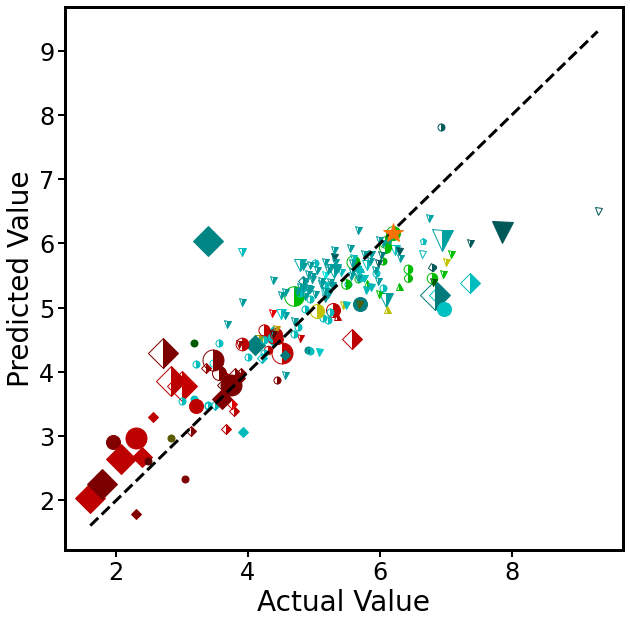

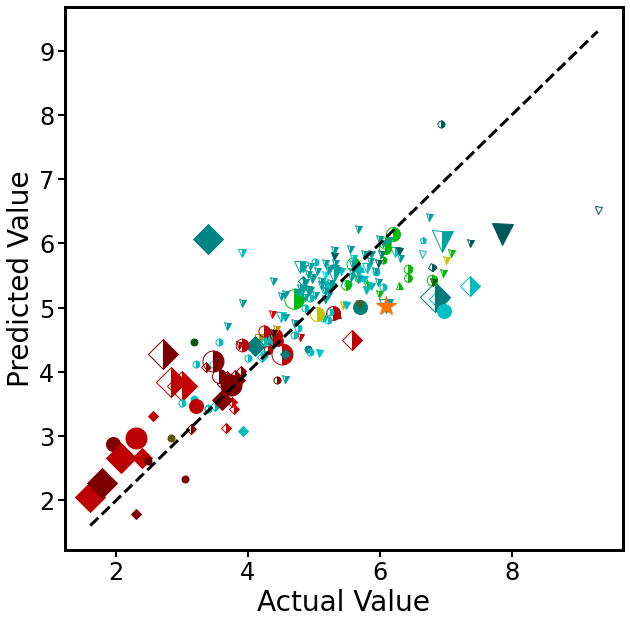

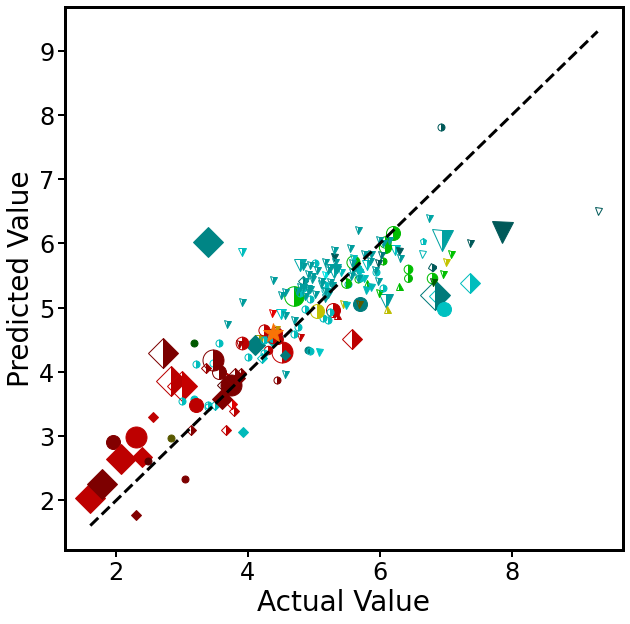

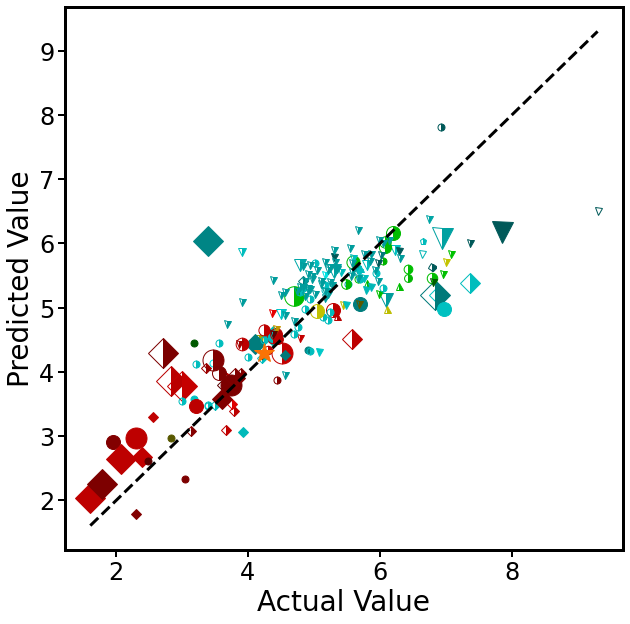

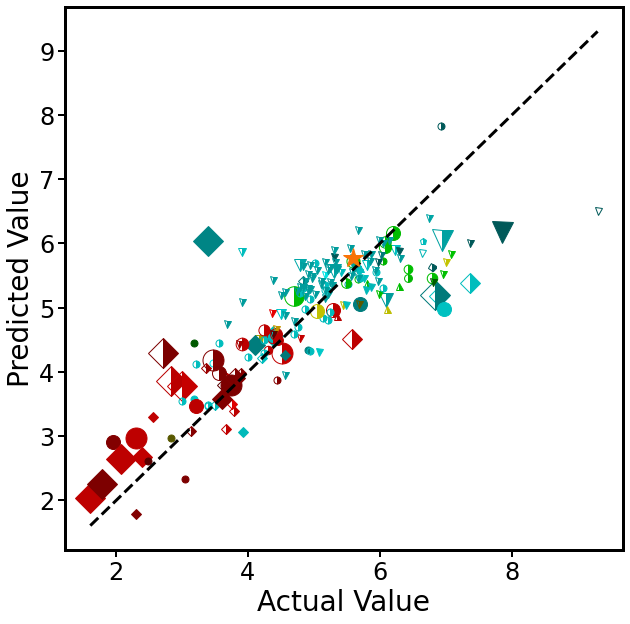

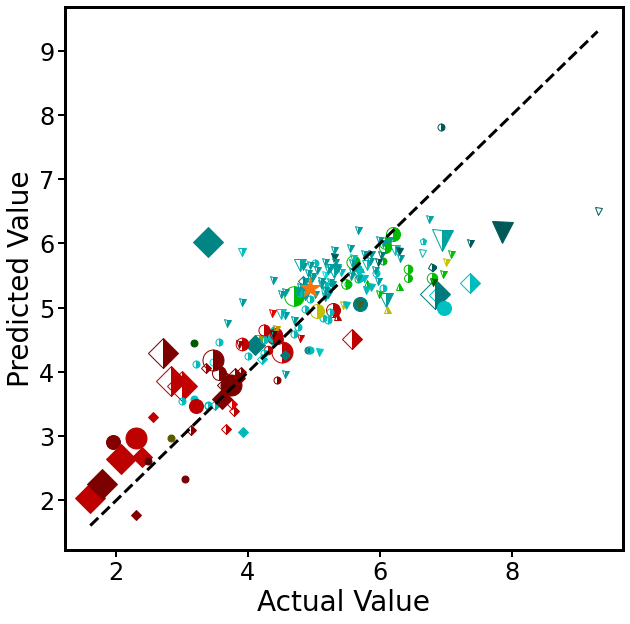

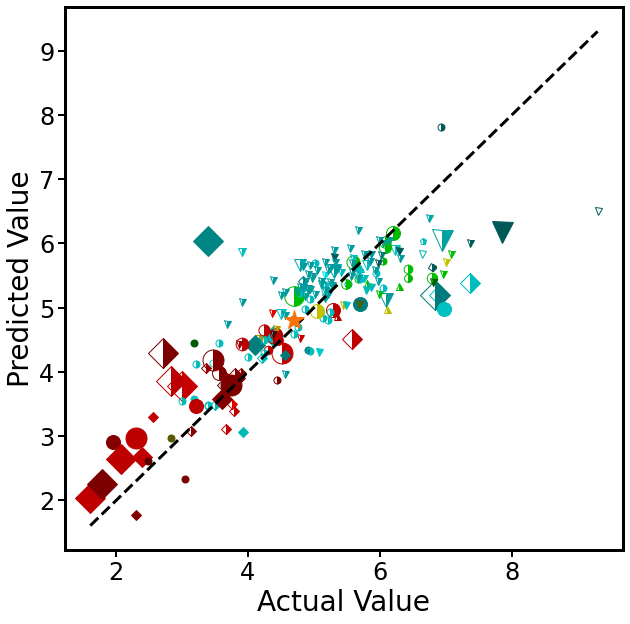

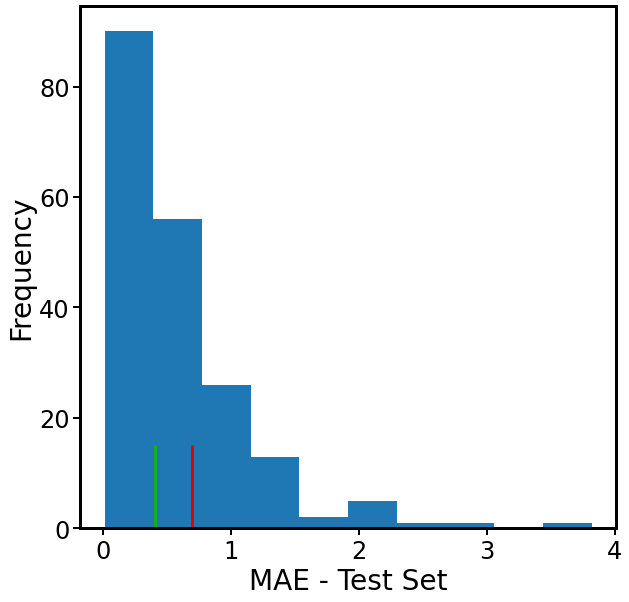

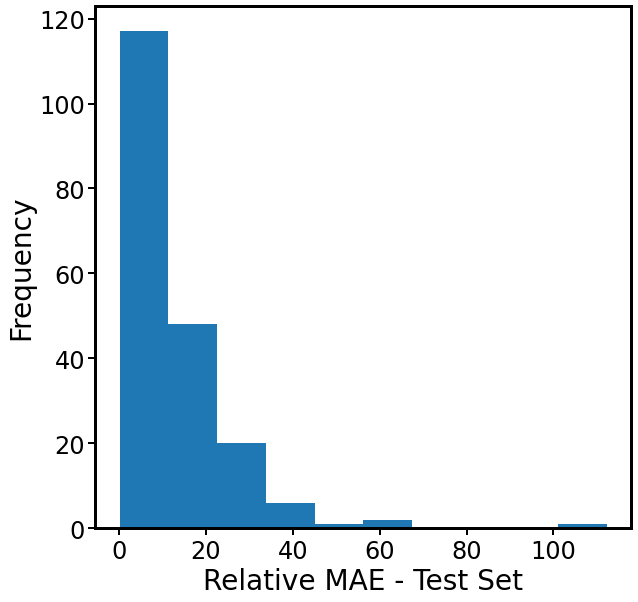

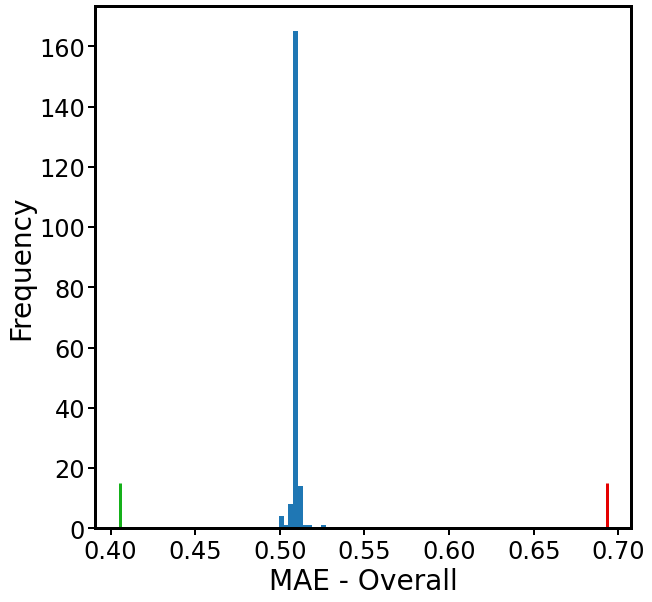

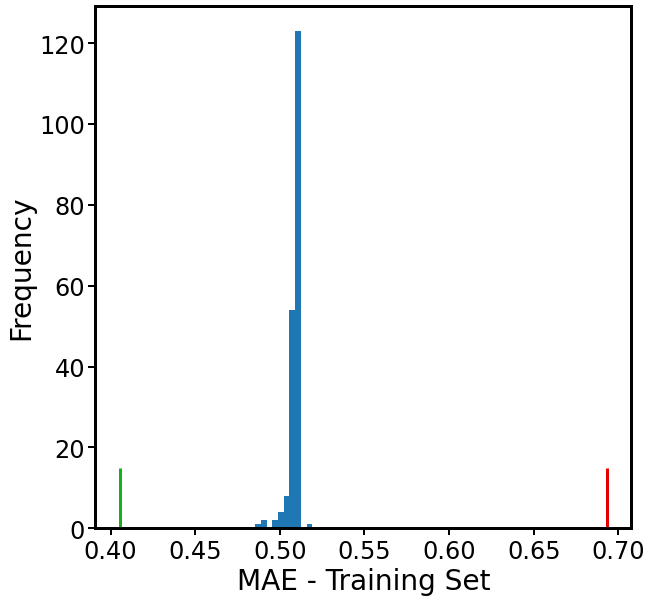

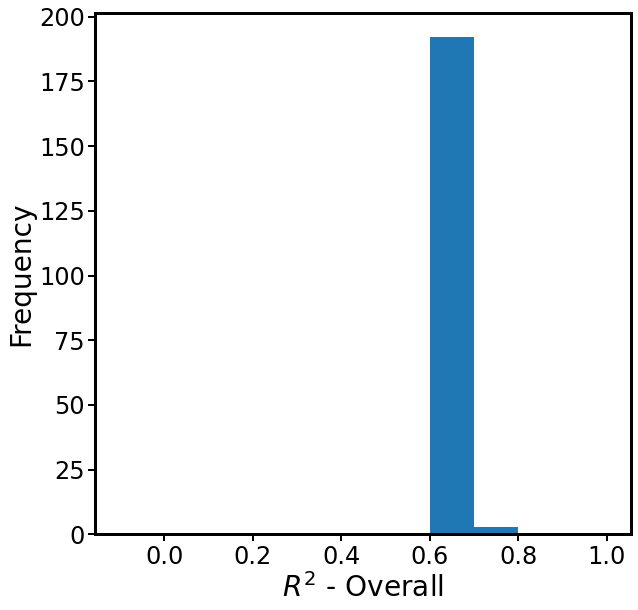

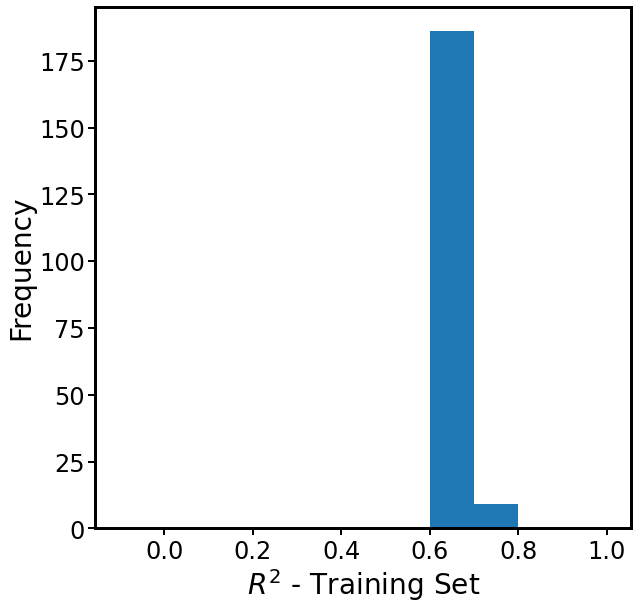

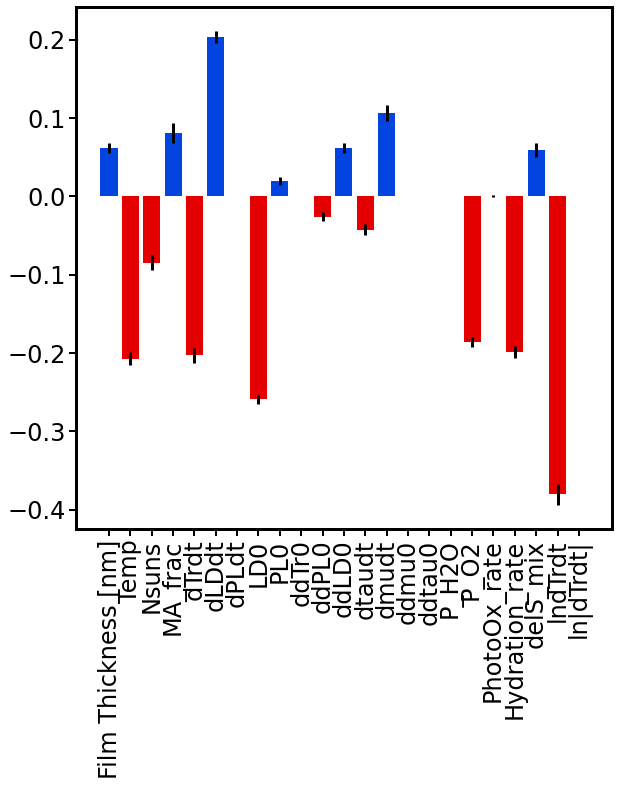

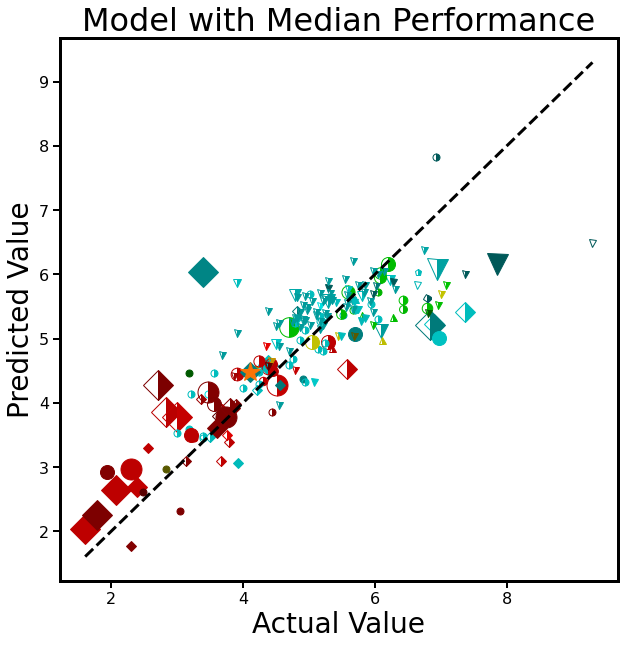

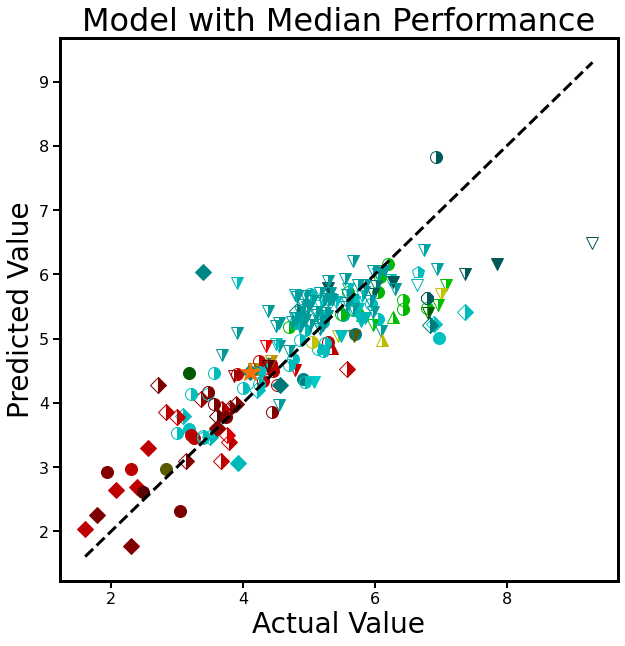

In [7]:
# try some machine learning in this cell - LASSO with leave one out testing [test cell]
# DISCLAIMER: be very careful when mixing pandas and sklearn - some of the canned functions from sklearn take in 
# DataFrames but spit out arrays. Indexing can become a mess if rows have been removed from the DF during data cleaning
# because the indices will no longer sync up between the DFs and the output array. (This can happen when using the 
# .dropna() method to remove runs that do not go to LD,75, for instance.) 

# first determine whether to do a log transform on the response or not, 
# then partition the data into features (X) and response (Y) DFs
if Log_transform:
    Y = np.log(np.abs(coded_df[response])).copy() # BE VERY CAREFUL NOT TO UNINTENTIONALLY CHANGE THE DATAFRAME
else:
    Y = coded_df[response].copy()
X = coded_df.drop(columns=response).copy()

# number of runs in dataset - for leave-one-out testing this is the size of the dataset
n_trials = len(Y)

# set up search parameters for cross-validation, which will be used to select the hyperparameter
param_vals = np.logspace(-3,1,num=21) # range of hyperparameters to test
parameters = {'alpha': param_vals}
model = Lasso(max_iter=1e9) # model to implement - LASSO, Ridge, etc.
metric = 'neg_mean_absolute_error' # scoring metric - MSE, R2, etc.
folds = n_trials-1 # how many folds to do in k-fold cross-validation - 5 is standard
folds = 10

# initialize error metrics for test set...
R2 = np.zeros(n_trials) # coefficient of determination
RMSE = np.zeros(n_trials) # RMS error
MAE_pct = np.zeros(n_trials) # mean absolute error, percent
MAE_pct_signed = np.zeros(n_trials) # mean absolute error, percent with sign
MAE = np.zeros(n_trials) # mean absolute error

# ...and for the whole dataset...
MAE_pct_overall = np.zeros(n_trials) # mean absolute error, percent
MAE_overall = np.zeros(n_trials) # mean absolute error, percent
R2_overall = np.zeros(n_trials) # coefficient of determination

# ...and for the training set
MAE_pct_train = np.zeros(n_trials) # mean absolute error, percent
MAE_train = np.zeros(n_trials) # mean absolute error, percent
R2_train = np.zeros(n_trials) # coefficient of determination

# error on linear scale (only relevant if log transform is used on response, but we do this a lot)
linear_error = np.zeros(n_trials)

# initialize a dataframe to keep track of model coefficients on every iteration of the test set loop
coeffs_df = pd.DataFrame(columns=coded_df.drop(columns=response).columns)
# keep track of feature standardization values too
means_array = np.zeros([n_trials,len(coded_df.drop(columns=response).columns)])
stds_array = np.zeros([n_trials,len(coded_df.drop(columns=response).columns)])
# make a list to keep track of model bias term
model_intercepts = []
# keep track of Shapley values too
Shap_vals_df =  pd.DataFrame(columns=coded_df.drop(columns=response).columns)
# keep track of *change in* error with feature deleted relative to model with the full feature set
d_error_missing_feats = []

# outer loop: hold one sample out for testing every iteration
for kk in range(n_trials):
    
    # do test/train split by pulling out one row at a time form the feature and response DFs
    # CAREFUL WITH THE INDEXING - note differences between the test/withhold and training sets
    # ALSO: COPY THE SUBSETS Of THE DATAFRAMES or the values in the source will change and the 
    # prediction will be unstable and the whole thing will be ruined
    X_whold = X.iloc[kk].copy()
    y_whold = Y.iloc[kk:kk+1].copy()
    X_train = X.drop(X.index[kk]).copy()
    y_train = Y.drop(X.index[kk]).copy()
    
    # standardize the data according to the mean and variance of each feature in the training dataset
    for nn,col in enumerate(X_train.columns):
        # get mean and variance of features in the test set
        col_mean = np.mean(X_train[col])
        col_std = np.std(X_train[col])
        # standardize the features in the training set
        z_train = (X_train[col] - col_mean)/col_std
        X_train[col] = z_train
        # standardize the features in the test set
        z_whold = (X_whold[col] - col_mean)/col_std
        X_whold[col] = z_whold
        means_array[kk,nn] = col_mean
        stds_array[kk,nn] = col_std
        
    
    # cross-validation step to set alpha/lambda/penalty hyperparameter
    regressor = GridSearchCV(model,parameters,scoring=metric,cv=folds)
    regressor.fit(X_train,y_train)
    
    # print winning HP value if desired...
    print(regressor.best_params_)
    #print(regressor.best_score_)
    alpha = regressor.best_params_['alpha']
    
    # ...and retrain the final model on the full training set
    final_model = Lasso(alpha=alpha)
    final_model.fit(X_train,y_train)
    #print(final_model.coef_)
    
    # if desired, recalculate the coefficients:
    if unshrink_coefficients:
        
        # figure out which coefficients survived
        surviving_coeffs = X.columns[np.where(final_model.coef_ != 0)]
        
        # make a copy of the training set with rejected coefficients stripped out
        X_red = X_train.copy()
        X_red = X_red[surviving_coeffs]
        X_whold_red = X_whold.copy()
        X_whold_red = X_whold_red[surviving_coeffs]
        # retrain the final model
        
        # train a simple linear regression
        shrunk_model = sklearn.linear_model.LinearRegression()
        shrunk_model.fit(X_red,y_train)
        
        # and fit the data
        ypred=shrunk_model.predict(np.array(X_whold_red).reshape(1,-1))
        ytpred=shrunk_model.predict(X_red)
    
    else:
        # make predictions on the test and training data
        ypred=final_model.predict(np.array(X_whold).reshape(1,-1))
        ytpred=final_model.predict(X_train)
    
    # calculate error metrics on test set
    RMSE[kk] = np.sqrt(metrics.mean_squared_error(np.array(y_whold).reshape(1,-1), ypred))
    R2[kk] = metrics.r2_score(np.array(y_whold).reshape(1,-1), ypred)
    MAE_pct[kk] = np.mean(np.abs(y_whold-ypred)/np.abs(y_whold)*100)
    MAE_pct_signed[kk] = (y_whold-ypred)/y_whold*100
    MAE[kk] = np.mean(np.abs(y_whold-ypred))
    
    # put the whole dataset back together (note that this will create arrays, not DFs)
    y_net = np.concatenate([y_train,y_whold])
    y_pred_net = np.concatenate([ytpred,ypred])
    
    # calculate error metrics on entire set
    R2_overall[kk] = metrics.r2_score(y_net, y_pred_net)
    MAE_overall[kk] = np.mean(np.abs(y_net-y_pred_net))
    MAE_pct_overall[kk] = np.mean(np.abs(y_net-y_pred_net)/np.abs(y_net)*100)
    
    # calculate error metrics on training set
    R2_train[kk] = metrics.r2_score(y_train, ytpred)
    MAE_train[kk] = np.mean(np.abs(y_train-ytpred))
    MAE_pct_train[kk] = np.mean(np.abs(y_train-ytpred)/np.abs(y_train)*100)
    
    # calculate linear error metric
    linear_error[kk] = np.abs(np.exp(y_whold) -  np.exp(ypred))/np.exp(y_whold)*100
    
    # plot training data with markers corresponding to environmental + compositional conditions
    if kk%20 == 0: # only do this for a few models to save memory
        
        plt.figure(figsize=(10,10))
        for ii in range(len(y_train)):
            idx = y_train.index[ii] # pull the corresponding index in the DF
            T = rawdata_df['Temp (deg C)'][idx] # get temperature
            RH = rawdata_df['RH (%)'][idx] # get relative humidity
            pct_O2 = rawdata_df['Oxygen (%)'][idx] # get oxygen mole fraction
            N_suns_stress = rawdata_df['Illum (Nsuns)'][idx] # get illumination
            color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
            MA_frac = rawdata_df['MA fraction'][idx] # get composition
            # and plot
            plt.plot(y_train.loc[idx],ytpred[ii],color=color,marker=marker,markersize=14*(1.5-MA_frac),fillstyle=fill,linestyle=style)
            # plt.text(y_train.loc[idx],ytpred[ii],idx) # ERROR checking: plot the index value
            
        # plot perfect prediction line and +/-50% error bounds
        plotRange = np.linspace(np.min(y_train),np.max(y_train),num=101)
        plt.plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
        #plt.plot(plotRange,plotRange+np.log(1.5),color='r',marker = ' ',linestyle='--')
        #plt.plot(plotRange,plotRange+np.log(0.5),color='r',marker = ' ',linestyle='--')
        
        # put labels on the axes
        plt.xlabel('Actual Value')
        plt.ylabel('Predicted Value')

        # plot test data as above
        for ii in range(len(y_whold)):
            idx = y_whold.index[ii] # pull the corresponding index in the DF
            T = rawdata_df['Temp (deg C)'][idx] # get temperature
            RH = rawdata_df['RH (%)'][idx] # get relative humidity
            pct_O2 = rawdata_df['Oxygen (%)'][idx] # get oxygen mole fraction
            N_suns_stress = rawdata_df['Illum (Nsuns)'][idx] # get illumination
            color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
            MA_frac = rawdata_df['MA fraction'][idx] # get composition
            plt.plot(y_whold[idx],ypred[ii],color=color,marker=marker,markersize=14*(1.5-MA_frac),fillstyle=fill,linestyle=style)
            # plot orange star to identify test samples
            plt.plot(y_whold[idx],ypred[ii],marker='*',markersize=20,color='xkcd:orange')                
    
    # save the model coefficients to the respective row in the DF
    if unshrink_coefficients:
        # reconstruct the full model coefficients
        coeffs_vector = np.zeros(len(final_model.coef_))
        count = 0
        for ii in range(len(final_model.coef_)):
            if final_model.coef_[ii] != 0:
                coeffs_vector[ii] = shrunk_model.coef_[count]
                count += 1
        coeffs_df = coeffs_df.append(pd.DataFrame(coeffs_vector.reshape(1,len(final_model.coef_)),
                                                  columns=coded_df.drop(columns=response).columns))


    else:
        coeffs_df = coeffs_df.append(pd.DataFrame(final_model.coef_.reshape(1,len(final_model.coef_)),columns=coded_df.drop(columns=response).columns))

    model_intercepts.append(final_model.intercept_)
    
        
    # calculate and save Shapley values
    shap_vals = final_model.coef_.reshape(1,len(final_model.coef_))*(np.array(X_whold)-np.mean(np.array(X_train),axis=0))
    Shap_vals_df = Shap_vals_df.append(pd.DataFrame(shap_vals,columns=coded_df.drop(columns=response).columns))
    
    # sensitivity analysis for feature removal
    sensitivity_analysis = False
    
    if sensitivity_analysis:
        # re-initialize a list for keeping track of error with feature deleted
        d_error_missing_feats_per_obv = []

        # loop over features
        for col in X_train.columns:

            # drop each feature
            X_train_reduced = X_train.drop(columns=col).copy()
            X_whold_reduced = X_whold.drop(col).copy()

            # set alpha/lambda/penalty hyperparameter
            regressor.fit(X_train_reduced,y_train)
            alpha = regressor.best_params_['alpha']

            # train the final model on the full training set
            final_model_red = Lasso(alpha=alpha)
            final_model_red.fit(X_train_reduced,y_train)

            # make predictions on the test and training data
            ypred=final_model_red.predict(np.array(X_whold_reduced).reshape(1,-1))

            # calculate error metrics on test set with the missing feature
            # and append it to the error list
            d_error_missing_feats_per_obv.append(np.mean(np.abs(y_whold-ypred)/np.abs(y_whold)*100) - MAE_pct[kk])

    if sensitivity_analysis:    
        # save the error with deleted features
        d_error_missing_feats.append(d_error_missing_feats_per_obv)

if sensitivity_analysis:
    # convert the change in error with missing features to a dataframe from epi-list
    missing_feats_DF = pd.DataFrame(d_error_missing_feats,columns=coded_df.drop(columns=response).columns)    

# plot histogram of absolute test set error
plt.figure()
plt.hist(MAE)
plt.xlabel('MAE - Test Set')
plt.ylabel('Frequency')
plt.vlines(-np.log(0.5),ymin=0,ymax=15,color='xkcd:red')
plt.vlines(np.log(1.5),ymin=0,ymax=15,color='xkcd:green')

# plot histogram of percent test set error
plt.figure()
plt.hist(MAE_pct)
plt.xlabel('Relative MAE - Test Set')
plt.ylabel('Frequency')

# plot histogram of absolute full set error
plt.figure()
plt.hist(MAE_overall)
plt.xlabel('MAE - Overall')
plt.ylabel('Frequency')
plt.vlines(-np.log(0.5),ymin=0,ymax=15,color='xkcd:red')
plt.vlines(np.log(1.5),ymin=0,ymax=15,color='xkcd:green')

# plot histogram of absolute training set error
plt.figure()
plt.hist(MAE_train)
plt.xlabel('MAE - Training Set')
plt.ylabel('Frequency')
plt.vlines(-np.log(0.5),ymin=0,ymax=15,color='xkcd:red')
plt.vlines(np.log(1.5),ymin=0,ymax=15,color='xkcd:green')

# plot histogram of full set R2
plt.figure()
plt.hist(R2_overall,bins=np.linspace(-0.1,1,num=12))
plt.xlabel('$R^2$ - Overall')
plt.ylabel('Frequency')

# plot histogram of training set R2
plt.figure()
plt.hist(R2_train,bins=np.linspace(-0.1,1,num=12))
plt.xlabel('$R^2$ - Training Set')
plt.ylabel('Frequency')

# plot distribution of coefficients...
plt.figure()

# convert labels "A", "B", etc. back to physically meaningful names
new_dict = {
    "A":"Temp",
    "B":"RH",
    'C':'O2',
    'D':'Nsuns',
    'E':'MA_frac'
}
coeffs_df.rename(columns = new_dict, inplace = True)

# populate standardization values
coeffs = coeffs_df.columns # save coefficient names
means_df = pd.DataFrame(means_array,columns=coeffs)
stds_df = pd.DataFrame(stds_array,columns=coeffs)


# add intercepts and rename coefficients
#coeffs_df['intercepts'] = model_intercepts
coeffs = coeffs_df.columns # save coefficient names

avgs = np.mean(coeffs_df) # average the coefficients
error = np.std(coeffs_df) # and get their standard deviations



# assign colors to coefficient bars based on sign:
# red: accelerates degradation
# blue: decelerates degradation
# (these have different signs depending on what the response is)
bar_colors = []
if response == 'Bleach Rate (fit to 5% inc) (1/min)':
    for jj in range(len(coeffs)):
        if np.sign(avgs[jj]) == 1:
            bar_colors.append('xkcd:red')
        else:
            bar_colors.append('xkcd:blue')
else:
    for jj in range(len(coeffs)):
        if np.sign(avgs[jj]) == 1:
            bar_colors.append('xkcd:blue')
        else:
            bar_colors.append('xkcd:red')

# plot the coefficients
plt.bar(coeffs,avgs,yerr=error,color=bar_colors)
plt.xticks(rotation=90) # make the labels legible

# Print important test statistics
print('For test set:')
print('Mean of Mean Absolute Error =', np.round(np.mean(MAE_pct),1), '%')
print('Median of Mean Absolute Error =', np.round(np.median(MAE_pct),1), '%')
print('Std. Dev. of Mean Absolute Error =', np.round(np.std(MAE_pct),1), '%')
print('Mean of Mean Absolute Error =', np.round(np.mean(MAE),3))
print('Median of Mean Absolute Error =', np.round(np.median(MAE),3))
print('Std. Dev. of Mean Absolute Error =', np.round(np.std(MAE),3))
print('Mean R2 =', np.round(np.mean(R2),4))
print('Median R2 =', np.round(np.median(R2),4))
print('Std Dev. R2 =', np.round(np.std(R2),4))

print('For whole model:')
print('Mean of Mean Absolute Error =', np.round(np.mean(MAE_pct_overall),1), '%')
print('Median of Mean Absolute Error =', np.round(np.median(MAE_pct_overall),1), '%')
print('Std. Dev. of Mean Absolute Error =', np.round(np.std(MAE_pct_overall),1), '%')
print('Mean of Mean Absolute Error =', np.round(np.mean(MAE_overall),3))
print('Median of Mean Absolute Error =', np.round(np.median(MAE_overall),3))
print('Std. Dev. of Mean Absolute Error =', np.round(np.std(MAE_overall),3))
print('Mean R2 =', np.round(np.mean(R2_overall),4))
print('Median R2 =', np.round(np.median(R2_overall),4))
print('Std Dev. R2 =', np.round(np.std(R2_overall),4))

print('Mean Linear Error =',np.round(np.mean(linear_error),1),'%')
print('Median Linear Error =',np.round(np.median(linear_error),1),'%')


##### Below this line is the code for plotting the performance of the median model

# identify the index corresponding to the median mean test error
idx = np.argmin(np.abs(MAE_pct-np.median(MAE_pct)))
med_idx = idx # save the median index in a less ambiguous form
print('Index of Median Model:',idx)

# partition the dataset - note the manipulations necessary to convert the index derived from 
# the test error array to the index of the DataFrame - THESE VALUES ARE DIFFERENT!
kk = idx
X_whold = X.iloc[kk].copy()
y_whold = Y.iloc[kk:kk+1].copy()
X_train = X.drop(X.index[kk]).copy()
y_train = Y.drop(X.index[kk]).copy()



# standardize the data according to the mean and variance of the training dataset
for col in X_train.columns:
    # get mean and variance of features in the test set
    col_mean = np.mean(X_train[col])
    col_std = np.std(X_train[col])
    # standardize the features in the training set
    z_train = (X_train[col] - col_mean)/col_std
    X_train[col] = z_train
    # standardize the features in the test set
    z_whold = (X_whold[col] - col_mean)/col_std
    X_whold[col] = z_whold
    

# cross-validation step to set alpha/lambda/penalty hyperparameter
regressor = GridSearchCV(model,parameters,scoring=metric,cv=folds)
regressor.fit(X_train,y_train)

# print winning HP value if desired...
print(regressor.best_params_)
#print(regressor.best_score_)
alpha = regressor.best_params_['alpha']

# and retrain the final model on the full training set
final_model = Lasso(alpha=alpha)
final_model.fit(X_train,y_train)
#print(final_model.coef_)

if unshrink_coefficients:

    # figure out which coefficients survived
    surviving_coeffs = X.columns[np.where(final_model.coef_ != 0)]

    # make a copy of the training set with rejected coefficients stripped out
    X_red = X_train.copy()
    X_red = X_red[surviving_coeffs]
    X_whold_red = X_whold.copy()
    X_whold_red = X_whold_red[surviving_coeffs]
    # retrain the final model

    # train a simple linear regression
    shrunk_model = sklearn.linear_model.LinearRegression()
    shrunk_model.fit(X_red,y_train)

    # and fit the data
    ypred=shrunk_model.predict(np.array(X_whold_red).reshape(1,-1))
    ytpred=shrunk_model.predict(X_red)

else:
    # make predictions on the test and training data
    ypred=final_model.predict(np.array(X_whold).reshape(1,-1))
    ytpred=final_model.predict(X_train)

####### PLOT THE MEDIAN MODEL ##############

plt.figure(figsize=(10,10))
for ii in range(len(y_train)):
    idx = y_train.index[ii]
    #T = X[factor_dict_inv['Temp (deg C)']][idx]
    #RH = X[factor_dict_inv['RH (%)']][idx]
    #pct_O2 = X[factor_dict_inv['Oxygen (%)']][idx]
    #N_suns_stress = X[factor_dict_inv['Illum (Nsuns)']][idx]
    T = rawdata_df['Temp (deg C)'][idx]
    RH = rawdata_df['RH (%)'][idx]
    pct_O2 = rawdata_df['Oxygen (%)'][idx]
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    #MA_frac = X[factor_dict_inv['MA fraction']][idx]
    MA_frac = rawdata_df['MA fraction'][idx]
    plt.plot(y_train.loc[idx],ytpred[ii],color=color,marker=marker,markersize=14*(1.5-MA_frac),fillstyle=fill,linestyle=style)
    #plt.text(y_train.loc[idx],ytpred[ii],idx)

# plot perfect prediction line and +/-50% error bounds
plotRange = np.linspace(np.min(y_train),np.max(y_train),num=101)
plt.plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
#plt.plot(plotRange,plotRange+np.log(1.5),color='r',marker = ' ',linestyle='--')
#plt.plot(plotRange,plotRange+np.log(0.5),color='r',marker = ' ',linestyle='--')

plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Model with Median Performance')

# plot test data as above, with environment denoted by marker appearance and composition by marker size
for ii in range(len(y_whold)):
    idx = y_whold.index[ii]
    T = rawdata_df['Temp (deg C)'][idx]
    RH = rawdata_df['RH (%)'][idx]
    pct_O2 = rawdata_df['Oxygen (%)'][idx]
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    MA_frac = rawdata_df['MA fraction'][idx]
    plt.plot(y_whold[idx],ypred[ii],color=color,marker=marker,markersize=14*(1.5-MA_frac),fillstyle=fill,linestyle=style)
    plt.plot(y_whold[idx],ypred[ii],marker='*',markersize=20,color='xkcd:orange') 
    
####### PLOT THE MEDIAN MODEL - ALTERNATIVE STYLE ##############
# i.e., separate plots encoding environment and composition

plt.figure(figsize=(10,10))
for ii in range(len(y_train)):
    idx = y_train.index[ii]
    T = rawdata_df['Temp (deg C)'][idx]
    RH = rawdata_df['RH (%)'][idx]
    pct_O2 = rawdata_df['Oxygen (%)'][idx]
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    MA_frac = rawdata_df['MA fraction'][idx]
    plt.plot(y_train.loc[idx],ytpred[ii],color=color,marker=marker,fillstyle=fill,linestyle=style)
    #plt.text(y_train.loc[idx],ytpred[ii],idx)

# plot perfect prediction line and +/-50% error bounds
plotRange = np.linspace(np.min(y_train),np.max(y_train),num=101)
plt.plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
#plt.plot(plotRange,plotRange+np.log(1.5),color='r',marker = ' ',linestyle='--')
#plt.plot(plotRange,plotRange+np.log(0.5),color='r',marker = ' ',linestyle='--')

plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Model with Median Performance')

# plot test data as above
for ii in range(len(y_whold)):
    idx = y_whold.index[ii]
    T = rawdata_df['Temp (deg C)'][idx]
    RH = rawdata_df['RH (%)'][idx]
    pct_O2 = rawdata_df['Oxygen (%)'][idx]
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    MA_frac = rawdata_df['MA fraction'][idx]
    plt.plot(y_whold[idx],ypred[ii],color=color,marker=marker,fillstyle=fill,linestyle=style)
    plt.plot(y_whold[idx],ypred[ii],marker='*',markersize=20,color='xkcd:orange')



In [361]:
means_df.iloc[kk]

dPLdt           0.095003
PL0             0.000272
ddPL0          -0.001415
vol_rate       -1.127518
d_vol_rate     -0.389417
ln|vol_rate|   -0.105919
Name: 51, dtype: float64

In [362]:
stds_df.iloc[kk]

dPLdt           0.106494
PL0             0.000328
ddPL0           0.009829
vol_rate        0.698756
d_vol_rate      2.735008
ln|vol_rate|    0.739600
Name: 51, dtype: float64

In [363]:
coeffs_df.iloc[kk]

dPLdt          -0.065258
PL0             0.033640
ddPL0          -0.048343
vol_rate        0.000000
d_vol_rate      0.139592
ln|vol_rate|   -0.465675
intercepts      4.513473
Name: 0, dtype: float64

In [22]:
# make a dataFrame that will be used for bar plots specifically
bars_df = pd.DataFrame(np.mean(missing_feats_DF)) # base it off the mean coefficient values
bars_df = bars_df.rename(columns={0:'means'})
bars_df['coeffs'] = missing_feats_DF.columns # get coefficient names
bars_df.index = coeffs # make the DF indices equal to the coefficient names
bars_df['means'] = bars_df['means'] # convert means to their absolute values for prettier/easier-to-read plots
bars_df = bars_df.sort_values(by = 'means', ascending=False) # sort the bars in descending order of mean


plt.figure()
plt.bar(bars_df.index,bars_df['means'])
ax=plt.gca()
ax.set_xticklabels(bars_df.index,rotation=90)
plt.ylabel('Mean Increase in Test Set Error as a Result of Dropping Feature [%]')

NameError: name 'missing_feats_DF' is not defined

# 7. View Coefficient Summaries

For each iteration of the test set loop, we pulled out the values of the coefficients corresponding to each feature; let's look more closely at some statistics to determine how the models look

<ipython-input-31-d27a800448aa>:152: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(labels=fancy_labels,rotation=90)
<ipython-input-31-d27a800448aa>:172: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(labels=fancy_labels,rotation=90)
<ipython-input-31-d27a800448aa>:219: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(fancy_labels,rotation=90)


Text(0.5, 0.9, 'Feature Weights')

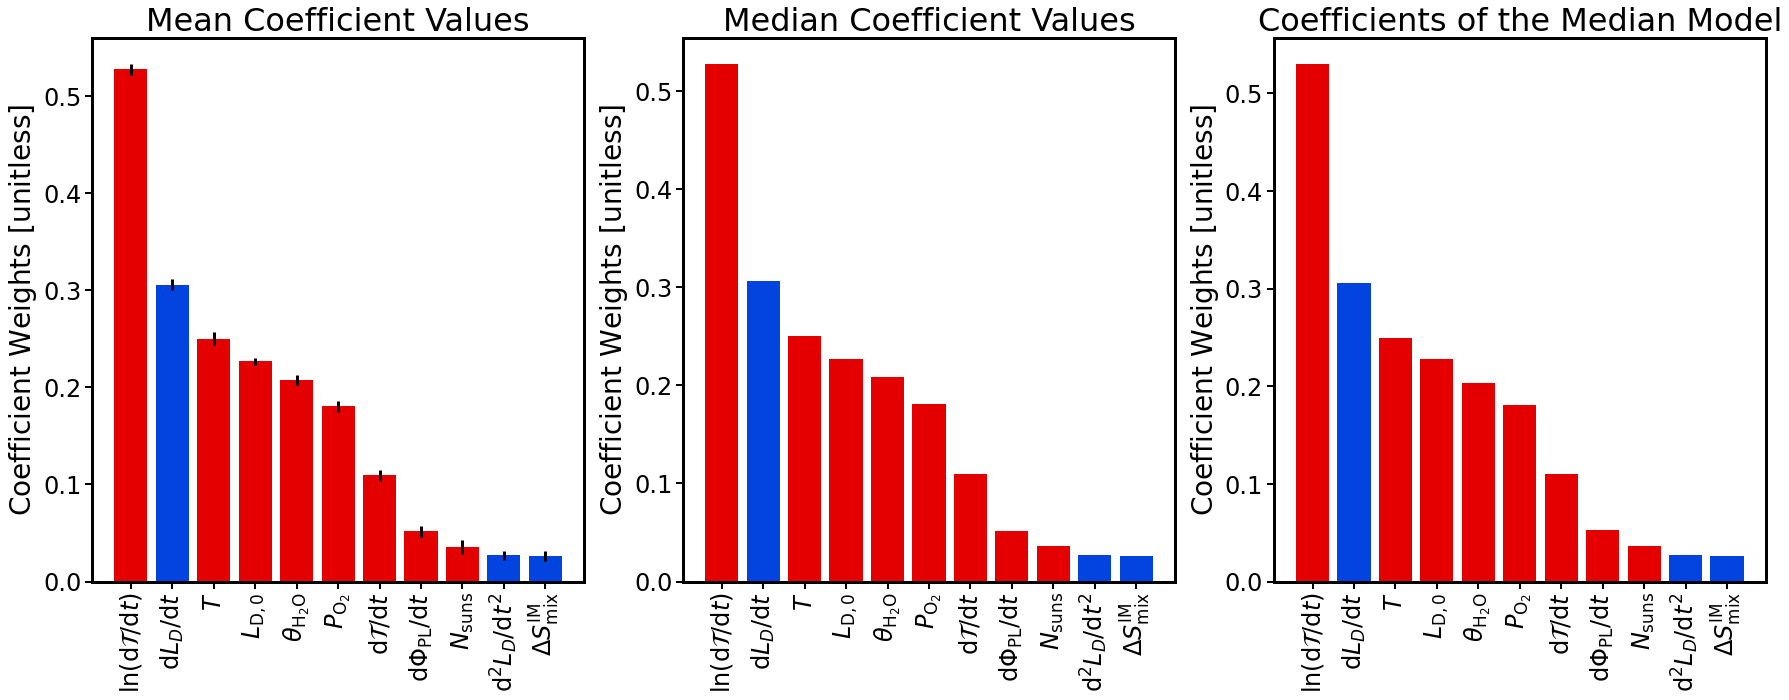

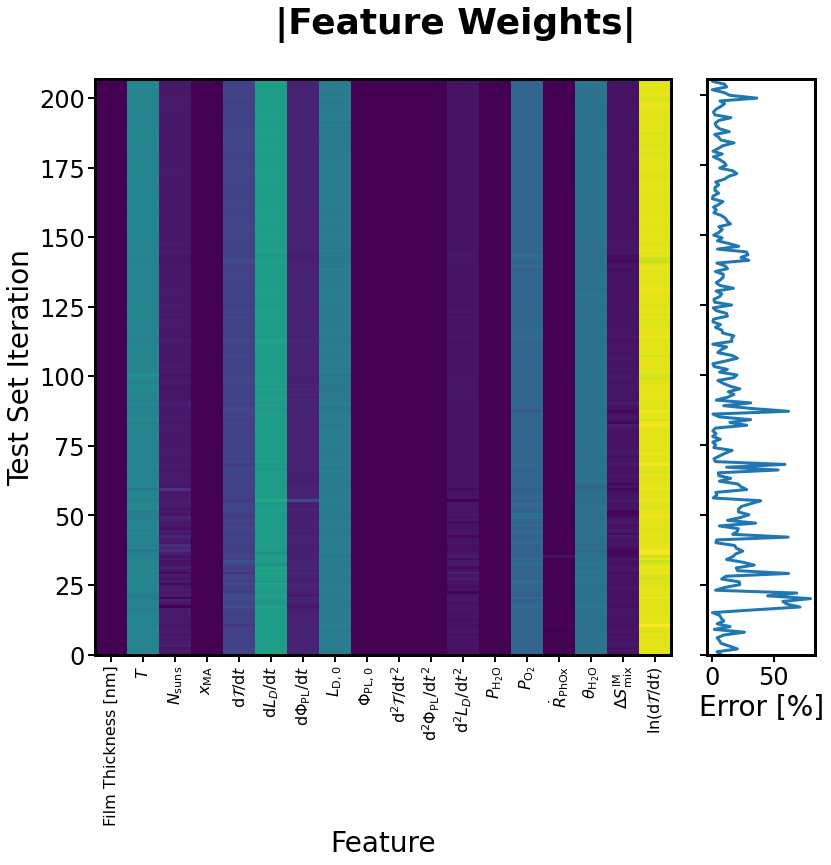

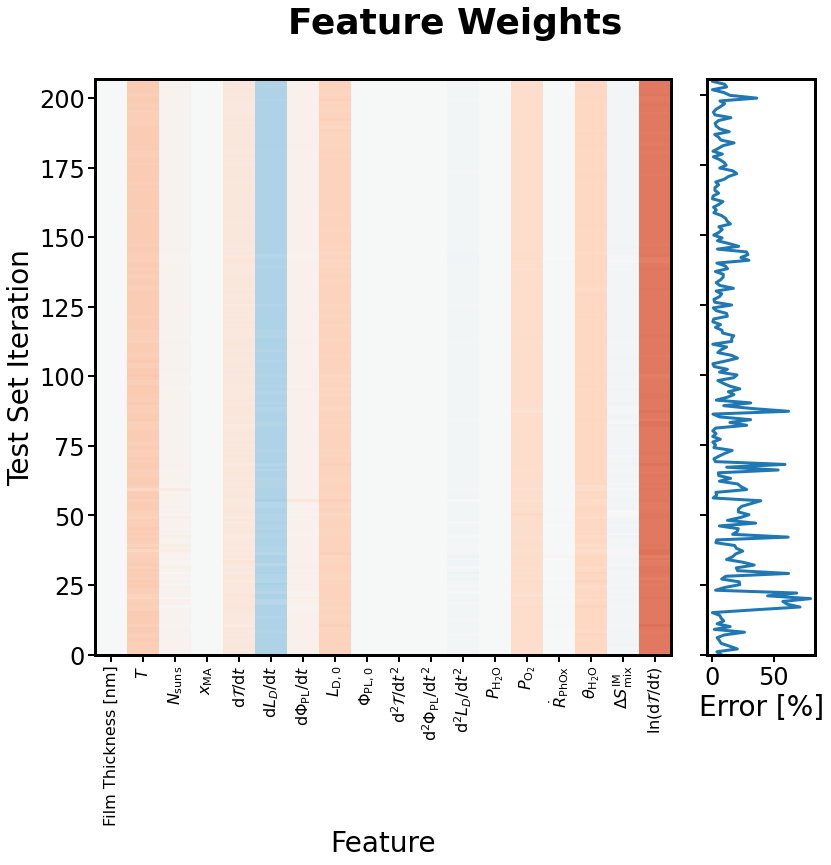

In [31]:
# make a copy of the coeffs_df but with Boolean values to indicate whether the corresponding feature was selected
selected_df = coeffs_df.copy()

for ii in range(len(selected_df)):
    logic = selected_df.iloc[ii] != 0 # convert nonzero values to True, zero values to False
    selected_df.iloc[ii] = logic

# make a DF of key statistics on the coefficient values
stats_df = coeffs_df.copy()

# initialize lists of key stats
medians = []
means = []
stds = []

# populate the lists...
for col in coeffs_df.columns:
    medians.append(np.median(coeffs_df[col]))
    means.append(np.mean(coeffs_df[col]))
    stds.append(np.std(coeffs_df[col]))
# ...and add them to the DataFrame 
stats_df.loc['medians'] = medians
stats_df.loc['means'] = means
stats_df.loc['stds'] = stds

# plot the median values of the coefficients
#plt.figure(figsize=(10,10))
#plt.bar(stats_df.columns,stats_df.loc['medians'])
#plt.xticks(rotation=90)

# assign bar colors to mean coefficient values
bar_colors_mean = []
if response == 'Bleach Rate (fit to 5% inc) (1/min)':
    for jj in range(len(coeffs)):
        if np.sign(means[jj]) == 1:
            bar_colors_mean.append('xkcd:red')
        else:
            bar_colors_mean.append('xkcd:blue')
else:
    for jj in range(len(coeffs)):
        if np.sign(avgs[jj]) == 1:
            bar_colors_mean.append('xkcd:blue')
        else:
            bar_colors_mean.append('xkcd:red')

# assign bar colors to median coefficient values
bar_colors_median = []
if response == 'Bleach Rate (fit to 5% inc) (1/min)':
    for jj in range(len(coeffs)):
        if np.sign(medians[jj]) == 1:
            bar_colors_median.append('xkcd:red')
        else:
            bar_colors_median.append('xkcd:blue')
else:
    for jj in range(len(coeffs)):
        if np.sign(medians[jj]) == 1:
            bar_colors_median.append('xkcd:blue')
        else:
            bar_colors_median.append('xkcd:red')

# make a dataFrame that will be used for bar plots specifically
bars_df = pd.DataFrame(means) # base it off the mean coefficient values
bars_df = bars_df.rename(columns={0:'means'})
bars_df['coeffs'] = coeffs # get coefficient names
bars_df.index = coeffs # make the DF indices equal to the coefficient names
bars_df['means'] = np.abs(bars_df['means']) # convert means to their absolute values for prettier/easier-to-read plots
bars_df['medians'] = np.abs(medians) # add median coefficient values
bars_df['error'] = stds # add standard deviations
bars_df['colors_mean'] = bar_colors_mean # encode coefficient sign in bar color
bars_df['colors_median'] = bar_colors_mean # encode coefficient sign in bar color
bars_df = bars_df.sort_values(by = 'means', ascending=False) # sort the bars in descending order of mean

# reduced dataframe of only coefficients with nonvanishing magnitude
nz_bars_df = bars_df[bars_df['means'] > 0]

# further reduced dataframe of only coefficients whose average is larger than their std. dev.
sig_bars_df = nz_bars_df[nz_bars_df['means'] > nz_bars_df['error']]

# for making plots look nice:
# dictionary for conversion of ASCII feature labels to TeX-style labels
fancy_labels_dict = {'dTrdt':'$\mathrm{d}\mathcal{T}/\mathrm{d}t$',
                     'lndTrdt':'ln($\mathrm{d}\mathcal{T}/\mathrm{d}t$)',
                     'dLDdt':'$\mathrm{d}L_D/\mathrm{d}t$',
                     'dPLdt':'$\mathrm{d}\Phi_\mathrm{PL}/\mathrm{d}t$',
                     'ddTr0':'$\mathrm{d^2}\mathcal{T}/\mathrm{d}t^2$',
                     'ddLD0':'$\mathrm{d}^2L_D/\mathrm{d}t^2$',
                     'ddPL0':'$\mathrm{d^2}\Phi_\mathrm{PL}/\mathrm{d}t^2$',
                     'dDFmeandt':'$\mathrm{d}\mu_\mathrm{DF}/\mathrm{d}t$',
                     'dtaudt':'$\mathrm{d}\\tau/\mathrm{d}t$',
                     'ddtau0':'$\mathrm{d^2}\\tau/\mathrm{d}t^2$',
                     'dmudt':'$\mathrm{d}\mu/\mathrm{d}t$',
                     'ddmu0':'$\mathrm{d^2}\mu/\mathrm{d}t^2$',
                     'Ld1':'$L_{\mathrm{D},t=1}$',
                     'Ld2':'$L_{\mathrm{D},t=2}$',
                     'Ld3':'$L_{\mathrm{D},t=3}$',
                     'Ld4':'$L_{\mathrm{D},t=4}$',
                     'Ld5':'$L_{\mathrm{D},t=5}$',
                     'Tr1':'$\mathcal{T}_{t=1}$',
                     'Tr2':'$\mathcal{T}_{t=2}$',
                     'Tr3':'$\mathcal{T}_{t=3}$',
                     'Tr4':'$\mathcal{T}_{t=4}$',
                     'Tr5':'$\mathcal{T}_{t=5}$',
                     'PL1':'$\Phi_{\mathrm{PL},t=1}$',
                     'PL2':'$\Phi_{\mathrm{PL},t=2}$',
                     'PL3':'$\Phi_{\mathrm{PL},t=3}$',
                     'PL4':'$\Phi_{\mathrm{PL},t=4}$',
                     'PL5':'$\Phi_{\mathrm{PL},t=5}$',
                     'PL0':'$\Phi_{\mathrm{PL},0}$',
                     'LD0':'$L_{\mathrm{D},0}$',
                     'QFLS_0':'$\Delta E_{\mathrm{F},0}$',
                     'Days Stored':'$t_{\mathrm{storage}}$',
                     'Temp':'$T$',
                     'P_H2O':'$P_\mathrm{H_2O}$',
                     'P_O2':'$P_\mathrm{O_2}$',
                     'Nsuns':'$N_\mathrm{suns}$',
                     'MA_frac':'$x_\mathrm{MA}$',
                     'PhotoOx_rate':'$\dot{R}_\mathrm{PhOx}$',
                     'Hydration_rate':'$\\theta_\mathrm{H_2O}$',
                     'Ox_rate':'$\dot{R}_\mathrm{Ox}$',
                     'delS_mix':'$\Delta S^\mathrm{IM}_\mathrm{mix}$',
                     'LAI_O2':'$\\theta_\mathrm{O_2}$',
                     'Ox_rate_LAI':'$\\theta_\mathrm{O_2}\mathrm{exp}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                     'Ox_rate_P':'$P_\mathrm{O_2}\mathrm{exp}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                     'Arrhenius_Ox':'$\mathrm{exp}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                     'PhotoOx_rate_P':'$P_\mathrm{O_2}N_\mathrm{suns}^{\gamma}\mathrm{exp}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                     'ln_r':'ln($r_\mathrm{deg}$)',
                     'ln|dAdt|':'ln|$\mathrm{d}A/\mathrm{d}t$|',
                     'dAdt':'$\mathrm{d}A/\mathrm{d}t$',
                     'ddA0':'$\mathrm{d}^2 A/\mathrm{d}t^2$',
                     'ln|vol_rate|':'ln|$\\frac{1}{L}\mathrm{d}A/\mathrm{d}t$|',
                     'vol_rate':'$\\frac{1}{L}\mathrm{d}A/\mathrm{d}t$',
                     'd_vol_rate':'$\\frac{1}{L}\mathrm{d}^2A/\mathrm{d}t^2$',
                     'ln|meas_rate|':'ln|$r_\mathrm{vol}^\mathrm{meas}$|',
                     'meas_rate':'$r_\mathrm{vol}^\mathrm{meas}$',
                     'd_meas_rate':'$\\frac{\mathrm{d}}{\mathrm{d}t} \left[r_\mathrm{vol}^\mathrm{meas}\\right]$',
                     'ln|model_rate|':'ln|$r_\mathrm{vol}^\mathrm{model}$|',
                     
                    }
# define list of nice-looking labels
fancy_labels=[]
for coeff in sig_bars_df['coeffs']:
    try:
        fancy_labels.append(fancy_labels_dict[coeff])
    except:
        fancy_labels.append(coeff)
        
# initialize the figure for comparing coefficients
fig, ax = plt.subplots(1,3,figsize=(30,10))  

# plot the means with error bars represented by the standard deviation
ax[0].bar(sig_bars_df['coeffs'],sig_bars_df['means'],yerr=sig_bars_df['error'],color=sig_bars_df['colors_mean'])
ax[0].set_xticklabels(labels=fancy_labels,rotation=90)
ax[0].set_ylabel('$\mathrm{Coefficient\ Weights\ [unitless]}$')
ax[0].set_title('Mean Coefficient Values')

# now re-sort the DF by descending medians
bars_df = bars_df.sort_values(by = 'medians', ascending=False)

# reduced dataframe of only coefficients with nonvanishing magnitude
nz_meds_df = bars_df[bars_df['medians'] > 0]

# redefine the fancy coefficients
fancy_labels=[]
for coeff in nz_meds_df['coeffs']:
    try:
        fancy_labels.append(fancy_labels_dict[coeff])
    except:
        fancy_labels.append(coeff)

# and plot the median coefficient weights
ax[1].bar(nz_meds_df['coeffs'],nz_meds_df['medians'],color=nz_meds_df['colors_median'])
ax[1].set_xticklabels(labels=fancy_labels,rotation=90)
ax[1].set_ylabel('$\mathrm{Coefficient\ Weights\ [unitless]}$')
ax[1].set_title('Median Coefficient Values')

# identify the index corresponding to the median model
idx = np.argmin(np.abs(MAE_pct-np.median(MAE_pct)))
med_idx = idx # save the median index in a less ambiguous form
coeffs_med_model = coeffs_df.iloc[med_idx].values # extract corresponding coefficients

# assign bar colors to coefficient values
bar_colors_med_model = []
if response == 'Bleach Rate (fit to 5% inc) (1/min)':
    for jj in range(len(coeffs_med_model)):
        if np.sign(coeffs_med_model[jj]) == 1:
            bar_colors_med_model.append('xkcd:red')
        else:
            bar_colors_med_model.append('xkcd:blue')
else:
    for jj in range(len(coeffs_med_model)):
        
        if np.sign(coeffs_med_model[jj]) == 1:
            bar_colors_med_model.append('xkcd:blue')
        else:
            bar_colors_med_model.append('xkcd:red')

# make a DataFrame for bar plotting of the median model's coefficients
med_model_bars_df = pd.DataFrame(coeffs_med_model) 
med_model_bars_df = med_model_bars_df.rename(columns={0:'abs. values'})
med_model_bars_df['coeffs'] = coeffs_df.columns # get coefficient names
med_model_bars_df.index = coeffs # make the DF indices equal to the coefficient names
med_model_bars_df['colors'] = bar_colors_med_model # encode coefficient sign in bar color
med_model_bars_df['abs. values'] = np.abs(med_model_bars_df['abs. values'])
med_model_bars_df = med_model_bars_df.sort_values(by = 'abs. values', ascending=False) # sort the bars in descending order of mean

# identify the nonzero coefficients
sig_bars_med_model = med_model_bars_df.copy()[med_model_bars_df['abs. values'] > 0]

# redefine the fancy coefficients
fancy_labels=[]
for coeff in sig_bars_med_model['coeffs']:
    try:
        fancy_labels.append(fancy_labels_dict[coeff])
    except:
        fancy_labels.append(coeff)

# and make the plot
ax[2].bar(fancy_labels,sig_bars_med_model['abs. values'],color=sig_bars_med_model['colors'])
ax[2].set_xticklabels(fancy_labels,rotation=90)
ax[2].set_ylabel('$\mathrm{Coefficient\ Weights\ [unitless]}$')
ax[2].set_title('Coefficients of the Median Model')



# make a figure with all the coefficients in a heat map
fig = plt.figure(figsize=(10,10))

# redefine the fancy coefficients
fancy_labels=[]
for coeff in coeffs_df.columns:
    try:
        fancy_labels.append(fancy_labels_dict[coeff])
    except:
        fancy_labels.append(coeff)

# first panel: heat map
ax1 = fig.add_axes([0,0,0.8,0.8])
ax1.pcolor(np.abs(coeffs_df))
ax1.set_xticks(np.arange(0.5, len(coeffs_df.columns), 1))
ax1.set_xticklabels(fancy_labels,rotation=90,fontsize=16)
ax1.set_xlabel('Feature')
ax1.set_ylabel('Test Set Iteration')

# plot of error with same y-axis
ax2 = fig.add_axes([0.85,0,0.15,0.8])
ax2.plot(MAE_pct,range(len(MAE_pct)))
ax2.set_ylim([np.min(range(len(MAE_pct))),np.max(range(len(MAE_pct)))])
ax2.set_yticklabels([])
ax2.set_xlabel('Error [%]',fontsize=28)
fig.suptitle('|Feature Weights|', x=0.5, y=0.9, fontsize=36, weight='bold')


# make a figure with all the coefficients in a DIVERGING heat map
fig2 = plt.figure(figsize=(10,10))

# redefine the fancy coefficients
fancy_labels=[]
for coeff in coeffs_df.columns:
    try:
        fancy_labels.append(fancy_labels_dict[coeff])
    except:
        fancy_labels.append(coeff)

# first panel: heat map
ax1 = fig2.add_axes([0,0,0.8,0.8])
ax1.pcolor(coeffs_df, cmap = 'RdBu', vmin = -1, vmax = 1)
ax1.set_xticks(np.arange(0.5, len(coeffs_df.columns), 1))
ax1.set_xticklabels(fancy_labels,rotation=90,fontsize=16)
ax1.set_xlabel('Feature')
ax1.set_ylabel('Test Set Iteration')

# plot of error with same y-axis
ax2 = fig2.add_axes([0.85,0,0.15,0.8])
ax2.plot(MAE_pct,range(len(MAE_pct)))
ax2.set_ylim([np.min(range(len(MAE_pct))),np.max(range(len(MAE_pct)))])
ax2.set_yticklabels([])
ax2.set_xlabel('Error [%]',fontsize=28)
fig2.suptitle('Feature Weights', x=0.5, y=0.9, fontsize=36, weight='bold')

# 9. Predictions Broken Down by Environmental Conditions

Make a four-panel figure with a) coefficient weights of the median model, b) parity plot of the median model, c) test set error distribution, and d) symbol legend

## CAREFUL -- As in block (8), note that the variables corresponding to the median model were defined in block (6) above - if you insert any modeling blocks between that block and this one, this may change and you may not plot the median model!

<ipython-input-50-827a030083e2>:260: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2][0].set_xticklabels(fancy_labels,rotation=90)
C:\Users\Wiley\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-50-827a030083e2>:286: RuntimeWarning: invalid value encountered in log
  bleach_color = viridis((np.log(rawdata_df['Bleach Rate (polyfit) (1/min)'].iloc[ii]) - c_min)/(c_max-c_min))


IndexError: index 205 is out of bounds for axis 0 with size 205

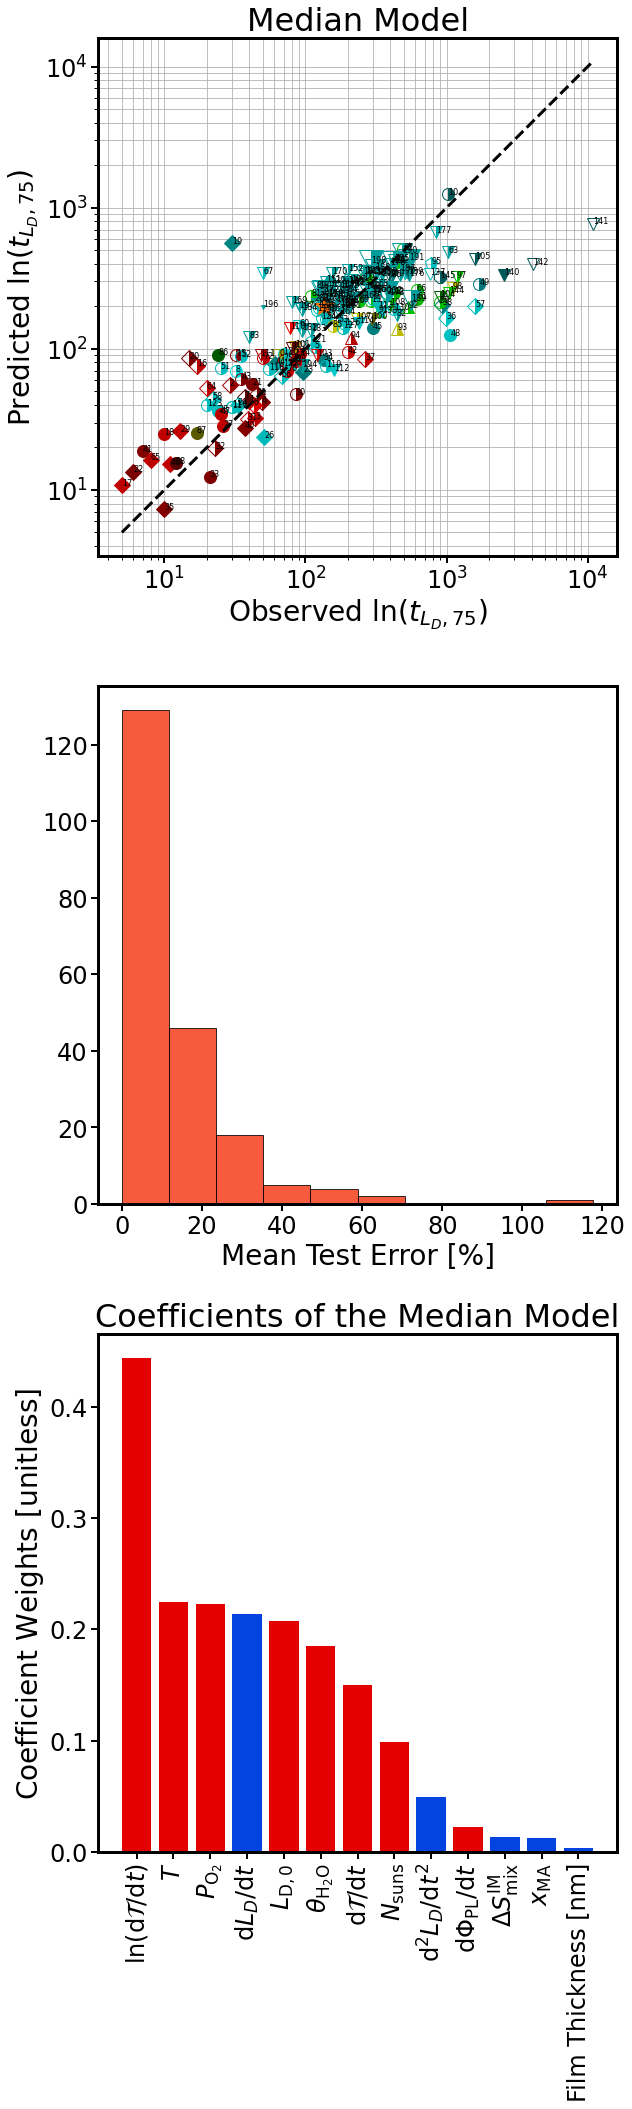

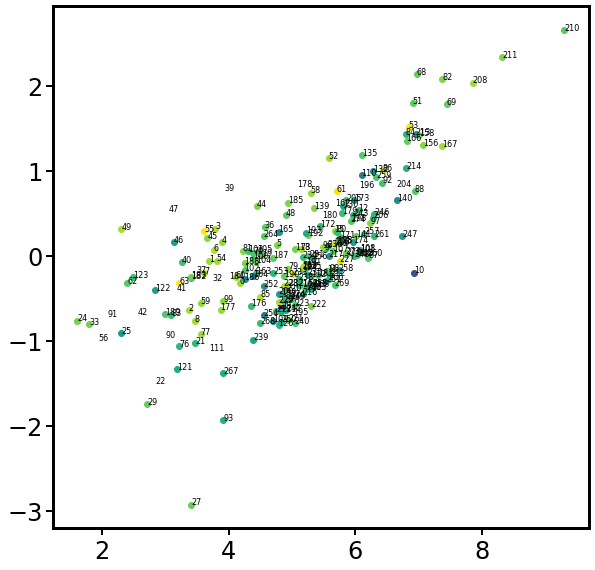

In [50]:
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import LogFormatter

# Make fancy plots of test set error 

# Set up the subplot parameters - again we want square panels not square subplots, so we do things manually
panel_size = 9 # absolute size of a single panel, inches(?)
n_plots_x = 3 # how many panels to plot in the x-direction
n_plots_y = 1 # how many panels to plot in the y-direction
aspect_ratio = n_plots_y/n_plots_x # overall aspect ratio of the figure
aspect_x = 1/n_plots_x
aspect_y = 1/n_plots_y


# turn panel labels (a,b,c,...) on or off
panel_labels = False

# create the figure
fig = plt.figure(figsize=(n_plots_x*panel_size,n_plots_y*panel_size))
ax_size = 0.8 # fraction of panel to plot axes
spacing = (1-ax_size)/2 # offset of axes from panel edge

ax = [] # initialize list of axes
for ii in range(n_plots_x):
    row_panel_list = []
    for jj in range(n_plots_y):
        row_panel_list.append(fig.add_axes([(jj+spacing)*aspect_x,1-(ii+1)*aspect_y+spacing*aspect_y, aspect_x*ax_size,aspect_y*ax_size]))
    ax.append(row_panel_list)



##### TOP LEFT: parity plot of median model
actual_all = []
preds_all = []
idxs_all = []

# plot training set
for ii in range(len(y_train)):
    idx = y_train.index[ii]
    T = rawdata_df['Temp (deg C)'][idx]
    RH = rawdata_df['RH (%)'][idx]
    pct_O2 = rawdata_df['Oxygen (%)'][idx]
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    MA_frac = rawdata_df['MA fraction'][idx]
    thick = rawdata_df['Film Thickness [nm]'][idx]
    encap = 'none'
    m_size = math.floor(thick/50)*2 + 2
    
    actual_all.append(y_train.loc[idx])
    preds_all.append(ytpred[ii])
    idxs_all.append(idx)
    if Log_transform:
        ax[0][0].loglog(np.exp(y_train.loc[idx]),np.exp(ytpred[ii]),
                        color=color,
                        marker=marker,
                        fillstyle=fill,linestyle=style,
                        markersize=m_size)

        if rawdata_df['MA fraction'][idx] == 0.95:
            ax[0][0].loglog(np.exp(y_train.loc[idx]),np.exp(ytpred[ii]),
                   marker='v',color='xkcd:white',markersize=8) 
        elif rawdata_df['MA fraction'][idx] == 0.975:
            ax[0][0].loglog(np.exp(y_train.loc[idx]),np.exp(ytpred[ii]),
                   marker='v',color='xkcd:white',markersize=4)
        elif rawdata_df['MA fraction'][idx] == 1.025:
            ax[0][0].loglog(np.exp(y_train.loc[idx]),np.exp(ytpred[ii]),
                   marker='^',color='xkcd:white',markersize=4)
        elif rawdata_df['MA fraction'][idx] == 1.05:
            ax[0][0].loglog(np.exp(y_train.loc[idx]),np.exp(ytpred[ii]),
                   marker='^',color='xkcd:white',markersize=8)        
    else:
        ax[0][0].plot(y_train.loc[idx],ytpred[ii],color=batch_colors[rawdata_df['BatchID'][idx]],
                      marker=batch_markers[rawdata_df['BatchID'][idx]],
                      fillstyle='full',linestyle=style,
                      markersize=m_size)

        if rawdata_df['MA fraction'][idx] == 0.95:
            ax[0][0].plot(y_train.loc[idx],ytpred[ii],
                   marker='v',color='xkcd:white',markersize=8) 
        elif rawdata_df['MA fraction'][idx] == 0.975:
            ax[0][0].plot(y_train.loc[idx],ytpred[ii],
                   marker='v',color='xkcd:white',markersize=4)
        elif rawdata_df['MA fraction'][idx] == 1.025:
            ax[0][0].plot(y_train.loc[idx],ytpred[ii],
                   marker='^',color='xkcd:white',markersize=4)
        elif rawdata_df['MA fraction'][idx] == 1.05:
            ax[0][0].plot(y_train.loc[idx],ytpred[ii],
                   marker='^',color='xkcd:white',markersize=8)

    ax[0][0].text(np.exp(y_train.loc[idx]),np.exp(ytpred[ii]),ii,fontsize=8)
# plot perfect prediction line and +/-50% error bounds (latter good for DOE presentations, bad for publications)
if Log_transform:
    plotRange = np.linspace(np.exp(np.min(y_train)),np.exp(np.max(y_train)),num=2)
    ax[0][0].plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
    formatter = LogFormatter(labelOnlyBase=False, minor_thresholds=(2, 0.4))
    ax[0][0].grid(which='both')
else:
    plotRange = np.linspace(np.min(y_train),np.max(y_train),num=101)
    ax[0][0].plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
#ax[0][0].plot(plotRange,plotRange+np.log(1.5),color='r',marker = ' ',linestyle='--')
#ax[0][0].plot(plotRange,plotRange+np.log(0.5),color='r',marker = ' ',linestyle='--')

# set appropriate axis labels and title
if response == 'tLD75 (min)':
    ax[0][0].set_xlabel('$\mathrm{Observed}\ \mathrm{ln}(t_{L_D,75}$)')
    ax[0][0].set_ylabel('$\mathrm{Predicted}\ \mathrm{ln}(t_{L_D,75}$)')
elif 'tLD80' in response:
    ax[0][0].set_xlabel('$\mathrm{Observed}\ t_{L_D,80}$  [min]')
    ax[0][0].set_ylabel('$\mathrm{Predicted}\ t_{L_D,80}$  [min]')
elif 'tLDmax' in response:
    ax[0][0].set_xlabel('$\mathrm{Observed}\ t_{L_D\mathrm{,max}}$  [min]')
    ax[0][0].set_ylabel('$\mathrm{Predicted}\ t_{L_D\mathrm{,max}}$  [min]')
elif 'tPLmax' in response:
    ax[0][0].set_xlabel('$\mathrm{Observed}\ t_{\mathrm{PL,max}}$  [min]')
    ax[0][0].set_ylabel('$\mathrm{Predicted}\ t_{\mathrm{PL,max}}$  [min]')
elif response == 'Bleach Rate (fit to 5% inc) (1/min)' :
    ax[0][0].set_xlabel('$\mathrm{Observed\ ln(Bleaching\ Rate})$')
    ax[0][0].set_ylabel('$\mathrm{Predicted\ ln(Bleaching\ Rate)}$')
elif response == 'tA80' :
    ax[0][0].set_xlabel('Observed $t_{A,80} [min]$')
    ax[0][0].set_ylabel('Predicted $t_{A,80} [min]$')
ax[0][0].set_title('Median Model')

# plot test data as above
for ii in range(len(y_whold)):
    idx = y_whold.index[ii]
    T = rawdata_df['Temp (deg C)'][idx]
    RH = rawdata_df['RH (%)'][idx]
    pct_O2 = rawdata_df['Oxygen (%)'][idx]
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    MA_frac = rawdata_df['MA fraction'][idx]
    thick = rawdata_df['Film Thickness [nm]'][idx]
    encap = 'none'
    m_size = math.floor(thick/50)*2 + 2
    
    actual_all.append(y_whold.loc[idx])
    preds_all.append(ypred[ii])
    idxs_all.append(idx)
    
    if Log_transform:
        ax[0][0].loglog(np.exp(y_whold[idx]),np.exp(ypred[ii]),
                        color=color,
                        marker=marker,
                        fillstyle=fill,linestyle=style,
                        markersize=m_size)

        if rawdata_df['MA fraction'][idx] == 0.95:
            ax[0][0].loglog(np.exp(y_whold[idx]),np.exp(ypred[ii]),
                   marker='v',color='xkcd:white',markersize=8) 
        elif rawdata_df['MA fraction'][idx] == 0.975:
            ax[0][0].loglog(np.exp(y_whold[idx]),np.exp(ypred[ii]),
                   marker='v',color='xkcd:white',markersize=4)
        elif rawdata_df['MA fraction'][idx] == 1.025:
            ax[0][0].loglog(np.exp(y_whold[idx]),np.exp(ypred[ii]),
                   marker='^',color='xkcd:white',markersize=4)
        elif rawdata_df['MA fraction'][idx] == 1.05:
            ax[0][0].loglog(np.exp(y_whold[idx]),np.exp(ypred[ii]),
                   marker='^',color='xkcd:white',markersize=8)
        # test sample in orange
        ax[0][0].loglog(np.exp(y_whold[idx]),np.exp(ypred[ii]),
                        marker='*',markersize=20,color='xkcd:orange')
    
    else:
        ax[0][0].plot(y_whold[idx],ypred[ii],color=color,
                        marker=marker,
                        fillstyle=fill,linestyle=style,
                      markersize=m_size)

        if rawdata_df['MA fraction'][idx] == 0.95:
            ax[0][0].plot(y_whold[idx],ypred[ii],
                   marker='v',color='xkcd:white',markersize=8) 
        elif rawdata_df['MA fraction'][idx] == 0.975:
            ax[0][0].plot(y_whold[idx],ypred[ii],
                   marker='v',color='xkcd:white',markersize=4)
        elif rawdata_df['MA fraction'][idx] == 1.025:
            ax[0][0].plot(y_whold[idx],ypred[ii],
                   marker='^',color='xkcd:white',markersize=4)
        elif rawdata_df['MA fraction'][idx] == 1.05:
            ax[0][0].plot(y_whold[idx],ypred[ii],
                   marker='^',color='xkcd:white',markersize=8)
        # test sample in orange
        ax[0][0].plot(y_whold[idx],ypred[ii],marker='*',markersize=20,color='xkcd:orange')

# plot legend for test sample
#if response == 'tLD75 (min)':
#    ax[0][0].plot(5,2,marker='*',markersize=20,color='xkcd:orange')
#    ax[0][0].text(5.2,1.98,'Test Sample',fontsize=20,weight='bold',color='xkcd:orange',va='center')
  
# calculate error metrics
actual_all = np.array(actual_all)
preds_all = np.array(preds_all)
R2_overall = r2_score(actual_all,preds_all)
MAE_pct_overall = np.abs((preds_all - actual_all)/preds_all)*100
    
# set text position for the approporiate response variable
if response == 'tLD75 (min)':
    text_x = 2
    text_y = 6
elif response == 'Bleach Rate (fit to 5% inc) (1/min)' :
    text_x = -9
    text_y = -4
    


##### BOTTOM LEFT: test set error distribution
ax[1][0].hist(MAE_pct,color='xkcd:vermillion',alpha=0.8,edgecolor='black',histtype='bar')
ax[1][0].set_xlabel('Mean Test Error [%]')
# ax[1][0].vlines(np.median(MAE_pct),0,np.max(np.histogram(MAE_pct)[0]),color='r',linestyle='--')
# ax[1][0].text(np.median(MAE_pct)+2,np.max(np.histogram(MAE_pct)[0]),
#               'Median: '+str(round(np.median(MAE_pct),2))+'%',color='r',va='top')
# ax[1][0].text(np.mean(MAE_pct)+2,0.9*np.max(np.histogram(MAE_pct)[0]),
#               'Mean: '+str(round(np.mean(MAE_pct),2))+'%',color='k',va='top')

##### BOTTOM RIGHT: coefficients of the median model

# identify the index corresponding to the median model
idx = np.argmin(np.abs(MAE_pct-np.median(MAE_pct)))
med_idx = idx # save the median index in a less ambiguous form
coeffs_med_model = coeffs_df.iloc[med_idx].values # extract corresponding coefficients

# assign bar colors to coefficient values
bar_colors_med_model = []
if response == 'Bleach Rate (fit to 5% inc) (1/min)':
    for jj in range(len(coeffs_med_model)):
        if np.sign(coeffs_med_model[jj]) == 1:
            bar_colors_med_model.append('xkcd:red')
        else:
            bar_colors_med_model.append('xkcd:blue')
else:
    for jj in range(len(coeffs_med_model)):
        if np.sign(coeffs_med_model[jj]) == 1:
            bar_colors_med_model.append('xkcd:blue')
        else:
            bar_colors_med_model.append('xkcd:red')

# make a DataFrame for bar plotting of the median model's coefficients
med_model_bars_df = pd.DataFrame(coeffs_med_model) 
med_model_bars_df = med_model_bars_df.rename(columns={0:'abs. values'})
med_model_bars_df['coeffs'] = coeffs_df.columns # get coefficient names
med_model_bars_df.index = coeffs # make the DF indices equal to the coefficient names
med_model_bars_df['colors'] = bar_colors_med_model # encode coefficient sign in bar color
med_model_bars_df['abs. values'] = np.abs(med_model_bars_df['abs. values'])
med_model_bars_df = med_model_bars_df.sort_values(by = 'abs. values', ascending=False) # sort the bars in descending order of mean

# identify the nonzero coefficients
sig_bars_med_model = med_model_bars_df[med_model_bars_df['abs. values'] > 0]

# redefine the fancy coefficients
fancy_labels=[]
for coeff in sig_bars_med_model['coeffs']:
    try:
        fancy_labels.append(fancy_labels_dict[coeff])
    except:
        fancy_labels.append(coeff)

# and make the plot
ax[2][0].bar(fancy_labels,sig_bars_med_model['abs. values'],color=sig_bars_med_model['colors'])
ax[2][0].set_xticklabels(fancy_labels,rotation=90)
ax[2][0].set_ylabel('$\mathrm{Coefficient\ Weights\ [unitless]}$')
ax[2][0].set_title('Coefficients of the Median Model')

# add grand title and panel labels if desired
#fig.suptitle('Early-Time + Linear Env\'t and Comp. Features', x=0.5, y=1, fontsize=48, weight='bold')
if panel_labels:
    fig.text(0,0.9,'a',fontsize=36,weight='bold')
    fig.text(0,-0.1,'b',fontsize=36,weight='bold')
    fig.text(0,-1.1,'c',fontsize=36,weight='bold')

### Uncomment the linest below to see corners of the figure
#fig.text(0,0,'(0,0)')
#fig.text(1,0,'(1,0)')
#fig.text(0,1,'(0,1)')
#fig.text(1,1,'(1,1)')

viridis = cm.get_cmap('viridis', 256)
c_min = np.nanmin(np.log(rawdata_df['Bleach Rate (polyfit) (1/min)']))
c_max = np.nanmax(np.log(rawdata_df['Bleach Rate (polyfit) (1/min)']))


d_fig, diag_ax = plt.subplots() # initialize axis for diagnostic plots
residuals = actual_all-preds_all

for ii in range(len(rawdata_df)):
    bleach_color = viridis((np.log(rawdata_df['Bleach Rate (polyfit) (1/min)'].iloc[ii]) - c_min)/(c_max-c_min)) 
    diag_ax.plot(actual_all[ii],residuals[ii],color=bleach_color,marker='.',linestyle=' ')
    diag_ax.text(actual_all[ii],residuals[ii],idxs_all[ii],fontsize=8)
diag_ax.set_xlabel('Observed Value $y$')
diag_ax.set_ylabel('Residuals $y\ - \hat{y}$')

std_resids = (residuals-np.mean(residuals))/np.std(residuals)
# initialize axis for qq plot
new_fig = plt.figure()
import statsmodels.api as sm
sm.qqplot(std_resids,line='45')


In [37]:
rawdata_df['Illum (Nsuns)']

0      16.0
1      32.0
2      32.0
3      32.0
4      32.0
5       8.0
6      32.0
7      32.0
8       8.0
9       8.0
10      8.0
11      8.0
12      8.0
13      8.0
14      8.0
15      8.0
18      8.0
19      8.0
20      8.0
21      8.0
22     32.0
23      8.0
24     32.0
25      8.0
26     32.0
27     32.0
28      8.0
29     32.0
30      8.0
31      8.0
32      8.0
33     32.0
34     32.0
35     32.0
36     32.0
37     32.0
38     32.0
39     32.0
40      8.0
41      8.0
42     32.0
43     32.0
44      8.0
45     32.0
46     32.0
47      8.0
48      8.0
49     32.0
50      8.0
51     32.0
52     32.0
53     32.0
54     32.0
55     32.0
56      8.0
57      8.0
58      8.0
59      8.0
60     32.0
61      8.0
62     32.0
63      8.0
64     32.0
65      8.0
66      8.0
67      8.0
68      8.0
69      8.0
70     32.0
75      8.0
76      8.0
77      8.0
78      8.0
79      8.0
80      8.0
81     32.0
82     32.0
83     32.0
84      8.0
85      1.0
86      8.0
87      8.0
88      1.0
89  

# 10. Make a Big Figure 4

Plot the most sophisticated physics-inspired models, using leave-one-out testing in the top row and normal operating conditions testing in the bottom row.

In [ ]:
# Start by initializing the figure: 3 x 3 square panels
panel_size = 15 # absolute size of a single panel, inches(?)
n_plots_x = 3 # how many panels to plot in the x-direction
n_plots_y = 2 # how many panels to plot in the y-direction
aspect_ratio = n_plots_y/n_plots_x # overall aspect ratio of the figure
aspect_x = 1/n_plots_x
aspect_y = 1/n_plots_y

# create the figure
fig = plt.figure(figsize=(n_plots_x*panel_size,n_plots_y*panel_size))
ax_size = 0.8 # fraction of panel to plot axes
spacing = (1-ax_size)/2 # offset of axes from panel edge

ax = [] # initialize list of axes
for ii in range(n_plots_y):
    row_panel_list = []
    for jj in range(n_plots_x):
        row_panel_list.append(fig.add_axes([(jj+spacing)*aspect_x,1-(ii+1)*aspect_y+spacing*aspect_y, aspect_x*ax_size,aspect_y*ax_size]))
    ax.append(row_panel_list) 
    
# Global size to use for figure markers
marker_size = 25

axis_lab_size = 36
title_size=48

##### TOP PANEL: parity plot for model with leave-one-out testing

# train the model
# first determine whether to do a log transform or not, then partition the data into features (X) and response (Y) DFs
if Log_transform:
    Y = np.log(np.abs(coded_df[response])).copy() # BE VERY CAREFUL NOT TO UNINTENTIONALLY CHANGE THE DATAFRAME
else:
    Y = coded_df[response].copy()
X = coded_df.drop(columns=response).copy()

# number of runs in dataset
n_trials = len(Y)


# set up search parameters for cross-validation, which will be used to select the hyperparameter
# range of hyperparameters to test
param_vals = np.logspace(-3,3,num=31)
parameters = {'alpha': param_vals}
# model to implement - LASSO, Ridge, etc.
model = Lasso(max_iter=1e8)
# scoring metric - MSE, R2, etc.
metric = 'neg_mean_squared_error'
# how many folds to do in k-fold cross-validation - 5 is standard
folds = n_trials-1

# feature sets to test: currently use only early time and early time + linear
feature_sets = [
                ['dTrdt','dLDdt','dPLdt',
                 'ddTr0','ddLD0','ddPL0',
                 'Ld1','Ld2','Ld3','Ld4','Ld5',
                 'Tr1','Tr2','Tr3','Tr4','Tr5',
                 'PL1','PL2','PL3','PL4','PL5',
                 'A','P_H2O','P_O2','D','E',
                 'PhotoOx_rate','Hydration_rate','delS_mix',]
                ]

# define metrics to keep track of for each feature set
performance_metrics = ['Mean Test Set Error (%)','Median Test Set Error (%)','Std Dev Test Set Error (%)',
                       'Mean Test Set Error','Median Test Set Error','Std Dev Test Set Error',
                       'Mean Training Set Error (%)','Median Training Set Error (%)','Std Dev Training Set Error (%)',
                       'Mean Training Set Error','Median Training Set Error','Std Dev Training Set Error',
                       'Mean Full Set Error (%)','Median Full Set Error (%)','Std Dev Full Set Error (%)',
                       'Mean Full Set Error','Median Full Set Error','Std Dev Full Set Error',
                       'Mean Training Set R2', 'Median Training Set R2','Std Dev Training Set R2',
                       'MA-Rich Error (%)','Balanced Error (%)','FACs-Rich Error (%)',
                       'MA-Rich R2 (%)','Balanced R2 (%)','FACs-Rich R2 (%)',
                      ]
performance_metalist = []

# keep track of coefficients
coeffs_DFs = []

# Loop over model echelons
for j, echelon in enumerate(feature_sets):
    
    # initialize the list of error/performance metrics
    performance_list = []
    
    X = coded_df.drop(columns=response).copy()
    X = X[echelon]
    
    # initialize error metrics for test set
    R2 = np.zeros(n_trials) # coefficient of determination
    RMSE = np.zeros(n_trials) # RMS error
    MAE_pct = np.zeros(n_trials) # mean absolute error, percent
    MAE = np.zeros(n_trials) # mean absolute error

    # for the whole dataset
    MAE_pct_overall = np.zeros(n_trials) # mean absolute error, percent
    MAE_overall = np.zeros(n_trials) # mean absolute error, percent
    R2_overall = np.zeros(n_trials) # coefficient of determination

    # for the training set
    MAE_pct_train = np.zeros(n_trials) # mean absolute error, percent
    MAE_train = np.zeros(n_trials) # mean absolute error, percent
    R2_train = np.zeros(n_trials) # coefficient of determination

    # error on linear scale
    linear_error = np.zeros(n_trials)

    # initialize a dataframe to keep track of model coefficients
    coeffs_df = pd.DataFrame(columns=X.columns)

    # Loop over test sets
    for kk in range(n_trials):
    
    
        # Partition the TT split
        X_whold = X.iloc[kk].copy()
        y_whold = Y.iloc[kk:kk+1].copy()
        X_train = X.drop(X.index[kk]).copy()
        y_train = Y.drop(X.index[kk]).copy()

        # standardize the data according to the mean and variance of the training dataset
        for col in X_train.columns:
            # get mean and variance of features in the test set
            col_mean = np.mean(X_train[col])
            col_std = np.std(X_train[col])
            # standardize the features in the training set
            z_train = (X_train[col] - col_mean)/col_std
            X_train[col] = z_train
            # standardize the features in the test set
            z_whold = (X_whold[col] - col_mean)/col_std
            X_whold[col] = z_whold

        # cross-validation step to set alpha/lambda/penalty hyperparameter
        regressor = GridSearchCV(model,parameters,scoring=metric,cv=folds)
        regressor.fit(X_train,y_train)

        # print winning HP value if desired...
        print(regressor.best_params_)
        #print(regressor.best_score_)
        alpha = regressor.best_params_['alpha']

        # and retrain the final model on the full training set
        final_model = Lasso(alpha=alpha)
        final_model.fit(X_train,y_train)
        #print(final_model.coef_)

        # make predictions on the test and training data
        ypred=final_model.predict(np.array(X_whold).reshape(1,-1))
        ytpred=final_model.predict(X_train)

        # calculate error metrics on test set
        RMSE[kk] = np.sqrt(metrics.mean_squared_error(np.array(y_whold).reshape(1,-1), ypred))
        R2[kk] = metrics.r2_score(np.array(y_whold).reshape(1,-1), ypred)
        MAE_pct[kk] = np.mean(np.abs(y_whold-ypred)/np.abs(y_whold)*100)
        MAE[kk] = np.mean(np.abs(y_whold-ypred))

        # put the whole dataset back together (note that this will create arrays, not DFs)
        y_net = np.concatenate([y_train,y_whold])
        y_pred_net = np.concatenate([ytpred,ypred])

        # calculate error metrics on entire set
        R2_overall[kk] = metrics.r2_score(y_net, y_pred_net)
        MAE_overall[kk] = np.mean(np.abs(y_net-y_pred_net))
        MAE_pct_overall[kk] = np.mean(np.abs(y_net-y_pred_net)/np.abs(y_net)*100)

        # calculate error metrics on training set
        R2_train[kk] = metrics.r2_score(y_train, ytpred)
        MAE_train[kk] = np.mean(np.abs(y_train-ytpred))
        MAE_pct_train[kk] = np.mean(np.abs(y_train-ytpred)/np.abs(y_train)*100)

        linear_error[kk] = np.abs(np.exp(y_whold) -  np.exp(ypred))/np.exp(y_whold)*100

    
        # save the model coefficients
        coeffs_df = coeffs_df.append(pd.DataFrame(final_model.coef_.reshape(1,len(final_model.coef_)),columns=X.columns))
        
        # Save coefficients and error metrics
        
    # append performance metrics for the test set
    performance_list.append(np.mean(MAE_pct))
    performance_list.append(np.median(MAE_pct))
    performance_list.append(np.std(MAE_pct))
    performance_list.append(np.mean(MAE))
    performance_list.append(np.median(MAE))
    performance_list.append(np.std(MAE))
    # append performance metrics for the training set
    performance_list.append(np.mean(MAE_pct_train))
    performance_list.append(np.median(MAE_pct_train))
    performance_list.append(np.std(MAE_pct_train))    
    performance_list.append(np.mean(MAE_train))
    performance_list.append(np.median(MAE_train))
    performance_list.append(np.std(MAE_train))
    # append performance metrics for the full set
    performance_list.append(np.mean(MAE_pct_overall))
    performance_list.append(np.median(MAE_pct_overall))
    performance_list.append(np.std(MAE_pct_overall))
    performance_list.append(np.mean(MAE_overall))
    performance_list.append(np.median(MAE_overall))
    performance_list.append(np.std(MAE_overall))
    # append training set R2
    performance_list.append(np.mean(R2_train))
    performance_list.append(np.median(R2_train))
    performance_list.append(np.std(R2_train))
    
    # append dataframe of coefficients
    coeffs_DFs.append(coeffs_df)
        
    # Find the median model and train it
    idx = np.argmin(np.abs(MAE_pct-np.median(MAE_pct)))
    print(idx)
    
    kk = idx
    X_whold = X.iloc[kk].copy()
    y_whold = Y.iloc[kk:kk+1].copy()
    X_train = X.drop(X.index[kk]).copy()
    y_train = Y.drop(X.index[kk]).copy()

    # standardize the data according to the mean and variance of the training dataset
    for col in X_train.columns:
        # get mean and variance of features in the test set
        col_mean = np.mean(X_train[col])
        col_std = np.std(X_train[col])
        # standardize the features in the training set
        z_train = (X_train[col] - col_mean)/col_std
        X_train[col] = z_train
        # standardize the features in the test set
        z_whold = (X_whold[col] - col_mean)/col_std
        X_whold[col] = z_whold

    # cross-validation step to set alpha/lambda/penalty hyperparameter
    regressor = GridSearchCV(model,parameters,scoring=metric,cv=folds)
    regressor.fit(X_train,y_train)

    # print winning HP value if desired...
    #print(regressor.best_params_)
    #print(regressor.best_score_)
    alpha = regressor.best_params_['alpha']

    # and retrain the final model on the full training set
    final_model = Lasso(alpha=alpha)
    final_model.fit(X_train,y_train)
    #print(final_model.coef_)

    # make predictions on the test and training data
    ypred=final_model.predict(np.array(X_whold).reshape(1,-1))
    ytpred=final_model.predict(X_train)
    
    # save the model coefficients
    coeffs_df = coeffs_df.append(pd.DataFrame(final_model.coef_.reshape(1,len(final_model.coef_)),columns=X.columns))    
    
    # convert labels "A", "B", etc. back to physically meaningful names
    new_dict = {
        "A":"Temp",
        "B":"RH",
        'C':'O2',
        'D':'Nsuns',
        'E':'MA_frac'
    }
    coeffs_df.rename(columns = new_dict, inplace = True)

    coeffs = coeffs_df.columns # save coefficient names
    
    
    # Plot the median model's coefficients in the middle panel
    # ax[j][1].plot(...)
    # identify the index corresponding to the median model
    idx = np.argmin(np.abs(MAE_pct-np.median(MAE_pct)))
    med_idx = idx # save the median index in a less ambiguous form
    coeffs_med_model = coeffs_df.iloc[med_idx].values # extract corresponding coefficients

    # assign bar colors to coefficient values
    bar_colors_med_model = []
    if response == 'Bleach Rate (fit to 5% inc) (1/min)':
        for jj in range(len(coeffs_med_model)):
            if np.sign(coeffs_med_model[jj]) == 1:
                bar_colors_med_model.append('xkcd:red')
            else:
                bar_colors_med_model.append('xkcd:blue')
    else:
        for jj in range(len(coeffs_med_model)):
            if np.sign(coeffs_med_model[jj]) == 1:
                bar_colors_med_model.append('xkcd:blue')
            else:
                bar_colors_med_model.append('xkcd:red')

    # make a DataFrame for bar plotting of the median model's coefficients
    med_model_bars_df = pd.DataFrame(coeffs_med_model) 
    med_model_bars_df = med_model_bars_df.rename(columns={0:'abs. values'})
    med_model_bars_df['coeffs'] = coeffs_df.columns # get coefficient names
    med_model_bars_df.index = coeffs_df.columns # make the DF indices equal to the coefficient names
    med_model_bars_df['colors'] = bar_colors_med_model # encode coefficient sign in bar color
    med_model_bars_df['abs. values'] = np.abs(med_model_bars_df['abs. values'])
    med_model_bars_df = med_model_bars_df.sort_values(by = 'abs. values', ascending=False) # sort the bars in descending order of mean

    # identify the nonzero coefficients
    sig_bars_med_model = med_model_bars_df[med_model_bars_df['abs. values'] > 0]
    
    fancy_labels_dict = {'dTrdt':'$\mathrm{d}\mathcal{T}/\mathrm{d}t$',
                     'dLDdt':'$\mathrm{d}L_D/\mathrm{d}t$',
                     'dPLdt':'$\mathrm{d}\Phi_\mathrm{PL}/\mathrm{d}t$',
                     'ddTr0':'$\mathrm{d^2}\mathcal{T}/\mathrm{d}t^2$',
                     'ddLD0':'$\mathrm{d}^2L_D/\mathrm{d}t^2$',
                     'ddPL0':'$\mathrm{d^2}\Phi_\mathrm{PL}/\mathrm{d}t^2$',
                     'Ld1':'$L_{\mathrm{D},t=1}$',
                     'Ld2':'$L_{\mathrm{D},t=2}$',
                     'Ld3':'$L_{\mathrm{D},t=3}$',
                     'Ld4':'$L_{\mathrm{D},t=4}$',
                     'Ld5':'$L_{\mathrm{D},t=5}$',
                     'Tr1':'$\mathcal{T}_{t=1}$',
                     'Tr2':'$\mathcal{T}_{t=2}$',
                     'Tr3':'$\mathcal{T}_{t=3}$',
                     'Tr4':'$\mathcal{T}_{t=4}$',
                     'Tr5':'$\mathcal{T}_{t=5}$',
                     'PL1':'$\Phi_{\mathrm{PL},t=1}$',
                     'PL2':'$\Phi_{\mathrm{PL},t=2}$',
                     'PL3':'$\Phi_{\mathrm{PL},t=3}$',
                     'PL4':'$\Phi_{\mathrm{PL},t=4}$',
                     'PL5':'$\Phi_{\mathrm{PL},t=5}$',
                     'Temp':'$T$',
                     'P_H2O':'$P_\mathrm{H_2O}$',
                     'P_O2':'$P_\mathrm{O_2}$',
                     'Nsuns':'$N_\mathrm{suns}$',
                     'MA_frac':'$x_\mathrm{MA}$',
                     'PhotoOx_rate':'$\dot{R}_\mathrm{PhOx}$',
                     'Hydration_rate':'$\\theta_\mathrm{H_2O}$',
                     'Ox_rate':'$\dot{R}_\mathrm{Ox}$',
                     'delS_mix':'$\Delta S^\mathrm{IM}_\mathrm{mix}$',
                     'LAI_O2':'$\\theta_\mathrm{O_2}$',
                     'Ox_rate_LAI':'$\\theta_\mathrm{O_2}\mathrm{exp}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                     'Ox_rate_P':'$P_\mathrm{O_2}\mathrm{exp}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                     'Arrhenius_Ox':'$\mathrm{exp}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                     'PhOx_rate_P':'$P_\mathrm{O_2}\mathrm{exp}N_\mathrm{suns}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                    }
    
    # redefine the fancy coefficients
    fancy_labels=[]
    for coeff in sig_bars_med_model['coeffs']:
        fancy_labels.append(fancy_labels_dict[coeff])

    # and make the plot
    ax[j][1].bar(fancy_labels,sig_bars_med_model['abs. values'],color=sig_bars_med_model['colors'])
    ax[j][1].set_xticklabels(fancy_labels,rotation=90,fontsize=axis_lab_size)
    ax[j][1].set_ylabel('$\mathrm{Coefficient\ Weights\ [unitless]}$',fontsize=axis_lab_size)
    ax[j][1].set_title('Coefficients of the Median Model',fontsize=title_size)
    
    # Plot the test set error histogram in the right panel
    # ax[j][2].hist(...)
    ax[j][2].hist(MAE_pct,color='xkcd:cerulean',alpha=0.8,edgecolor='black',histtype='bar')
    ax[j][2].set_xlabel('Mean Test Error [%]',fontsize=axis_lab_size)
    ax[j][2].set_ylabel('Frequency',fontsize=axis_lab_size)
    ax[j][2].set_title('Histogram of Testing Error',fontsize=title_size)
    ax[j][2].vlines(np.median(MAE_pct),0,np.max(np.histogram(MAE_pct)[0]),color='r',linestyle='--')
    ax[j][2].text(np.median(MAE_pct)+2,np.max(np.histogram(MAE_pct)[0]),
                  'Median: '+str(round(np.median(MAE_pct),2))+'%',color='r',va='top',fontsize=40)
    ax[j][2].text(np.mean(MAE_pct)+2,0.9*np.max(np.histogram(MAE_pct)[0]),
                  'Mean: '+str(round(np.mean(MAE_pct),2))+'%',color='k',va='top',fontsize=40)

    # Plot the median model, indexed by environment, in the bottom row
    # ax[2][j].plot(...)
    for ii in range(len(y_train)):
        idx = y_train.index[ii]
        T = rawdata_df['Temp (deg C)'][idx]
        RH = rawdata_df['RH (%)'][idx]
        pct_O2 = rawdata_df['Oxygen (%)'][idx]
        N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
        color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
        MA_frac = rawdata_df['MA fraction'][idx]
        ax[j][0].plot(y_train.loc[idx],ytpred[ii],color=color,marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

    # plot perfect prediction line and +/-50% error bounds
    plotRange = np.linspace(1,7.5,num=101)
    ax[j][0].plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
    #plt.plot(plotRange,plotRange+np.log(1.5),color='r',marker = ' ',linestyle='--')
    #plt.plot(plotRange,plotRange+np.log(0.5),color='r',marker = ' ',linestyle='--')
    
    # set axis labels
    ax[j][0].set_xlabel('Observed ln($t_{L_D,75}$)',fontsize=axis_lab_size)
    ax[j][0].set_ylabel('Predicted ln($t_{L_D,75}$)',fontsize=axis_lab_size)
    
    # set axis limits
    ax[j][0].set_xlim([0.5,8])
    ax[j][0].set_ylim([0.5,8])
    
    # plot legend for test sample
    ax[j][0].plot(4,1.5,marker='*',markersize=30,color='xkcd:orange')
    ax[j][0].text(4.2,1.48,'Test Sample',fontsize=40,weight='bold',color='xkcd:orange',va='center')
    

    # plot test data as above
    for ii in range(len(y_whold)):
        idx = y_whold.index[ii]
        T = rawdata_df['Temp (deg C)'][idx]
        RH = rawdata_df['RH (%)'][idx]
        pct_O2 = rawdata_df['Oxygen (%)'][idx]
        N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
        color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
        MA_frac = rawdata_df['MA fraction'][idx]
        ax[j][0].plot(y_whold[idx],ypred[ii],color=color,marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)
        ax[j][0].plot(y_whold[idx],ypred[ii],marker='*',markersize=marker_size,color='xkcd:orange')

###### BOTTOM ROW: plot the model trained on accelerated testing conditions tested on normal operating conditions

# find indices in the mother dataframe corresponding to 1 sun test conditions,
# which we definte  as "normal operating conditions"
NOP_indices = rawdata_df[rawdata_df['Illum (Nsuns)'] == 1].index

# try some machine learning in this cell - LASSO with leave one out testing [test cell]
# DISCLAIMER: be very careful when mixing pandas and sklearn - some of the canned functions from sklearn take in 
# DataFrames but spit out arrays. Indexing can become a mess if rows have been removed from the DF during data cleaning
# because the indices will no longer sync up between the DFs and the output array. (This can happen when using the 
# .dropna() method to remove runs that do not go to LD,75, for instance.) 

# first determine whether to do a log transform or not, then partition the data into features (X) and response (Y) DFs
if Log_transform:
    Y = np.log(np.abs(coded_df[response])).copy() # BE VERY CAREFUL NOT TO UNINTENTIONALLY CHANGE THE DATAFRAME
else:
    Y = coded_df[response].copy()
X = coded_df.drop(columns=response).copy()

# number of runs in dataset
n_trials = 1
#n_trials=5

# set up search parameters for cross-validation, which will be used to select the hyperparameter
# range of hyperparameters to test
param_vals = np.logspace(-3,3,num=31)
parameters = {'alpha': param_vals}
# model to implement - LASSO, Ridge, etc.
model = Lasso(max_iter=1e9)
# scoring metric - MSE, R2, etc.
metric = 'neg_mean_squared_error'
# how many folds to do in k-fold cross-validation - 5 is standard
folds = len(Y) - len(NOP_indices)- 1

# initialize error metrics for test set
R2 = np.zeros(n_trials) # coefficient of determination
RMSE = np.zeros(n_trials) # RMS error
MAE_pct = np.zeros(n_trials) # mean absolute error, percent
MAE = np.zeros(n_trials) # mean absolute error

# for the whole dataset
MAE_pct_overall = np.zeros(n_trials) # mean absolute error, percent
MAE_overall = np.zeros(n_trials) # mean absolute error, percent
R2_overall = np.zeros(n_trials) # coefficient of determination

# for the training set
MAE_pct_train = np.zeros(n_trials) # mean absolute error, percent
MAE_train = np.zeros(n_trials) # mean absolute error, percent
R2_train = np.zeros(n_trials) # coefficient of determination

# initialize a dataframe to keep track of model coefficients
coeffs_df = pd.DataFrame(columns=coded_df.drop(columns=response).columns)

kk = 0

# Recalculate NOP indices based on which runs make it through the dropna() filter
NOP_indices = coded_df.loc[NOP_indices].dropna().index

# And do test-train split
X_whold = X.loc[NOP_indices].copy()
y_whold = Y.loc[NOP_indices].copy()
X_train = X.drop(index=NOP_indices).copy()
y_train = Y.drop(index=NOP_indices).copy()

# standardize the data according to the mean and variance of the training dataset
z_means = []
z_stds = []

for col in X_train.columns:
    # get mean and variance of features in the test set
    col_mean = np.mean(X_train[col])
    col_std = np.std(X_train[col])
    print(col_mean)
    z_means.append(col_mean)
    z_stds.append(col_std)
    # standardize the features in the training set
    z_train = (X_train[col] - col_mean)/col_std
    X_train[col] = z_train
    # standardize the features in the test set
    z_whold = (X_whold[col] - col_mean)/col_std
    X_whold[col] = z_whold


# cross-validation step to set alpha/lambda/penalty hyperparameter
regressor = GridSearchCV(model,parameters,scoring=metric,cv=folds)
regressor.fit(X_train,y_train)

# print winning HP value if desired...
print(regressor.best_params_)
#print(regressor.best_score_)
alpha = regressor.best_params_['alpha']

# and retrain the final model on the full training set
final_model = Lasso(alpha=alpha)
final_model.fit(X_train,y_train)
#print(final_model.coef_)

# make predictions on the test and training data
#ypred=final_model.predict(np.array(X_whold).reshape(1,-1)) # when test set is a single sample
ypred=final_model.predict(np.array(X_whold)) # when test set n > 1
ytpred=final_model.predict(X_train)

# calculate error metrics on test set
#RMSE[kk] = np.sqrt(metrics.mean_squared_error(np.array(y_whold).reshape(1,-1), ypred))
#R2[kk] = metrics.r2_score(np.array(y_whold).reshape(1,-1), ypred)
RMSE[kk] = np.sqrt(metrics.mean_squared_error(np.array(y_whold), ypred))
R2[kk] = metrics.r2_score(np.array(y_whold), ypred)
MAE_pct[kk] = np.mean(np.abs(y_whold-ypred)/np.abs(y_whold)*100)
MAE[kk] = np.mean(np.abs(y_whold-ypred))

# put the whole dataset back together (note that this will create arrays, not DFs)
y_net = np.concatenate([y_train,y_whold])
y_pred_net = np.concatenate([ytpred,ypred])

# calculate error metrics on entire set
R2_overall[kk] = metrics.r2_score(y_net, y_pred_net)
MAE_overall[kk] = np.mean(np.abs(y_net-y_pred_net))
MAE_pct_overall[kk] = np.mean(np.abs(y_net-y_pred_net)/np.abs(y_net)*100)

# calculate error metrics on training set
R2_train[kk] = metrics.r2_score(y_train, ytpred)
MAE_train[kk] = np.mean(np.abs(y_train-ytpred))
MAE_pct_train[kk] = np.mean(np.abs(y_train-ytpred)/np.abs(y_train)*100)

# plot training data with markers corresponding to environmental + compositional conditions

plt.figure(figsize=(10,10))
for ii in range(len(y_train)):
    idx = y_train.index[ii]
    T = rawdata_df['Temp (deg C)'][idx]
    RH = rawdata_df['RH (%)'][idx]
    pct_O2 = rawdata_df['Oxygen (%)'][idx]
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    MA_frac = rawdata_df['MA fraction'][idx]
    ax[1][0].plot(y_train.loc[idx],ytpred[ii],color=color,marker=marker,markersize=marker_size,fillstyle=fill,linestyle=style)

# plot perfect prediction line and +/-50% error bounds
plotRange = np.linspace(np.min(y_train),np.max(y_train),num=101)
ax[1][0].plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
#plt.plot(plotRange,plotRange+np.log(1.5),color='r',marker = ' ',linestyle='--')
#plt.plot(plotRange,plotRange+np.log(0.5),color='r',marker = ' ',linestyle='--')

ax[1][0].set_xlabel('Observed ln($t_{L_D,75}$)',fontsize=axis_lab_size)
ax[1][0].set_ylabel('Predicted ln($t_{L_D,75}$)',fontsize=axis_lab_size)

# plot test data as above
for ii in range(len(y_whold)):
    idx = y_whold.index[ii]
    T = rawdata_df['Temp (deg C)'][idx]
    RH = rawdata_df['RH (%)'][idx]
    pct_O2 = rawdata_df['Oxygen (%)'][idx]
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    MA_frac = rawdata_df['MA fraction'][idx]
    ax[1][0].plot(y_whold[idx],ypred[ii],color=color,marker=marker,markersize=marker_size,fillstyle=fill,linestyle=style)
    ax[1][0].plot(y_whold[idx],ypred[ii],marker='*',markersize=30,color='xkcd:orange')                

# save the model coefficients
coeffs_df = coeffs_df.append(pd.DataFrame(final_model.coef_.reshape(1,len(final_model.coef_)),columns=coded_df.drop(columns=response).columns))

coeffs_df.rename(columns = new_dict, inplace = True)
try:
    coeffs_df.rename(columns = second_order_dict, inplace = True)
except:
    pass

coeffs = coeffs_df.columns

avgs = np.mean(coeffs_df)
error = np.std(coeffs_df)

bar_colors = []
if response == 'Bleach Rate (fit to 5% inc) (1/min)':
    for jj in range(len(coeffs)):
        if np.sign(avgs[jj]) == 1:
            bar_colors.append('xkcd:red')
        else:
            bar_colors.append('xkcd:blue')
else:
    for jj in range(len(coeffs)):
        if np.sign(avgs[jj]) == 1:
            bar_colors.append('xkcd:blue')
        else:
            bar_colors.append('xkcd:red')

bars_df = pd.DataFrame(avgs)
bars_df = bars_df.rename(columns={0:'avgs'})
bars_df['coeffs'] = bars_df.index
bars_df['avgs'] = np.abs(bars_df['avgs'])
bars_df['error'] = error
bars_df['colors'] = bar_colors
bars_df = bars_df.sort_values(by = 'avgs', ascending=False)

# reduced dataframe of only coefficients with nonvanishing magnitude
nz_bars_df = bars_df[bars_df['avgs'] > 0]

# further reduced dataframe of only coefficients whose average is larger than their std. dev.
sig_bars_df = nz_bars_df[nz_bars_df['avgs'] > nz_bars_df['error']]

fancy_labels_dict = {'dTrdt':'$\mathrm{d}\mathcal{T}/\mathrm{d}t$',
                     'dLDdt':'$\mathrm{d}L_D/\mathrm{d}t$',
                     'dPLdt':'$\mathrm{d}\Phi_\mathrm{PL}/\mathrm{d}t$',
                     'ddTr0':'$\mathrm{d^2}\mathcal{T}/\mathrm{d}t^2$',
                     'ddLD0':'$\mathrm{d}^2L_D/\mathrm{d}t^2$',
                     'ddPL0':'$\mathrm{d^2}\Phi_\mathrm{PL}/\mathrm{d}t^2$',
                     'Ld1':'$L_{\mathrm{D},t=1}$',
                     'Ld2':'$L_{\mathrm{D},t=2}$',
                     'Ld3':'$L_{\mathrm{D},t=3}$',
                     'Ld4':'$L_{\mathrm{D},t=4}$',
                     'Ld5':'$L_{\mathrm{D},t=5}$',
                     'Tr1':'$\mathcal{T}_{t=1}$',
                     'Tr2':'$\mathcal{T}_{t=2}$',
                     'Tr3':'$\mathcal{T}_{t=3}$',
                     'Tr4':'$\mathcal{T}_{t=4}$',
                     'Tr5':'$\mathcal{T}_{t=5}$',
                     'PL1':'$\Phi_{\mathrm{PL},t=1}$',
                     'PL2':'$\Phi_{\mathrm{PL},t=2}$',
                     'PL3':'$\Phi_{\mathrm{PL},t=3}$',
                     'PL4':'$\Phi_{\mathrm{PL},t=4}$',
                     'PL5':'$\Phi_{\mathrm{PL},t=5}$',
                     'Temp':'$T$',
                     'P_H2O':'$P_\mathrm{H_2O}$',
                     'P_O2':'$P_\mathrm{O_2}$',
                     'Nsuns':'$N_\mathrm{suns}$',
                     'MA_frac':'$x_\mathrm{MA}$',
                     'PhotoOx_rate':'$\dot{R}_\mathrm{PhOx}$',
                     'Hydration_rate':'$\\theta_\mathrm{H_2O}$',
                     'Ox_rate':'$\dot{R}_\mathrm{Ox}$',
                     'delS_mix':'$\Delta S^\mathrm{IM}_\mathrm{mix}$',
                     'LAI_O2':'$\\theta_\mathrm{O_2}$',
                     'Ox_rate_LAI':'$\\theta_\mathrm{O_2}\mathrm{exp}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                     'Ox_rate_P':'$P_\mathrm{O_2}\mathrm{exp}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                     'Arrhenius_Ox':'$\mathrm{exp}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                     'PhOx_rate_P':'$P_\mathrm{O_2}\mathrm{exp}N_\mathrm{suns}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                    }

fancy_labels=[]
for coeff in sig_bars_df['coeffs']:
    fancy_labels.append(fancy_labels_dict[coeff])
    
ax[1][1].bar(sig_bars_df['coeffs'],sig_bars_df['avgs'],yerr=sig_bars_df['error'],color=sig_bars_df['colors'])
ax[1][1].set_xticklabels(labels=fancy_labels,rotation=90,fontsize=axis_lab_size)

ax[1][1].set_ylabel('$\mathrm{Coefficient\ Weights\ [unitless]}$',fontsize=axis_lab_size)
ax[1][1].set_title('Model Coefficients',fontsize=title_size)

# plot the symbol legend
ax[1][2].axis('off') # no bounding box
ax[1][2].set_xlim([0,10]) # set grid for plotting symbols on
ax[1][2].set_ylim([0,10]) 

origin = (1,7) # corner to start plotting from
pitch = 1.5 # spacing between symbols

# plot temperature/humidity symbols, defined by color
pct_O2 = 21
N_suns_stress = 8
for ii in range(4): # iterate over 4 temps
    for jj in range(5): # iterate over 5 RHs
        T = 25 + ii*20
        RH = jj*20

        color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)

        ax[1][2].plot(origin[0]+ii*pitch,origin[1]-jj*pitch,color=color,marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# plot temp legends
ax[1][2].text(origin[0],origin[1]+0.5*pitch,'25 $\degree$C',fontsize=20,ha='center',va='center')
ax[1][2].text(origin[0]+pitch,origin[1]+0.5*pitch,'45 $\degree$C',fontsize=20,ha='center',va='center')
ax[1][2].text(origin[0]+2*pitch,origin[1]+0.5*pitch,'65 $\degree$C',fontsize=20,ha='center',va='center')
ax[1][2].text(origin[0]+3*pitch,origin[1]+0.5*pitch,'85 $\degree$C',fontsize=20,ha='center',va='center')
ax[1][2].text(origin[0]+1.5*pitch,origin[1]+pitch,'Temperature',fontsize=25,ha='center',va='center')

# plot RH legends
ax[1][2].text(origin[0]-0.25*pitch,origin[1],'0%',fontsize=20,ha='right',va='center')
ax[1][2].text(origin[0]-0.25*pitch,origin[1]-pitch,'20%',fontsize=20,ha='right',va='center')
ax[1][2].text(origin[0]-0.25*pitch,origin[1]-2*pitch,'40%',fontsize=20,ha='right',va='center')
ax[1][2].text(origin[0]-0.25*pitch,origin[1]-3*pitch,'60%',fontsize=20,ha='right',va='center')
ax[1][2].text(origin[0]-0.25*pitch,origin[1]-4*pitch,'80%',fontsize=20,ha='right',va='center')
ax[1][2].text(origin[0]-1.125*pitch,origin[1]-2*pitch,'Relative Humidity',fontsize=25,ha='center',va='center',rotation=90)

# plot illumination symbols, defined by shape
T = 25
RH = 60

ill_x = 4 # how many pitches "east" of the origin to plot illumination symbols

# dark: pentagons
N_suns_stress = 0
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[1][2].plot(origin[0]+ill_x*pitch,origin[1],color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# 1 sun: inverted triangles
N_suns_stress = 1
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[1][2].plot(origin[0]+ill_x*pitch,origin[1]-pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# 8 suns: circles
N_suns_stress = 8
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[1][2].plot(origin[0]+ill_x*pitch,origin[1]-2*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# 16 suns: squares
N_suns_stress = 16
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[1][2].plot(origin[0]+ill_x*pitch,origin[1]-3*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# 32 suns: diamonds
N_suns_stress = 32
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[1][2].plot(origin[0]+ill_x*pitch,origin[1]-4*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# plot illumination legends
ax[1][2].text(origin[0]+(ill_x-0.2)*pitch,origin[1]+1.25,'Illumination',rotation=45,fontsize=25,va='bottom')
ax[1][2].text(origin[0]+ill_x*pitch,origin[1]+0.5*pitch,'0 suns',fontsize=20,ha='center',va='center')
ax[1][2].text(origin[0]+ill_x*pitch,origin[1]-0.5*pitch,'1 sun',fontsize=20,ha='center',va='center')
ax[1][2].text(origin[0]+ill_x*pitch,origin[1]-1.5*pitch,'8 suns',fontsize=20,ha='center',va='center')
ax[1][2].text(origin[0]+ill_x*pitch,origin[1]-2.5*pitch,'16 suns',fontsize=20,ha='center',va='center')
ax[1][2].text(origin[0]+ill_x*pitch,origin[1]-3.5*pitch,'32 suns',fontsize=20,ha='center',va='center')

# plot atmosphere symbols, defined by fill
atm_x = 5 # how many pitches "east" of orign to plot atmosphere symbols

N_suns_stress = 8

# N2: open symbols
pct_O2 = 0
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[1][2].plot(origin[0]+atm_x*pitch,origin[1]-1*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# air: half-filled symbols
pct_O2 = 21
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[1][2].plot(origin[0]+atm_x*pitch,origin[1]-2*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# O2: filled symbols
pct_O2 = 100
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[1][2].plot(origin[0]+atm_x*pitch,origin[1]-3*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# plot O2 legends
ax[1][2].text(origin[0]+(atm_x-0.2)*pitch,origin[1],'Atmosphere',rotation=45,fontsize=25,va='bottom')
ax[1][2].text(origin[0]+atm_x*pitch,origin[1]-0.5*pitch,'N$_2$',fontsize=20,ha='center',va='center')
ax[1][2].text(origin[0]+atm_x*pitch,origin[1]-1.5*pitch,'Air',fontsize=20,ha='center',va='center')
ax[1][2].text(origin[0]+atm_x*pitch,origin[1]-2.5*pitch,'O$_2$',fontsize=20,ha='center',va='center')

# set full legend title
ax[1][2].text(origin[0]+2.5*pitch,origin[1]+1.75*pitch,'Symbol Legend',fontsize=32,ha='center',weight='bold')

# row titles
fig.text(-0.02, 3/4, 'Leave-One-Out Testing', fontsize=48, rotation=90, ha='center', va='center')
fig.text(-0.02, 1/4, 'Normal Op. Cond. Testing', fontsize=48, rotation=90, ha='center', va='center')

# panel labels
v_offset = 0.02
fig.text(0,1-v_offset,'a',fontsize=60,weight='bold')
fig.text(1/3,1-v_offset,'b',fontsize=60,weight='bold')
fig.text(2/3,1-v_offset,'c',fontsize=60,weight='bold')
fig.text(0,1/2-v_offset,'d',fontsize=60,weight='bold')
fig.text(1/3,1/2-v_offset,'e',fontsize=60,weight='bold')
fig.text(2/3,1/2-v_offset,'f',fontsize=60,weight='bold')

for i in range(2):
    for j in range (3):
        ax[i][j].tick_params(axis='x', labelsize=28)
        ax[i][j].tick_params(axis='y', labelsize=28)

In [ ]:
MAE_pct

# 11. Make a Large Figure 2 for the Paper

Here we want a high-level comparison of the predictions made by the models with and without the environmental features, linear features only.

In [ ]:
# Start by initializing the figure: 3 x 3 square panels
panel_size = 15 # absolute size of a single panel, inches(?)
n_plots_x = 3 # how many panels to plot in the x-direction
n_plots_y = 3 # how many panels to plot in the y-direction
aspect_ratio = n_plots_y/n_plots_x # overall aspect ratio of the figure
aspect_x = 1/n_plots_x
aspect_y = 1/n_plots_y

# create the figure
fig = plt.figure(figsize=(n_plots_x*panel_size,n_plots_y*panel_size))
ax_size = 0.8 # fraction of panel to plot axes
spacing = (1-ax_size)/2 # offset of axes from panel edge

ax = [] # initialize list of axes
for ii in range(n_plots_y):
    row_panel_list = []
    for jj in range(n_plots_x):
        row_panel_list.append(fig.add_axes([(jj+spacing)*aspect_x,1-(ii+1)*aspect_y+spacing*aspect_y, aspect_x*ax_size,aspect_y*ax_size]))
    ax.append(row_panel_list) 
    
# Global size to use for figure markers
marker_size = 25

axis_lab_size = 36
title_size=48
    
# set up the model

# first determine whether to do a log transform or not, then partition the data into features (X) and response (Y) DFs
if Log_transform:
    Y = np.log(np.abs(coded_df[response])).copy() # BE VERY CAREFUL NOT TO UNINTENTIONALLY CHANGE THE DATAFRAME
else:
    Y = coded_df[response].copy()
X = coded_df.drop(columns=response).copy()

# number of runs in dataset
n_trials = len(Y)


# set up search parameters for cross-validation, which will be used to select the hyperparameter
# range of hyperparameters to test
param_vals = np.logspace(-3,3,num=31)
parameters = {'alpha': param_vals}
# model to implement - LASSO, Ridge, etc.
model = Lasso(max_iter=1e8)
# scoring metric - MSE, R2, etc.
metric = 'neg_mean_squared_error'
# how many folds to do in k-fold cross-validation - 5 is standard
folds = len(Y)-1

# feature sets to test: currently use only early time and early time + linear
feature_sets = [
                ['dTrdt','dLDdt','dPLdt',
                 'ddTr0','ddLD0','ddPL0',
                 'Ld1','Ld2','Ld3','Ld4','Ld5',
                 'Tr1','Tr2','Tr3','Tr4','Tr5',
                 'PL1','PL2','PL3','PL4','PL5']
                ,
                ['dTrdt','dLDdt','dPLdt',
                 'ddTr0','ddLD0','ddPL0',
                 'Ld1','Ld2','Ld3','Ld4','Ld5',
                 'Tr1','Tr2','Tr3','Tr4','Tr5',
                 'PL1','PL2','PL3','PL4','PL5',
                 'A','P_H2O','P_O2','D','E']
                ,
                #['dTrdt','dLDdt','dPLdt',
                # 'ddTr0','ddLD0','ddPL0',
                # 'Ld1','Ld2','Ld3','Ld4','Ld5',
                # 'Tr1','Tr2','Tr3','Tr4','Tr5',
                # 'PL1','PL2','PL3','PL4','PL5',
                # 'A','P_H2O','P_O2','D','E',
                # 'PhotoOx_rate','Hydration_rate','delS_mix',]
                ]

# define metrics to keep track of for each feature set
performance_metrics = ['Mean Test Set Error (%)','Median Test Set Error (%)','Std Dev Test Set Error (%)',
                       'Mean Test Set Error','Median Test Set Error','Std Dev Test Set Error',
                       'Mean Training Set Error (%)','Median Training Set Error (%)','Std Dev Training Set Error (%)',
                       'Mean Training Set Error','Median Training Set Error','Std Dev Training Set Error',
                       'Mean Full Set Error (%)','Median Full Set Error (%)','Std Dev Full Set Error (%)',
                       'Mean Full Set Error','Median Full Set Error','Std Dev Full Set Error',
                       'Mean Training Set R2', 'Median Training Set R2','Std Dev Training Set R2',
                       'MA-Rich Error (%)','Balanced Error (%)','FACs-Rich Error (%)',
                       'MA-Rich R2 (%)','Balanced R2 (%)','FACs-Rich R2 (%)',
                      ]
performance_metalist = []

# keep track of coefficients
coeffs_DFs = []

# Loop over model echelons
for j, echelon in enumerate(feature_sets):
    
    # initialize the list of error/performance metrics
    performance_list = []
    
    X = coded_df.drop(columns=response).copy()
    X = X[echelon]
    
    # initialize error metrics for test set
    R2 = np.zeros(n_trials) # coefficient of determination
    RMSE = np.zeros(n_trials) # RMS error
    MAE_pct = np.zeros(n_trials) # mean absolute error, percent
    MAE = np.zeros(n_trials) # mean absolute error

    # for the whole dataset
    MAE_pct_overall = np.zeros(n_trials) # mean absolute error, percent
    MAE_overall = np.zeros(n_trials) # mean absolute error, percent
    R2_overall = np.zeros(n_trials) # coefficient of determination

    # for the training set
    MAE_pct_train = np.zeros(n_trials) # mean absolute error, percent
    MAE_train = np.zeros(n_trials) # mean absolute error, percent
    R2_train = np.zeros(n_trials) # coefficient of determination

    # error on linear scale
    linear_error = np.zeros(n_trials)

    # initialize a dataframe to keep track of model coefficients
    coeffs_df = pd.DataFrame(columns=X.columns)

    # Loop over test sets
    for kk in range(n_trials):
    
    
        # Partition the TT split
        X_whold = X.iloc[kk].copy()
        y_whold = Y.iloc[kk:kk+1].copy()
        X_train = X.drop(X.index[kk]).copy()
        y_train = Y.drop(X.index[kk]).copy()

        # standardize the data according to the mean and variance of the training dataset
        for col in X_train.columns:
            # get mean and variance of features in the test set
            col_mean = np.mean(X_train[col])
            col_std = np.std(X_train[col])
            # standardize the features in the training set
            z_train = (X_train[col] - col_mean)/col_std
            X_train[col] = z_train
            # standardize the features in the test set
            z_whold = (X_whold[col] - col_mean)/col_std
            X_whold[col] = z_whold

        # cross-validation step to set alpha/lambda/penalty hyperparameter
        regressor = GridSearchCV(model,parameters,scoring=metric,cv=folds)
        regressor.fit(X_train,y_train)

        # print winning HP value if desired...
        print(regressor.best_params_)
        #print(regressor.best_score_)
        alpha = regressor.best_params_['alpha']

        # and retrain the final model on the full training set
        final_model = Lasso(alpha=alpha)
        final_model.fit(X_train,y_train)
        #print(final_model.coef_)

        # make predictions on the test and training data
        ypred=final_model.predict(np.array(X_whold).reshape(1,-1))
        ytpred=final_model.predict(X_train)

        # calculate error metrics on test set
        RMSE[kk] = np.sqrt(metrics.mean_squared_error(np.array(y_whold).reshape(1,-1), ypred))
        R2[kk] = metrics.r2_score(np.array(y_whold).reshape(1,-1), ypred)
        MAE_pct[kk] = np.mean(np.abs(y_whold-ypred)/np.abs(y_whold)*100)
        MAE[kk] = np.mean(np.abs(y_whold-ypred))

        # put the whole dataset back together (note that this will create arrays, not DFs)
        y_net = np.concatenate([y_train,y_whold])
        y_pred_net = np.concatenate([ytpred,ypred])

        # calculate error metrics on entire set
        R2_overall[kk] = metrics.r2_score(y_net, y_pred_net)
        MAE_overall[kk] = np.mean(np.abs(y_net-y_pred_net))
        MAE_pct_overall[kk] = np.mean(np.abs(y_net-y_pred_net)/np.abs(y_net)*100)

        # calculate error metrics on training set
        R2_train[kk] = metrics.r2_score(y_train, ytpred)
        MAE_train[kk] = np.mean(np.abs(y_train-ytpred))
        MAE_pct_train[kk] = np.mean(np.abs(y_train-ytpred)/np.abs(y_train)*100)

        linear_error[kk] = np.abs(np.exp(y_whold) -  np.exp(ypred))/np.exp(y_whold)*100

    
        # save the model coefficients
        coeffs_df = coeffs_df.append(pd.DataFrame(final_model.coef_.reshape(1,len(final_model.coef_)),columns=X.columns))
        
        # Save coefficients and error metrics
        
    # append performance metrics for the test set
    performance_list.append(np.mean(MAE_pct))
    performance_list.append(np.median(MAE_pct))
    performance_list.append(np.std(MAE_pct))
    performance_list.append(np.mean(MAE))
    performance_list.append(np.median(MAE))
    performance_list.append(np.std(MAE))
    # append performance metrics for the training set
    performance_list.append(np.mean(MAE_pct_train))
    performance_list.append(np.median(MAE_pct_train))
    performance_list.append(np.std(MAE_pct_train))    
    performance_list.append(np.mean(MAE_train))
    performance_list.append(np.median(MAE_train))
    performance_list.append(np.std(MAE_train))
    # append performance metrics for the full set
    performance_list.append(np.mean(MAE_pct_overall))
    performance_list.append(np.median(MAE_pct_overall))
    performance_list.append(np.std(MAE_pct_overall))
    performance_list.append(np.mean(MAE_overall))
    performance_list.append(np.median(MAE_overall))
    performance_list.append(np.std(MAE_overall))
    # append training set R2
    performance_list.append(np.mean(R2_train))
    performance_list.append(np.median(R2_train))
    performance_list.append(np.std(R2_train))
    
    # append dataframe of coefficients
    coeffs_DFs.append(coeffs_df)
        
    # Find the median model and train it
    idx = np.argmin(np.abs(MAE_pct-np.median(MAE_pct)))
    print(idx)
    
    kk = idx
    X_whold = X.iloc[kk].copy()
    y_whold = Y.iloc[kk:kk+1].copy()
    X_train = X.drop(X.index[kk]).copy()
    y_train = Y.drop(X.index[kk]).copy()

    # standardize the data according to the mean and variance of the training dataset
    for col in X_train.columns:
        # get mean and variance of features in the test set
        col_mean = np.mean(X_train[col])
        col_std = np.std(X_train[col])
        # standardize the features in the training set
        z_train = (X_train[col] - col_mean)/col_std
        X_train[col] = z_train
        # standardize the features in the test set
        z_whold = (X_whold[col] - col_mean)/col_std
        X_whold[col] = z_whold

    # cross-validation step to set alpha/lambda/penalty hyperparameter
    regressor = GridSearchCV(model,parameters,scoring=metric,cv=folds)
    regressor.fit(X_train,y_train)

    # print winning HP value if desired...
    #print(regressor.best_params_)
    #print(regressor.best_score_)
    alpha = regressor.best_params_['alpha']

    # and retrain the final model on the full training set
    final_model = Lasso(alpha=alpha)
    final_model.fit(X_train,y_train)
    #print(final_model.coef_)

    # make predictions on the test and training data
    ypred=final_model.predict(np.array(X_whold).reshape(1,-1))
    ytpred=final_model.predict(X_train)
    
    # save the model coefficients
    coeffs_df = coeffs_df.append(pd.DataFrame(final_model.coef_.reshape(1,len(final_model.coef_)),columns=X.columns))    
    
    # convert labels "A", "B", etc. back to physically meaningful names
    new_dict = {
        "A":"Temp",
        "B":"RH",
        'C':'O2',
        'D':'Nsuns',
        'E':'MA_frac'
    }
    coeffs_df.rename(columns = new_dict, inplace = True)

    coeffs = coeffs_df.columns # save coefficient names
    
    # Plot the median model, indexed by composition, in the left panel
    # ax[ii][0].plot(...)
    for ii in range(len(y_train)):
        idx = y_train.index[ii]
        MA_frac = rawdata_df['MA fraction'][idx]
        ax[2][j+1].plot(y_train.loc[idx],ytpred[ii],color=MA_cmp(MA_frac),marker='o',markersize=15)

    # plot perfect prediction line and +/-50% error bounds
    plotRange = np.linspace(1,7.5,num=101)
    ax[2][j+1].plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
    #plt.plot(plotRange,plotRange+np.log(1.5),color='r',marker = ' ',linestyle='--')
    #plt.plot(plotRange,plotRange+np.log(0.5),color='r',marker = ' ',linestyle='--')
    
    # label the plot
    ax[2][j+1].set_xlabel('Observed ln($t_{L_D,75}$)',fontsize=axis_lab_size)
    ax[2][j+1].set_ylabel('Predicted ln($t_{L_D,75}$)',fontsize=axis_lab_size)
    
    if j == 0 and i != 2:
        ax[0][j].set_title('Model with Median Performance',fontsize=title_size)
    
    # set axis limits
    ax[2][j+1].set_xlim([0.5,8])
    ax[2][j+1].set_ylim([0.5,8])

    # plot test data as above
    for ii in range(len(y_whold)):
        idx = y_whold.index[ii]
        MA_frac = rawdata_df['MA fraction'][idx]
        ax[2][j+1].plot(y_whold[idx],ypred[ii],color=MA_cmp(MA_frac),marker='o',markersize=15)
    
    # calculate the error metrics on the MA-rich data
    MA_rich_act = []
    MA_rich_pred = []
    
    # scan over training set...
    for ii in range(len(y_train)):
        idx = y_train.index[ii]
        MA_frac = rawdata_df['MA fraction'][idx]
        if MA_frac > 0.66:
            MA_rich_act.append(y_train.loc[idx])
            MA_rich_pred.append(ytpred[ii])

    # ...and over test set
    for ii in range(len(y_whold)):
        idx = y_whold.index[ii]
        MA_frac = rawdata_df['MA fraction'][idx]
        if MA_frac > 0.66:
            MA_rich_act.append(y_whold.loc[idx])
            MA_rich_pred.append(ypred[ii])
    
    # calculate error and append to list
    MA_rich_act = np.array(MA_rich_act) 
    MA_rich_pred = np.array(MA_rich_pred) 
    MA_rich_R2 = r2_score(MA_rich_act,MA_rich_pred)
    MA_rich_MAE_pct = np.abs((MA_rich_pred - MA_rich_act)/MA_rich_act)*100
    performance_list.append(np.mean(MA_rich_MAE_pct))
    
    # do the same for the balanced MA 
    MA_bal_act = []
    MA_bal_pred = []

    for ii in range(len(y_train)):
        idx = y_train.index[ii]
        MA_frac = rawdata_df['MA fraction'][idx]
        if MA_frac < 0.66 and MA_frac > 0.33:
            MA_bal_act.append(y_train.loc[idx])
            MA_bal_pred.append(ytpred[ii])
            
    for ii in range(len(y_whold)):
        idx = y_whold.index[ii]
        MA_frac = rawdata_df['MA fraction'][idx]
        if MA_frac < 0.66 and MA_frac > 0.33:
            MA_bal_act.append(y_whold.loc[idx])
            MA_bal_pred.append(ypred[ii])
   
    MA_bal_act = np.array(MA_bal_act) 
    MA_bal_pred = np.array(MA_bal_pred) 
    MA_bal_R2 = r2_score(MA_bal_act,MA_bal_pred)
    MA_bal_MAE_pct = np.abs((MA_bal_pred - MA_bal_act)/MA_bal_act)*100
    performance_list.append(np.mean(MA_bal_MAE_pct))
    
    # and the FA/Cs rich compositions
    MA_lean_act = []
    MA_lean_pred = []

    for ii in range(len(y_train)):
        idx = y_train.index[ii]
        MA_frac = rawdata_df['MA fraction'][idx]
        if MA_frac < 0.33:
            MA_lean_act.append(y_train.loc[idx])
            MA_lean_pred.append(ytpred[ii])

    for ii in range(len(y_whold)):
        idx = y_whold.index[ii]
        MA_frac = rawdata_df['MA fraction'][idx]
        if MA_frac < 0.33:
            MA_lean_act.append(y_whold.loc[idx])
            MA_lean_pred.append(ypred[ii])
            
    MA_lean_act = np.array(MA_lean_act) 
    MA_lean_pred = np.array(MA_lean_pred) 
    MA_lean_R2 = r2_score(MA_lean_act,MA_lean_pred)
    MA_lean_MAE_pct = np.abs((MA_lean_pred - MA_lean_act)/MA_lean_act)*100
    performance_list.append(np.mean(MA_lean_MAE_pct))
    
    # append the composition-subdivided R2 scores too
    performance_list.append(MA_rich_R2)
    performance_list.append(MA_bal_R2)
    performance_list.append(MA_lean_R2)
    
    # append the list of error and performance metrics to the meta-list
    performance_metalist.append(performance_list)
    
    # Plot the median model's coefficients in the middle panel
    # ax[j][1].plot(...)
    # identify the index corresponding to the median model
    idx = np.argmin(np.abs(MAE_pct-np.median(MAE_pct)))
    med_idx = idx # save the median index in a less ambiguous form
    coeffs_med_model = coeffs_df.iloc[med_idx].values # extract corresponding coefficients

    # assign bar colors to coefficient values
    bar_colors_med_model = []
    if response == 'Bleach Rate (fit to 5% inc) (1/min)':
        for jj in range(len(coeffs_med_model)):
            if np.sign(coeffs_med_model[jj]) == 1:
                bar_colors_med_model.append('xkcd:red')
            else:
                bar_colors_med_model.append('xkcd:blue')
    else:
        for jj in range(len(coeffs_med_model)):
            if np.sign(coeffs_med_model[jj]) == 1:
                bar_colors_med_model.append('xkcd:blue')
            else:
                bar_colors_med_model.append('xkcd:red')

    # make a DataFrame for bar plotting of the median model's coefficients
    med_model_bars_df = pd.DataFrame(coeffs_med_model) 
    med_model_bars_df = med_model_bars_df.rename(columns={0:'abs. values'})
    med_model_bars_df['coeffs'] = coeffs_df.columns # get coefficient names
    med_model_bars_df.index = coeffs_df.columns # make the DF indices equal to the coefficient names
    med_model_bars_df['colors'] = bar_colors_med_model # encode coefficient sign in bar color
    med_model_bars_df['abs. values'] = np.abs(med_model_bars_df['abs. values'])
    med_model_bars_df = med_model_bars_df.sort_values(by = 'abs. values', ascending=False) # sort the bars in descending order of mean

    # identify the nonzero coefficients
    sig_bars_med_model = med_model_bars_df[med_model_bars_df['abs. values'] > 0]

    # redefine the fancy coefficients
    fancy_labels=[]
    for coeff in sig_bars_med_model['coeffs']:
        fancy_labels.append(fancy_labels_dict[coeff])

    # and make the plot
    ax[j][1].bar(fancy_labels,sig_bars_med_model['abs. values'],color=sig_bars_med_model['colors'])
    ax[j][1].set_xticklabels(fancy_labels,rotation=90,fontsize=axis_lab_size)
    ax[j][1].set_ylabel('$\mathrm{Coefficient\ Weights\ [unitless]}$',fontsize=axis_lab_size)
    ax[j][1].set_title('Coefficients of the Median Model')
    
    # Plot the test set error histogram in the right panel
    # ax[j][2].hist(...)
    ax[j][2].hist(MAE_pct,color='xkcd:cerulean',alpha=0.8,edgecolor='black',histtype='bar')
    ax[j][2].set_xlabel('Mean Test Error [%]',fontsize=title_size)
    ax[j][2].set_ylabel('Frequency',fontsize=axis_lab_size)
    ax[j][2].set_title('Histogram of Testing Error',fontsize=title_size)
    ax[j][2].vlines(np.median(MAE_pct),0,np.max(np.histogram(MAE_pct)[0]),color='r',linestyle='--')
    ax[j][2].text(np.median(MAE_pct)+2,np.max(np.histogram(MAE_pct)[0]),
                  'Median: '+str(round(np.median(MAE_pct),2))+'%',color='r',va='top',fontsize=40)
    ax[j][2].text(np.mean(MAE_pct)+2,0.9*np.max(np.histogram(MAE_pct)[0]),
                  'Mean: '+str(round(np.mean(MAE_pct),2))+'%',color='k',va='top',fontsize=40)

    # Plot the median model, indexed by environment, in the bottom row
    # ax[2][j].plot(...)
    for ii in range(len(y_train)):
        idx = y_train.index[ii]
        T = rawdata_df['Temp (deg C)'][idx]
        RH = rawdata_df['RH (%)'][idx]
        pct_O2 = rawdata_df['Oxygen (%)'][idx]
        N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
        color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
        MA_frac = rawdata_df['MA fraction'][idx]
        ax[j][0].plot(y_train.loc[idx],ytpred[ii],color=color,marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

    # plot perfect prediction line and +/-50% error bounds
    plotRange = np.linspace(1,7.5,num=101)
    ax[j][0].plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
    #plt.plot(plotRange,plotRange+np.log(1.5),color='r',marker = ' ',linestyle='--')
    #plt.plot(plotRange,plotRange+np.log(0.5),color='r',marker = ' ',linestyle='--')
    
    # set axis labels
    ax[j][0].set_xlabel('Observed ln($t_{L_D,75}$)',fontsize=axis_lab_size)
    ax[j][0].set_ylabel('Predicted ln($t_{L_D,75}$)',fontsize=axis_lab_size)
    
    # set axis limits
    ax[j][0].set_xlim([0.5,8])
    ax[j][0].set_ylim([0.5,8])
    
    # plot legend for test sample
    ax[j][0].plot(4,1.5,marker='*',markersize=30,color='xkcd:orange')
    ax[j][0].text(4.2,1.48,'Test Sample',fontsize=40,weight='bold',color='xkcd:orange',va='center')
    
    # set title depending on iteration



    # plot test data as above
    for ii in range(len(y_whold)):
        idx = y_whold.index[ii]
        T = rawdata_df['Temp (deg C)'][idx]
        RH = rawdata_df['RH (%)'][idx]
        pct_O2 = rawdata_df['Oxygen (%)'][idx]
        N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
        color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
        MA_frac = rawdata_df['MA fraction'][idx]
        ax[j][0].plot(y_whold[idx],ypred[ii],color=color,marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)
        ax[j][0].plot(y_whold[idx],ypred[ii],marker='*',markersize=marker_size,color='xkcd:orange')

        
ax[2][1].set_title('Early-Time Features',fontsize=title_size)
ax[2][2].set_title('Early-Time + Env\'t + Comp. Features',fontsize=title_size)

# plot the symbol legend
ax[2][0].axis('off') # no bounding box
ax[2][0].set_xlim([0,10]) # set grid for plotting symbols on
ax[2][0].set_ylim([0,10]) 

origin = (1,7) # corner to start plotting from
pitch = 1.5 # spacing between symbols

# plot temperature/humidity symbols, defined by color
pct_O2 = 21
N_suns_stress = 8
for ii in range(4): # iterate over 4 temps
    for jj in range(5): # iterate over 5 RHs
        T = 25 + ii*20
        RH = jj*20

        color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)

        ax[2][0].plot(origin[0]+ii*pitch,origin[1]-jj*pitch,color=color,marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# plot temp legends
ax[2][0].text(origin[0],origin[1]+0.5*pitch,'25 $\degree$C',fontsize=20,ha='center',va='center')
ax[2][0].text(origin[0]+pitch,origin[1]+0.5*pitch,'45 $\degree$C',fontsize=20,ha='center',va='center')
ax[2][0].text(origin[0]+2*pitch,origin[1]+0.5*pitch,'65 $\degree$C',fontsize=20,ha='center',va='center')
ax[2][0].text(origin[0]+3*pitch,origin[1]+0.5*pitch,'85 $\degree$C',fontsize=20,ha='center',va='center')
ax[2][0].text(origin[0]+1.5*pitch,origin[1]+pitch,'Temperature',fontsize=25,ha='center',va='center')

# plot RH legends
ax[2][0].text(origin[0]-0.25*pitch,origin[1],'0%',fontsize=20,ha='right',va='center')
ax[2][0].text(origin[0]-0.25*pitch,origin[1]-pitch,'20%',fontsize=20,ha='right',va='center')
ax[2][0].text(origin[0]-0.25*pitch,origin[1]-2*pitch,'40%',fontsize=20,ha='right',va='center')
ax[2][0].text(origin[0]-0.25*pitch,origin[1]-3*pitch,'60%',fontsize=20,ha='right',va='center')
ax[2][0].text(origin[0]-0.25*pitch,origin[1]-4*pitch,'80%',fontsize=20,ha='right',va='center')
ax[2][0].text(origin[0]-1.125*pitch,origin[1]-2*pitch,'Relative Humidity',fontsize=25,ha='center',va='center',rotation=90)

# plot illumination symbols, defined by shape
T = 25
RH = 60

ill_x = 4 # how many pitches "east" of the origin to plot illumination symbols

# dark: pentagons
N_suns_stress = 0
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[2][0].plot(origin[0]+ill_x*pitch,origin[1],color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# 1 sun: inverted triangles
N_suns_stress = 1
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[2][0].plot(origin[0]+ill_x*pitch,origin[1]-pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# 8 suns: circles
N_suns_stress = 8
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[2][0].plot(origin[0]+ill_x*pitch,origin[1]-2*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# 16 suns: squares
N_suns_stress = 16
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[2][0].plot(origin[0]+ill_x*pitch,origin[1]-3*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# 32 suns: diamonds
N_suns_stress = 32
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[2][0].plot(origin[0]+ill_x*pitch,origin[1]-4*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# plot illumination legends
ax[2][0].text(origin[0]+(ill_x-0.2)*pitch,origin[1]+1.25,'Illumination',rotation=45,fontsize=25,va='bottom')
ax[2][0].text(origin[0]+ill_x*pitch,origin[1]+0.5*pitch,'0 suns',fontsize=20,ha='center',va='center')
ax[2][0].text(origin[0]+ill_x*pitch,origin[1]-0.5*pitch,'1 sun',fontsize=20,ha='center',va='center')
ax[2][0].text(origin[0]+ill_x*pitch,origin[1]-1.5*pitch,'8 suns',fontsize=20,ha='center',va='center')
ax[2][0].text(origin[0]+ill_x*pitch,origin[1]-2.5*pitch,'16 suns',fontsize=20,ha='center',va='center')
ax[2][0].text(origin[0]+ill_x*pitch,origin[1]-3.5*pitch,'32 suns',fontsize=20,ha='center',va='center')

# plot atmosphere symbols, defined by fill
atm_x = 5 # how many pitches "east" of orign to plot atmosphere symbols

N_suns_stress = 8

# N2: open symbols
pct_O2 = 0
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[2][2].plot(origin[0]+atm_x*pitch,origin[1]-1*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# air: half-filled symbols
pct_O2 = 21
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[2][0].plot(origin[0]+atm_x*pitch,origin[1]-2*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# O2: filled symbols
pct_O2 = 100
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[2][0].plot(origin[0]+atm_x*pitch,origin[1]-3*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# plot O2 legends
ax[2][0].text(origin[0]+(atm_x-0.2)*pitch,origin[1],'Atmosphere',rotation=45,fontsize=25,va='bottom')
ax[2][0].text(origin[0]+atm_x*pitch,origin[1]-0.5*pitch,'N$_2$',fontsize=20,ha='center',va='center')
ax[2][0].text(origin[0]+atm_x*pitch,origin[1]-1.5*pitch,'Air',fontsize=20,ha='center',va='center')
ax[2][0].text(origin[0]+atm_x*pitch,origin[1]-2.5*pitch,'O$_2$',fontsize=20,ha='center',va='center')

# set full legend title
ax[2][0].text(origin[0]+2.5*pitch,origin[1]+1.75*pitch,'Symbol Legend',fontsize=32,ha='center',weight='bold')

# add grand title and panel labels if desired
#fig.suptitle('Early-Time + Linear Env\'t and Comp. Features', x=0.5, y=1, fontsize=48, weight='bold')

##### FINAL FIGURE ANNOTATIONS

# row titles
fig.text(-0.02, 5/6, 'Early-Time Features Only', fontsize=48, rotation=90, ha='center', va='center')
fig.text(-0.02, 1/2, '+ Linear Env\'t and Comp. Features', fontsize=48, rotation=90, ha='center', va='center')

# panel labels
v_offset = 0.02
fig.text(0,1-v_offset,'a',fontsize=60,weight='bold')
fig.text(1/3,1-v_offset,'b',fontsize=60,weight='bold')
fig.text(2/3,1-v_offset,'c',fontsize=60,weight='bold')
fig.text(0,2/3-v_offset,'d',fontsize=60,weight='bold')
fig.text(1/3,2/3-v_offset,'e',fontsize=60,weight='bold')
fig.text(2/3,2/3-v_offset,'f',fontsize=60,weight='bold')
fig.text(0,1/3-v_offset,'g',fontsize=60,weight='bold')
fig.text(1/3,1/3-v_offset,'h',fontsize=60,weight='bold')
fig.text(2/3,1/3-v_offset,'i',fontsize=60,weight='bold')

# add colorbars to composition color plots

# colorbar position and dimensions, in figure coordinates 
cb_xpos = 0.46
cb_ypos = 0.06
cb_dx = 0.14
cb_dy = 0.01

cb = fig.add_axes([cb_xpos,cb_ypos,cb_dx,cb_dy])
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
cb.imshow(gradient, aspect='auto', cmap=MA_cmp)
cb.set_yticks([])
cb.set_xticks([])
cb.set_title('$x$')
fig.text(cb_xpos,cb_ypos-0.005,'FA$_{0.83}$Cs$_{0.17}$PbI$_3$',color=MA_cmp(0), ha='center',va='top',fontsize=28)
fig.text(cb_xpos+cb_dx,cb_ypos-0.005,'MAPbI$_3$',color=MA_cmp(1.0), ha='center',va='top',fontsize=28)

# colorbar position and dimensions, in figure coordinates 
cb_xpos = 0.80
cb_ypos = 0.06
cb_dx = 0.14
cb_dy = 0.01

cb = fig.add_axes([cb_xpos,cb_ypos,cb_dx,cb_dy])
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
cb.imshow(gradient, aspect='auto', cmap=MA_cmp)
cb.set_yticks([])
cb.set_xticks([])
cb.set_title('$x$')
fig.text(cb_xpos,cb_ypos-0.005,'FA$_{0.83}$Cs$_{0.17}$PbI$_3$',color=MA_cmp(0), ha='center',va='top',fontsize=28)
fig.text(cb_xpos+cb_dx,cb_ypos-0.005,'MAPbI$_3$',color=MA_cmp(1.0), ha='center',va='top',fontsize=28)

for i in range(3):
    for j in range (3):
        ax[i][j].tick_params(axis='x', labelsize=28)
        ax[i][j].tick_params(axis='y', labelsize=28)



####### NEW FIGURE: #######


# Make some plots of model performance statistics
echelons = ['Early-Time','+Linear Envt.','+Physics-Inspired']
performance_DF = pd.DataFrame(performance_metalist,columns=performance_metrics,index=echelons[:2])

fig2, ax2 = plt.subplots(1,2,figsize=(20,9.5))

# left panel: error broken down by composition
ax2[0].plot(performance_DF.index,performance_DF['MA-Rich Error (%)'],'s--',color=(1,0,0),markersize=12)
ax2[0].plot(performance_DF.index,performance_DF['Balanced Error (%)'],'s--',color=(0.5,0,0.5),markersize=12)
ax2[0].plot(performance_DF.index,performance_DF['FACs-Rich Error (%)'],'s--',color=(0,0,1),markersize=12)
ax2[0].set_ylabel('Mean Error (%)',fontsize=14)
ax2[0].tick_params(axis='x', rotation=45)
ax2[0].set_title('Evolution of Composition Parity',fontsize=24)
ax2[0].legend(['MA-Rich','Balanced','MA-Lean'],fontsize=20,loc='upper right',frameon=False)

# right panel: test and training set error
ax2[1].plot(performance_DF.index,performance_DF['Mean Test Set Error (%)'],'^-',color=(0,0.5,1),markersize=12)
ax2[1].plot(performance_DF.index,performance_DF['Mean Training Set Error (%)'],'^--',color=(0,0.5,1),markersize=12)
ax2[1].set_ylabel('Mean Error (%)',color=(0,0.5,1),fontsize=16)
ax2[1].tick_params(axis='y', labelcolor=(0,0.5,1))
ax2[1].tick_params(axis='x', rotation=45)
ax2[1].set_title('Evolution of Overall Performance ',fontsize=24)
ax2[1].legend(['Test Set','Training Set'],fontsize=20,loc='upper center',frameon=False)
# also training set R2
#ax_21 = ax2[1].twinx()
#ax_21.plot(performance_DF.index,performance_DF['Mean Training Set R2'],'^--',color=(1,0,0),markersize=12)
#ax_21.set_ylabel('Training Set $R^2$',color=(1,0,0))
#ax_21.tick_params(axis='y', labelcolor=(1,0,0))


In [ ]:
panel_size = 15 # absolute size of a single panel, inches(?)
n_plots_x = 3 # how many panels to plot in the x-direction
n_plots_y = 3 # how many panels to plot in the y-direction
aspect_ratio = n_plots_y/n_plots_x # overall aspect ratio of the figure
aspect_x = 1/n_plots_x
aspect_y = 1/n_plots_y

# create the figure
fig = plt.figure(figsize=(n_plots_x*panel_size,n_plots_y*panel_size))
ax_size = 0.8 # fraction of panel to plot axes
spacing = (1-ax_size)/2 # offset of axes from panel edge

ax = [] # initialize list of axes
for ii in range(n_plots_y):
    row_panel_list = []
    for jj in range(n_plots_x):
        row_panel_list.append(fig.add_axes([(jj+spacing)*aspect_x,1-(ii+1)*aspect_y+spacing*aspect_y, aspect_x*ax_size,aspect_y*ax_size]))
    ax.append(row_panel_list) 
    
# Global size to use for figure markers
marker_size = 25

# colorbar position and dimensions, in figure coordinates 
cb_xpos = 0.46
cb_ypos = 0.06
cb_dx = 0.14
cb_dy = 0.01

cb = fig.add_axes([cb_xpos,cb_ypos,cb_dx,cb_dy])
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
cb.imshow(gradient, aspect='auto', cmap=MA_cmp)
cb.set_yticks([])
cb.set_xticks([])
cb.set_title('$x$')
fig.text(cb_xpos,cb_ypos-0.005,'FA$_{0.83}$Cs$_{0.17}$PbI$_3$',color=MA_cmp(0), ha='center',va='top',fontsize=28)
fig.text(cb_xpos+cb_dx,cb_ypos-0.005,'MAPbI$_3$',color=MA_cmp(1.0), ha='center',va='top',fontsize=28)

# colorbar position and dimensions, in figure coordinates 
cb_xpos = 0.80
cb_ypos = 0.06
cb_dx = 0.14
cb_dy = 0.01

cb = fig.add_axes([cb_xpos,cb_ypos,cb_dx,cb_dy])
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
cb.imshow(gradient, aspect='auto', cmap=MA_cmp)
cb.set_yticks([])
cb.set_xticks([])
cb.set_title('$x$')
fig.text(cb_xpos,cb_ypos-0.005,'FA$_{0.83}$Cs$_{0.17}$PbI$_3$',color=MA_cmp(0), ha='center',va='top',fontsize=28)
fig.text(cb_xpos+cb_dx,cb_ypos-0.005,'MAPbI$_3$',color=MA_cmp(1.0), ha='center',va='top',fontsize=28)

for i in range(3):
    for j in range (3):
        ax[i][j].tick_params(axis='x', labelsize=28)
        ax[i][j].tick_params(axis='y', labelsize=28)

ax[1][0].set_xlabel('Observed ln($t_{L_D,75}$)',fontsize=36)
ax[1][0].set_ylabel('Predicted ln($t_{L_D,75}$)',fontsize=36)
ax[1][0].set_title('+Linear Env\'t and Comp.',fontsize=48)

# row titles
fig.text(-0.02, 5/6, 'Early-Time Features Only', fontsize=48, rotation=90, ha='center', va='center')
fig.text(-0.02, 1/2, '+ Linear Env\'t and Comp. Features', fontsize=48, rotation=90, ha='center', va='center')

# 12. Adsorption Calculations 

In [ ]:
import random

O2_Ma = [-0.45,-0.48,-0.6,-0.54]
O2_Ouyang = [-0.14,-0.06,-0.11,-0.05,0.02,0.09]
O2_Zhou = [-0.19,-0.22,-0.24,-0.18]
O2_Brenes = [-3.94,-2.48,-0.72]
O2_Hao = [-0.398,-0.096,-0.12,-0.144,-0.15,-0.287]

O2_all = np.array(O2_Ma + O2_Ouyang + O2_Zhou + O2_Brenes + O2_Hao)

H2O_MAPI_Li = [-0.48,-0.34,-0.45,-0.45,-0.31,-0.45,-0.16,-0.11,-0.29,-0.51,-0.43,-0.5]
H2O_MAPI_Koocher = [-0.49,-0.36,-0.48,-0.4,-0.38,-0.9,-0.18,-0.13,-0.28,-0.54,-0.54,-0.54]
H2O_MAPI_Brenes = [-0.66,-0.46,-0.54]
H2O_MAPI_Hao = [-0.627,-0.627,-0.224,-0.137,-0.131,-0.333,]
H2O_MAPI_Xie = [-1.17594,-1.13924]

H2O_MAPI_all = np.array(H2O_MAPI_Li + H2O_MAPI_Koocher + H2O_MAPI_Brenes + H2O_MAPI_Hao + H2O_MAPI_Xie)

H2O_FAPI_Li = [-0.12,-0.21,-0.28,-0.32,-0.41,-0.38,-0.13,-0.41]
H2O_FAPI_Guo = [-0.26,-0.51,-0.11]

H2O_FAPI_all = np.array(H2O_FAPI_Li + H2O_FAPI_Guo)


# Start by initializing the figure: 3 x 3 square panels
panel_size = 15 # absolute size of a single panel, inches(?)
n_plots_x = 2 # how many panels to plot in the x-direction
n_plots_y = 1 # how many panels to plot in the y-direction
aspect_ratio = n_plots_y/n_plots_x # overall aspect ratio of the figure
aspect_x = 1/n_plots_x
aspect_y = 1/n_plots_y

# create the figure
fig = plt.figure(figsize=(n_plots_x*panel_size,n_plots_y*panel_size))
ax_size = 0.8 # fraction of panel to plot axes
spacing = (1-ax_size)/2 # offset of axes from panel edge

ax = [] # initialize list of axes
for ii in range(n_plots_y):
    row_panel_list = []
    for jj in range(n_plots_x):
        row_panel_list.append(fig.add_axes([(jj+spacing)*aspect_x,1-(ii+1)*aspect_y+spacing*aspect_y, aspect_x*ax_size,aspect_y*ax_size]))
    ax.append(row_panel_list) 

ax[0][0].boxplot([-O2_all,-H2O_MAPI_all,-H2O_FAPI_all],labels=['O$_2$','H$_2$O: MAPI','H$_2$O: FAPI'],showfliers=False,positions=[0,0.5,1])
ax[0][1].boxplot([-O2_all,-H2O_MAPI_all,-H2O_FAPI_all],labels=['O$_2$','H$_2$O: MAPI','H$_2$O: FAPI'],showfliers=False,positions=[0,0.5,1])

def jittery_vector(length,noise_mean,noise_std):
    
    vector = np.zeros(length)
    for i in range(length):
        vector[i] += random.gauss(noise_mean,noise_std)
    
    return vector


ax[0][0].plot(0,np.mean(-O2_all),'r*',markersize=25,color='xkcd:orange')
ax[0][0].plot(jittery_vector(len(np.array(O2_Ma)),0,0.01),-np.array(O2_Ma),
         color='r',marker='s',markersize=10,linestyle=' ')
ax[0][0].plot(jittery_vector(len(np.array(O2_Ouyang)),0,0.01),-np.array(O2_Ouyang),
         color='r',marker='p',markersize=10,linestyle=' ')
ax[0][0].plot(jittery_vector(len(np.array(O2_Zhou)),0,0.01),-np.array(O2_Zhou),
         color='r',marker='D',markersize=10,linestyle=' ')
ax[0][0].plot(jittery_vector(len(np.array(O2_Brenes)),0,0.01),-np.array(O2_Brenes),
         color='r',marker='o',markersize=10,linestyle=' ')
ax[0][0].plot(jittery_vector(len(np.array(O2_Hao)),0,0.01),-np.array(O2_Hao),
         color='r',marker='v',markersize=10,linestyle=' ')

ax[0][0].plot(0.5,np.mean(-H2O_MAPI_all),'b*',markersize=25,color='xkcd:orange')
ax[0][0].plot(0.5+jittery_vector(len(np.array(H2O_MAPI_Li)),0,0.01),-np.array(H2O_MAPI_Li),
         color='b',marker='P',markersize=10,linestyle=' ')
ax[0][0].plot(0.5+jittery_vector(len(np.array(H2O_MAPI_Koocher)),0,0.01),-np.array(H2O_MAPI_Koocher),
         color='b',marker='H',markersize=10,linestyle=' ')
ax[0][0].plot(0.5+jittery_vector(len(np.array(H2O_MAPI_Brenes)),0,0.01),-np.array(H2O_MAPI_Brenes),
         color='b',marker='o',markersize=10,linestyle=' ')
ax[0][0].plot(0.5+jittery_vector(len(np.array(H2O_MAPI_Hao)),0,0.01),-np.array(H2O_MAPI_Hao),
         color='b',marker='v',markersize=10,linestyle=' ')
ax[0][0].plot(0.5+jittery_vector(len(np.array(H2O_MAPI_Xie)),0,0.01),-np.array(H2O_MAPI_Xie),
         color='b',marker='^',markersize=10,linestyle=' ')

ax[0][0].plot(1,np.mean(-H2O_FAPI_all),'c*',markersize=25,color='xkcd:orange')
ax[0][0].plot(1+jittery_vector(len(np.array(H2O_FAPI_Li)),0,0.01),-np.array(H2O_FAPI_Li),
         color='c',marker='P',markersize=10,linestyle=' ')
ax[0][0].plot(1+jittery_vector(len(np.array(H2O_FAPI_Guo)),0,0.01),-np.array(H2O_FAPI_Guo),
         color='c',marker='X',markersize=10,linestyle=' ')

ax[0][0].set_ylabel('$-E_\mathrm{ads}$ [eV]')

ax[0][1].plot(0,np.mean(-O2_all),'r*',markersize=25,color='xkcd:orange')
ax[0][1].plot(jittery_vector(len(np.array(O2_Ma)),0,0.01),-np.array(O2_Ma),
         color='r',marker='s',markersize=10,linestyle=' ')
ax[0][1].plot(jittery_vector(len(np.array(O2_Ouyang)),0,0.01),-np.array(O2_Ouyang),
         color='r',marker='p',markersize=10,linestyle=' ')
ax[0][1].plot(jittery_vector(len(np.array(O2_Zhou)),0,0.01),-np.array(O2_Zhou),
         color='r',marker='D',markersize=10,linestyle=' ')
ax[0][1].plot(jittery_vector(len(np.array(O2_Brenes)),0,0.01),-np.array(O2_Brenes),
         color='r',marker='o',markersize=10,linestyle=' ')
ax[0][1].plot(jittery_vector(len(np.array(O2_Hao)),0,0.01),-np.array(O2_Hao),
         color='r',marker='v',markersize=10,linestyle=' ')

ax[0][1].plot(0.5,np.mean(-H2O_MAPI_all),'b*',markersize=25,color='xkcd:orange')
ax[0][1].plot(0.5+jittery_vector(len(np.array(H2O_MAPI_Li)),0,0.01),-np.array(H2O_MAPI_Li),
         color='b',marker='P',markersize=10,linestyle=' ')
ax[0][1].plot(0.5+jittery_vector(len(np.array(H2O_MAPI_Koocher)),0,0.01),-np.array(H2O_MAPI_Koocher),
         color='b',marker='H',markersize=10,linestyle=' ')
ax[0][1].plot(0.5+jittery_vector(len(np.array(H2O_MAPI_Brenes)),0,0.01),-np.array(H2O_MAPI_Brenes),
         color='b',marker='o',markersize=10,linestyle=' ')
ax[0][1].plot(0.5+jittery_vector(len(np.array(H2O_MAPI_Hao)),0,0.01),-np.array(H2O_MAPI_Hao),
         color='b',marker='v',markersize=10,linestyle=' ')
ax[0][1].plot(0.5+jittery_vector(len(np.array(H2O_MAPI_Xie)),0,0.01),-np.array(H2O_MAPI_Xie),
         color='b',marker='^',markersize=10,linestyle=' ')

ax[0][1].plot(1,np.mean(-H2O_FAPI_all),'*',markersize=25,color='xkcd:orange')
ax[0][1].plot(1+jittery_vector(len(np.array(H2O_FAPI_Li)),0,0.01),-np.array(H2O_FAPI_Li),
         color='c',marker='P',markersize=10,linestyle=' ')
ax[0][1].plot(1+jittery_vector(len(np.array(H2O_FAPI_Guo)),0,0.01),-np.array(H2O_FAPI_Guo),
         color='c',marker='X',markersize=10,linestyle=' ')

ax[0][1].set_ylim([-0.2,1.3])
ax[0][1].set_ylabel('$-E_\mathrm{ads}$ [eV]')

ax[0][0].plot(0.75,3.8,color='k',marker='s',markersize=10)
ax[0][0].text(0.8,3.8,'Ma et al.',ha='left',va='center')
ax[0][0].plot(0.75,3.6,color='k',marker='p',markersize=10)
ax[0][0].text(0.8,3.6,'Ouyang et al.',ha='left',va='center')
ax[0][0].plot(0.75,3.4,color='k',marker='D',markersize=10)
ax[0][0].text(0.8,3.4,'Zhou et al.',ha='left',va='center')
ax[0][0].plot(0.75,3.2,color='k',marker='o',markersize=10)
ax[0][0].text(0.8,3.2,'Brenes et al.',ha='left',va='center')
ax[0][0].plot(0.75,3,color='k',marker='v',markersize=10)
ax[0][0].text(0.8,3,'Hao et al.',ha='left',va='center')
ax[0][0].plot(0.75,2.8,color='k',marker='P',markersize=10)
ax[0][0].text(0.8,2.8,'Li et al.',ha='left',va='center')
ax[0][0].plot(0.75,2.6,color='k',marker='H',markersize=10)
ax[0][0].text(0.8,2.6,'Koocher et al.',ha='left',va='center')
ax[0][0].plot(0.75,2.4,color='k',marker='^',markersize=10)
ax[0][0].text(0.8,2.4,'Xie et al.',ha='left',va='center')
ax[0][0].plot(0.75,2.2,color='k',marker='X',markersize=10)
ax[0][0].text(0.8,2.2,'Guo et al.',ha='left',va='center')


In [ ]:
np.median(H2O_FAPI_all)

# Conformal Prediction

Use the Jackknife+ algorithm to establish confidence intervals and look at test reproducibility

## BEWARE: This block has to train 99 x 98 / 2 (= almost 5000) models, so it takes forever (~2 hours) to run. Use wisely.


In [ ]:
##### Regenerate the dataset with all the features

# full dataset: features + response
terms_to_keep = Ryan_features + [response]

# make a copy of the dataframe so that irrelevant responses can be removed
coded_df = rawdata_df.copy()
print('Number of Runs Total:',len(coded_df))

# If what we are trying to predict is a failure time (e.g., tLD75, tPL10, etc.),
# throw out runs that fail before the prediction interval has finished
# or all runs that take 10 min or less
if response[0] == 't':
    coded_df = coded_df[coded_df['pred_horiz']*5.0/6.0 < coded_df[response]]
    #coded_df = coded_df[10 <= coded_df[response]]
print('Number of Runs That Fail After Prediction Horizon:',len(coded_df))

# encode feature names to simplify interaction calculations
coded_df.rename(columns = factor_dict_inv, inplace = True)
# drop responses that we're not interested in
cols_to_drop = diff(list(coded_df.columns),terms_to_keep)
coded_df = coded_df.drop(columns=cols_to_drop)

# drop rows containing NaNs
coded_df = coded_df.dropna(axis=0)

if Log_transform:
    Y = np.log(np.abs(coded_df[response])).copy() # BE VERY CAREFUL NOT TO UNINTENTIONALLY CHANGE THE DATAFRAME
else:
    Y = coded_df[response].copy()
X = coded_df.drop(columns=response).copy()

# number of runs in dataset - for leave-one-out testing this is the size of the dataset
n_trials = len(Y)

# set up search parameters for cross-validation, which will be used to select the hyperparameter
param_vals = np.logspace(-3,3,num=31) # range of hyperparameters to test
parameters = {'alpha': param_vals}
model = Lasso(max_iter=1e9) # model to implement - LASSO, Ridge, etc.
metric = 'neg_mean_squared_error' # scoring metric - MSE, R2, etc.
folds = len(Y)-1 # how many folds to do in k-fold cross-validation - 5 is standard


##### Start the Jackknife+ algorithm

# initialize matrices containing summary data
fij = np.zeros([n_trials,n_trials]) # prediction on sample i holding out samples i and j
fji = np.zeros([n_trials,n_trials]) # prediction on sample j holding out samples i and j
Rij = np.zeros([n_trials,n_trials]) # residual on sample i holding out samples i and j
Rji = np.zeros([n_trials,n_trials]) # residual on sample j holding out samples i and j


# Outer loop: iterate over samples in the test set
for j in range(n_trials):
    
    # do test/train split by pulling out one row at a time form the feature and response DFs
    # CAREFUL WITH THE INDEXING - note differences between the test/withhold and training sets
    # ALSO: COPY THE SUBSETS Of THE DATAFRAMES or the values in the source will change and the 
    # prediction will be unstable and the whole thing will be ruined
    X_whold = X.iloc[j].copy()
    y_whold = Y.iloc[j:j+1].copy()
    X_train = X.drop(X.index[j]).copy()
    y_train = Y.drop(X.index[j]).copy()
    
    # standardize the data according to the mean and variance of each feature in the training dataset
    for col in X_train.columns:
        # get mean and variance of features in the test set
        col_mean = np.mean(X_train[col])
        col_std = np.std(X_train[col])
        # standardize the features in the training set
        z_train = (X_train[col] - col_mean)/col_std
        X_train[col] = z_train
        # standardize the features in the test set
        z_whold = (X_whold[col] - col_mean)/col_std
        X_whold[col] = z_whold
    
    # Inner loop: hold samples out one at a time from the training set
    for i in range(j):
        
        # keep track of things
        print('Holding out samples',(i,j))
        
        # partition training and test sets again
        X_val = X_train.iloc[i].copy()
        y_val = y_train.iloc[i:i+1].copy()
        X_val_train = X_train.drop(X_train.index[i]).copy()
        y_val_train = y_train.drop(X_train.index[i]).copy()

        # cross-validation step to set alpha/lambda/penalty hyperparameter
        regressor = GridSearchCV(model,parameters,scoring=metric,cv=folds)
        regressor.fit(X_val_train,y_val_train)

        # print winning HP value if desired...
        print(regressor.best_params_)
        #print(regressor.best_score_)
        alpha = regressor.best_params_['alpha']

        # ...and retrain the final model on the full training set
        # mu_ij: model trained holding samples i and j out
        mu_ij = Lasso(alpha=alpha)
        mu_ij.fit(X_val_train,y_val_train)
        #print(final_model.coef_)

        # make predictions on the test and training data
        ypred=mu_ij.predict(np.array(X_val).reshape(1,-1))
        ytpred=mu_ij.predict(X_val_train)         
        
        # test predictions on held-out samples i and j
        fij[i,j] = mu_ij.predict(np.array(X_val).reshape(1,-1))
        fji[j,i] = mu_ij.predict(np.array(X_whold).reshape(1,-1))
        
        # calculate residuals on those predictions
        Rij[i,j] = np.abs(y_val - fij[i,j])
        Rji[j,i] = np.abs(y_whold - fji[j,i])



# This Cell Is Not Strictly Necessary but could Save You a Lot of Time

In [ ]:
np.savetxt(readpath + '201028_Jackknife_predictions.csv',F) 
np.savetxt(readpath + '201028_Jackknife_residuals.csv',R) 

In [ ]:
alpha = 0.05 # parameter for determining quantiles for CI

# construct full residual and prediction matrices
F = fij + fji
R = Rij + Rji

# initialize lower and upper bounds bound of CI
L = np.zeros(n_trials)
U = np.zeros(n_trials)

uppers = F + R
lowers = F - R

medians = np.zeros(n_trials)
means = np.zeros(n_trials)
stds = np.zeros(n_trials)

# loop over all predictions
for i in range(n_trials):
    
    # get rid of the zeros on the diagonal
    up = list(uppers[i,:]) # upper CI bound
    up = up[:i] + up[i+1:]
    lo = list(lowers[i,:]) # lower CI bound
    lo = lo[:i] + lo[i+1:]
    f = list(F[i,:]) # predictions
    f = f[:i] + f[i+1:]
    
    # sort the upper and lower residual distributions 
    up.sort()
    lo.sort()
    
    # calculate the quantiles and add them to the arrays
    L[i] = np.quantile(lo,alpha)
    U[i] = np.quantile(up,1-alpha)
    
    #calculate stats
    medians[i] = np.median(f)
    means[i] = np.mean(f)
    stds[i] = np.std(f)
    


In [ ]:
# make a parity plot with CIs

fig,ax = plt.subplots(figsize=(15,15))
ax.errorbar(Y,medians,xerr=[medians-L,U-medians],marker='',linestyle='',fmt='k-',elinewidth=0.75,capsize=5)
    
for i in range(len(medians)):
    idx = Y.index[i] # pull the corresponding index in the DF
    T = rawdata_df['Temp (deg C)'][idx] # get temperature
    RH = rawdata_df['RH (%)'][idx] # get relative humidity
    pct_O2 = rawdata_df['Oxygen (%)'][idx] # get oxygen mole fraction
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx] # get illumination
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,'none')
    
    asym_error = [-(medians[i]-L[i]),U[i]-medians[i]]
    
    ax.plot(Y.iloc[i],medians[i],color=color,marker=marker,fillstyle=fill,linestyle=style)
    #ax.errorbar(Y.iloc[i],medians[i],xerr=np.array(asym_error),color=color,marker=marker,fillstyle=fill,linestyle=style)
    
    
x = np.linspace(1,8,num=2)
ax.plot(x,x,'k--')
ax.set_xlabel('Observed ln($t_{L_D,75}$)')
ax.set_ylabel('Predicted ln($t_{L_D,75}$)')
ax.set_title('Jackknife+: 90% Prediction Intervals')



In [ ]:
fig2 = plt.figure(figsize=(15,10))
ax2 = fig2.add_axes([0,0.4,1,0.6])


for i in range(len(medians)):
    idx = Y.index[i] # pull the corresponding index in the DF
    T = rawdata_df['Temp (deg C)'][idx] # get temperature
    RH = rawdata_df['RH (%)'][idx] # get relative humidity
    pct_O2 = rawdata_df['Oxygen (%)'][idx] # get oxygen mole fraction
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx] # get illumination
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,'none')
    
    
    ax2.plot(np.ones(j)*i,list(F[i,:])[:i]+list(F[i,:])[i+1:],color=color,marker=marker,fillstyle=fill,linestyle=style)

ax2.plot(range(len(medians)),medians,marker='*',color='xkcd:orange',linestyle='')
ax2.plot(range(len(means)),means,marker='x',color='xkcd:vermillion',linestyle='')
    
ax2.set_ylabel('Predicted ln($t_{L_D,75}$)')
ax2.set_title('Prediction Reproducibility')
ax2.set_xticklabels([])

ax3 = fig2.add_axes([0,0,1,0.37])
ax3.set_xlabel('Trial #')
ax3.plot(range(len(medians)),stds/medians*100,marker='*',color='xkcd:orange',linestyle='')
ax3.plot(range(len(means)),stds/means*100,marker='x',color='xkcd:vermillion',linestyle='')
ax3.hlines(np.mean(stds/medians*100),0,len(medians),color='xkcd:orange',linestyle='--')
ax3.hlines(np.mean(stds/means*100),0,len(means),color='xkcd:vermillion',linestyle='--')
ax3.set_ylabel('$\sigma$ [%]')